# Pose Error Project
### (Transformer-Encoder)

In [1]:
import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

logger.info("Loading packages ...")
import os
import sys
import time
import pickle
import json

# 3rd party packages

#from tqdm import tqdm
# since we are using it in jupyter notebook
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Project modules
from options import Options
from running import setup, pipeline_factory, validate, check_progress, NEG_METRICS
from utils import utils
from datasets.data import data_factory, Normalizer
from datasets.datasplit import split_dataset
from models.ts_transformer import model_factory
from models.loss import get_loss_module
from optimizers import get_optimizer

import parser


2023-05-19 14:52:46,839 | INFO : Loading packages ...
2023-05-19 14:52:48,082 | INFO : Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-19 14:52:48,083 | INFO : NumExpr defaulting to 8 threads.


# Setup Configurations

In [2]:
# Setting 1 - Single Stage
# Training From Scratch
text = "--output_dir ../experiments/ --comment 'poseErrorPred_from_Scratch_smooth24' \
        --name poseErrorPred_fromScratch_Regression_Selective --records_file Regression_records.xls \
        --data_dir ../data/SenseTimeV4_Selective/ --data_class pose \
        --epochs 25 --lr 0.0001 --optimizer RAdam --batch_size 128 \
        --pos_encoding learnable --task regression --print_interval 1\
        --num_layers 3"

In [3]:
# Setting 2 - Two Stages
# Pretrain
'''
text = "--output_dir ../experiments/ --comment 'poseErrorPred_pretrain' \
        --name poseErrorPred_preTrain --records_file Regression_records.xls \
        --data_dir ../data/SenseTimeV4_Selective/ --data_class pose \
        --val_ratio 0.2 --epochs 50 --lr 0.0001 --optimizer RAdam --batch_size 128 \
        --pos_encoding learnable --task regression --print_interval 1"
'''
# Finetune

'''
text = "--output_dir ../experiments --comment 'poseErrorPred_finetune' \
        --name poseErrorPred_finetuned --records_file Regression_records.xls \
        --data_dir ../data/SenseTimeV4_Selective/ --data_class pose \
        --epochs 50 --lr 0.0001 --optimizer RAdam \
        --pos_encoding learnable --d_model 64 \
        --load_model ../experiments/poseErrorPred_preTrain_2023-05-15_15-03-04_vvg/checkpoints/model_best.pth \
        --task regression --change_output --batch_size 128"
'''

'\ntext = "--output_dir ../experiments --comment \'poseErrorPred_finetune\'         --name poseErrorPred_finetuned --records_file Regression_records.xls         --data_dir ../data/SenseTimeV4_Selective/ --data_class pose         --epochs 50 --lr 0.0001 --optimizer RAdam         --pos_encoding learnable --d_model 64         --load_model ../experiments/poseErrorPred_preTrain_2023-05-15_15-03-04_vvg/checkpoints/model_best.pth         --task regression --change_output --batch_size 128"\n'

In [4]:
# Process the setting string
# Generate the config variable
input_text = text.split()
args = Options().parse(input_text)
config = setup(args)

2023-05-19 14:52:49,187 | INFO : Stored configuration file in '../experiments/poseErrorPred_fromScratch_Regression_Selective_2023-05-19_14-52-49_uzp'


In [5]:
config

{'config_filepath': None,
 'output_dir': '../experiments/poseErrorPred_fromScratch_Regression_Selective_2023-05-19_14-52-49_uzp',
 'data_dir': '../data/SenseTimeV4_Selective/',
 'load_model': None,
 'resume': False,
 'change_output': False,
 'save_all': False,
 'experiment_name': 'poseErrorPred_fromScratch_Regression_Selective',
 'comment': "'poseErrorPred_from_Scratch_smooth24'",
 'no_timestamp': False,
 'records_file': 'Regression_records.xls',
 'console': False,
 'print_interval': 1,
 'gpu': '0',
 'n_proc': -1,
 'num_workers': 0,
 'seed': None,
 'limit_size': None,
 'test_only': None,
 'data_class': 'pose',
 'labels': None,
 'test_from': None,
 'test_ratio': 0,
 'val_ratio': 0.2,
 'pattern': None,
 'val_pattern': None,
 'test_pattern': None,
 'normalization': 'standardization',
 'norm_from': None,
 'subsample_factor': None,
 'task': 'regression',
 'masking_ratio': 0.15,
 'mean_mask_length': 3,
 'mask_mode': 'separate',
 'mask_distribution': 'geometric',
 'exclude_feats': None,
 'mas

# Setup Logger

In [6]:
total_epoch_time = 0
total_eval_time = 0

total_start_time = time.time()

In [7]:
# Add file logging besides stdout
file_handler = logging.FileHandler(os.path.join(config['output_dir'], 'output.log'))
logger.addHandler(file_handler)

logger.info('Running:\n{}\n'.format(' '.join(sys.argv)))  # command used to run

2023-05-19 14:52:50,592 | INFO : Running:
/home/tianyi/anaconda3/envs/transformer/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/tianyi/.local/share/jupyter/runtime/kernel-1106c650-a927-4ecf-857d-35fc920c6015.json



# Setup Training Device

In [8]:
if config['seed'] is not None:
    torch.manual_seed(config['seed'])

device = torch.device('cuda' if (torch.cuda.is_available() and config['gpu'] != '-1') else 'cpu')
logger.info("Using device: {}".format(device))
if device == 'cuda':
    logger.info("Device index: {}".format(torch.cuda.current_device()))

2023-05-19 14:52:51,278 | INFO : Using device: cuda


# Prepare Data

In [9]:
 # Build data
logger.info("Loading and preprocessing data ...")
data_class = data_factory[config['data_class']]
my_data = data_class(config['data_dir'], 
                     pattern=config['pattern'], 
                     n_proc=config['n_proc'], 
                     limit_size=config['limit_size'], 
                     config=config)
feat_dim = my_data.feature_df.shape[1]  # dimensionality of data features
if config['task'] == 'classification':
    validation_method = 'StratifiedShuffleSplit'
    labels = my_data.labels_df.values.flatten()
else:
    validation_method = 'ShuffleSplit'
    labels = None
    
# Modify for the pose error pred
validation_method = 'PoseErrorTimeSplit'

2023-05-19 14:52:52,017 | INFO : Loading and preprocessing data ...
2023-05-19 14:52:52,019 | INFO : Loading 69 datasets files using 32 parallel processes ...


# Split dataset

In [10]:
# Split dataset
test_data = my_data
test_indices = None  # will be converted to empty list in `split_dataset`, if also test_set_ratio == 0
val_data = my_data
val_indices = []
if config['test_pattern']:  # used if test data come from different files / file patterns
    test_data = data_class(config['data_dir'], pattern=config['test_pattern'], n_proc=-1, config=config)
    test_indices = test_data.all_IDs
if config['test_from']:  # load test IDs directly from file, if available, otherwise use `test_set_ratio`. Can work together with `test_pattern`
    test_indices = list(set([line.rstrip() for line in open(config['test_from']).readlines()]))
    try:
        test_indices = [int(ind) for ind in test_indices]  # integer indices
    except ValueError:
        pass  # in case indices are non-integers
    logger.info("Loaded {} test IDs from file: '{}'".format(len(test_indices), config['test_from']))
if config['val_pattern']:  # used if val data come from different files / file patterns
    val_data = data_class(config['data_dir'], pattern=config['val_pattern'], n_proc=-1, config=config)
    val_indices = val_data.all_IDs

In [11]:
# Note: currently a validation set must exist, either with `val_pattern` or `val_ratio`
# Using a `val_pattern` means that `val_ratio` == 0 and `test_ratio` == 0
if config['val_ratio'] > 0:
    train_indices, val_indices, test_indices = split_dataset(data_indices=my_data.all_IDs,
                                                             validation_method=validation_method,
                                                             n_splits=1,
                                                             validation_ratio=config['val_ratio'],
                                                             test_set_ratio=config['test_ratio'],  # used only if test_indices not explicitly specified
                                                             test_indices=test_indices,
                                                             random_seed=1337,
                                                             labels=labels)
    train_indices = train_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
    val_indices = val_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
else:
    train_indices = my_data.all_IDs
    if test_indices is None:
        test_indices = []

In [12]:
logger.info("{} \t samples may be used for training".format(len(train_indices)))
logger.info("{} \t samples will be used for validation".format(len(val_indices)))
logger.info("{} \t samples will be used for testing".format(len(test_indices)))

2023-05-19 14:53:13,626 | INFO : 88355 	 samples may be used for training
2023-05-19 14:53:13,628 | INFO : 22125 	 samples will be used for validation
2023-05-19 14:53:13,628 | INFO : 0 	 samples will be used for testing


In [13]:
with open(os.path.join(config['output_dir'], 'data_indices.json'), 'w') as f:
    try:
        json.dump({'train_indices': list(map(int, train_indices)),
                   'val_indices': list(map(int, val_indices)),
                   'test_indices': list(map(int, test_indices))}, f, indent=4)
    except ValueError:  # in case indices are non-integers
        json.dump({'train_indices': list(train_indices),
                   'val_indices': list(val_indices),
                   'test_indices': list(test_indices)}, f, indent=4)


In [14]:
# Pre-process features
normalizer = None
if config['norm_from']:
    with open(config['norm_from'], 'rb') as f:
        norm_dict = pickle.load(f)
    normalizer = Normalizer(**norm_dict)
elif config['normalization'] is not None:
    normalizer = Normalizer(config['normalization'])
    my_data.feature_df.loc[train_indices] = normalizer.normalize(my_data.feature_df.loc[train_indices])
    if not config['normalization'].startswith('per_sample'):
        # get normalizing values from training set and store for future use
        norm_dict = normalizer.__dict__
        with open(os.path.join(config['output_dir'], 'normalization.pickle'), 'wb') as f:
            pickle.dump(norm_dict, f, pickle.HIGHEST_PROTOCOL)
if normalizer is not None:
    if len(val_indices):
        val_data.feature_df.loc[val_indices] = normalizer.normalize(val_data.feature_df.loc[val_indices])
    if len(test_indices):
        test_data.feature_df.loc[test_indices] = normalizer.normalize(test_data.feature_df.loc[test_indices])


# Create model

In [15]:
# Create model
logger.info("Creating model ...")
model = model_factory(config, my_data)

if config['freeze']:
    for name, param in model.named_parameters():
        if name.startswith('output_layer'):
            param.requires_grad = True
        else:
            param.requires_grad = False

logger.info("Model:\n{}".format(model))
logger.info("Total number of parameters: {}".format(utils.count_parameters(model)))
logger.info("Trainable parameters: {}".format(utils.count_parameters(model, trainable=True)))


2023-05-19 14:53:19,111 | INFO : Creating model ...
2023-05-19 14:53:19,138 | INFO : Model:
TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=12, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dro

# Initialize optimizer

In [16]:
# Initialize optimizer
if config['global_reg']:
    weight_decay = config['l2_reg']
    output_reg = None
else:
    weight_decay = 0
    output_reg = config['l2_reg']

optim_class = get_optimizer(config['optimizer'])
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=weight_decay)

start_epoch = 0
lr_step = 0  # current step index of `lr_step`
lr = config['lr']  # current learning step
# Load model and optimizer state
if args.load_model:
    model, optimizer, start_epoch = utils.load_model(model, config['load_model'], optimizer, config['resume'],
                                                     config['change_output'],
                                                     config['lr'],
                                                     config['lr_step'],
                                                     config['lr_factor'])
model.to(device)

loss_module = get_loss_module(config)

In [17]:
if config['test_only'] == 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    test_dataset = dataset_class(test_data, test_indices)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=config['batch_size'],
                             shuffle=False,
                             num_workers=config['num_workers'],
                             pin_memory=True,
                             collate_fn=lambda x: collate_fn(x, max_len=model.max_len))
    test_evaluator = runner_class(model, test_loader, device, loss_module,
                                        print_interval=config['print_interval'], console=config['console'])
    aggr_metrics_test, per_batch_test = test_evaluator.evaluate(keep_all=True)
    print_str = 'Test Summary: '
    for k, v in aggr_metrics_test.items():
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    #return

In [18]:
# Initialize data generators
if config['test_only'] != 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    val_dataset = dataset_class(val_data, val_indices)

    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=config['batch_size'],
                            shuffle=False,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

    train_dataset = dataset_class(my_data, train_indices)

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=config['batch_size'],
                              shuffle=True,
                              num_workers=config['num_workers'],
                              pin_memory=True,
                              collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

    trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                 print_interval=config['print_interval'], console=config['console'])
    val_evaluator = runner_class(model, val_loader, device, loss_module,
                                       print_interval=config['print_interval'], console=config['console'])

    tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

    best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
    metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
    best_metrics = {}

In [19]:
'''
print(config["batch_size"])
for batch in train_loader:
    X, targets, padding_masks, IDs = batch
    print(X.shape)
    print(X[0])
    print(X.dtype)
    print("-"*20)
    print(targets.shape)
    print(targets[0])
    print(targets.dtype)
    print("-"*20)
    print(padding_masks.shape)
    print(padding_masks[0])
    print("-"*20)
    print(IDs)
    break
'''

'\nprint(config["batch_size"])\nfor batch in train_loader:\n    X, targets, padding_masks, IDs = batch\n    print(X.shape)\n    print(X[0])\n    print(X.dtype)\n    print("-"*20)\n    print(targets.shape)\n    print(targets[0])\n    print(targets.dtype)\n    print("-"*20)\n    print(padding_masks.shape)\n    print(padding_masks[0])\n    print("-"*20)\n    print(IDs)\n    break\n'

# Evaluate on validation before training

In [20]:
aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config, best_metrics,
                                                      best_value, epoch=0)
metrics_names, metrics_values = zip(*aggr_metrics_val.items())
metrics.append(list(metrics_values))

2023-05-19 14:53:35,855 | INFO : Evaluating on validation set ...


Evaluating Epoch 0   0.0% | batch:         0 of       173	|	loss: 11935.1
Evaluating Epoch 0   0.6% | batch:         1 of       173	|	loss: 3422.23
Evaluating Epoch 0   1.2% | batch:         2 of       173	|	loss: 7694.9
Evaluating Epoch 0   1.7% | batch:         3 of       173	|	loss: 4285.82
Evaluating Epoch 0   2.3% | batch:         4 of       173	|	loss: 10714.4
Evaluating Epoch 0   2.9% | batch:         5 of       173	|	loss: 1038.56
Evaluating Epoch 0   3.5% | batch:         6 of       173	|	loss: 3914.98
Evaluating Epoch 0   4.0% | batch:         7 of       173	|	loss: 3574.71
Evaluating Epoch 0   4.6% | batch:         8 of       173	|	loss: 12093
Evaluating Epoch 0   5.2% | batch:         9 of       173	|	loss: 9615.31
Evaluating Epoch 0   5.8% | batch:        10 of       173	|	loss: 6407.2
Evaluating Epoch 0   6.4% | batch:        11 of       173	|	loss: 9720.96
Evaluating Epoch 0   6.9% | batch:        12 of       173	|	loss: 658.067
Evaluating Epoch 0   7.5% | batch:        

Evaluating Epoch 0  68.8% | batch:       119 of       173	|	loss: 2370.91
Evaluating Epoch 0  69.4% | batch:       120 of       173	|	loss: 4987.92
Evaluating Epoch 0  69.9% | batch:       121 of       173	|	loss: 1125.48
Evaluating Epoch 0  70.5% | batch:       122 of       173	|	loss: 18939.3
Evaluating Epoch 0  71.1% | batch:       123 of       173	|	loss: 3740.45
Evaluating Epoch 0  71.7% | batch:       124 of       173	|	loss: 48176.2
Evaluating Epoch 0  72.3% | batch:       125 of       173	|	loss: 290397
Evaluating Epoch 0  72.8% | batch:       126 of       173	|	loss: 4590.64
Evaluating Epoch 0  73.4% | batch:       127 of       173	|	loss: 4349.52
Evaluating Epoch 0  74.0% | batch:       128 of       173	|	loss: 3609.07
Evaluating Epoch 0  74.6% | batch:       129 of       173	|	loss: 17184.7
Evaluating Epoch 0  75.1% | batch:       130 of       173	|	loss: 8744.11
Evaluating Epoch 0  75.7% | batch:       131 of       173	|	loss: 1359.22
Evaluating Epoch 0  76.3% | batch:     

2023-05-19 14:53:38,709 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.8527727127075195 seconds

2023-05-19 14:53:38,709 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.8527727127075195 seconds
2023-05-19 14:53:38,709 | INFO : Avg batch val. time: 0.016490015680390286 seconds
2023-05-19 14:53:38,710 | INFO : Avg sample val. time: 0.00012893887967039636 seconds
2023-05-19 14:53:38,710 | INFO : Epoch 0 Validation Summary: epoch: 0.000000 | loss: 18380.210133 | 


Evaluating Epoch 0  98.3% | batch:       170 of       173	|	loss: 1460.43
Evaluating Epoch 0  98.8% | batch:       171 of       173	|	loss: 1084.39
Evaluating Epoch 0  99.4% | batch:       172 of       173	|	loss: 5203.31



/home/tianyi/anaconda3/envs/transformer/lib/python3.8/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Starting training...

In [21]:
logger.info('Starting training...')
for epoch in tqdm(range(start_epoch + 1, config["epochs"] + 1), desc='Training Epoch', leave=False):
    mark = epoch if config['save_all'] else 'last'
    epoch_start_time = time.time()
    # Training
    aggr_metrics_train = trainer.train_epoch(epoch)  # dictionary of aggregate epoch metrics
    epoch_runtime = time.time() - epoch_start_time
    print()
    print_str = 'Epoch {} Training Summary: '.format(epoch)
    for k, v in aggr_metrics_train.items():
        tensorboard_writer.add_scalar('{}/train'.format(k), v, epoch)
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    logger.info("Epoch runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(epoch_runtime)))
    total_epoch_time += epoch_runtime
    avg_epoch_time = total_epoch_time / (epoch - start_epoch)
    avg_batch_time = avg_epoch_time / len(train_loader)
    avg_sample_time = avg_epoch_time / len(train_dataset)
    logger.info("Avg epoch train. time: {} hours, {} minutes, {} seconds".format(*utils.readable_time(avg_epoch_time)))
    logger.info("Avg batch train. time: {} seconds".format(avg_batch_time))
    logger.info("Avg sample train. time: {} seconds".format(avg_sample_time))

    # evaluate if first or last epoch or at specified interval
    if (epoch == config["epochs"]) or (epoch == start_epoch + 1) or (epoch % config['val_interval'] == 0):
        aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config,
                                                              best_metrics, best_value, epoch)
        metrics_names, metrics_values = zip(*aggr_metrics_val.items())
        metrics.append(list(metrics_values))

    utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(mark)), epoch, model, optimizer)

    # Learning rate scheduling
    if epoch == config['lr_step'][lr_step]:
        utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(epoch)), epoch, model, optimizer)
        lr = lr * config['lr_factor'][lr_step]
        if lr_step < len(config['lr_step']) - 1:  # so that this index does not get out of bounds
            lr_step += 1
        logger.info('Learning rate updated to: ', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Difficulty scheduling
    if config['harden'] and check_progress(epoch):
        train_loader.dataset.update()
        val_loader.dataset.update()


2023-05-19 14:53:48,518 | INFO : Starting training...


Training Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

/home/tianyi/Documents/mvts_transformer/src/optimizers.py:69: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Training Epoch 1   0.0% | batch:         0 of       691	|	loss: 113.279
Training Epoch 1   0.1% | batch:         1 of       691	|	loss: 130.329
Training Epoch 1   0.3% | batch:         2 of       691	|	loss: 121.133
Training Epoch 1   0.4% | batch:         3 of       691	|	loss: 148.612
Training Epoch 1   0.6% | batch:         4 of       691	|	loss: 138.959
Training Epoch 1   0.7% | batch:         5 of       691	|	loss: 125.204
Training Epoch 1   0.9% | batch:         6 of       691	|	loss: 129.308
Training Epoch 1   1.0% | batch:         7 of       691	|	loss: 124.366
Training Epoch 1   1.2% | batch:         8 of       691	|	loss: 126.744
Training Epoch 1   1.3% | batch:         9 of       691	|	loss: 131.691
Training Epoch 1   1.4% | batch:        10 of       691	|	loss: 139.905
Training Epoch 1   1.6% | batch:        11 of       691	|	loss: 129.758
Training Epoch 1   1.7% | batch:        12 of       691	|	loss: 101.81
Training Epoch 1   1.9% | batch:        13 of       691	|	loss: 1

Training Epoch 1  17.4% | batch:       120 of       691	|	loss: 39.9357
Training Epoch 1  17.5% | batch:       121 of       691	|	loss: 50.8126
Training Epoch 1  17.7% | batch:       122 of       691	|	loss: 46.6028
Training Epoch 1  17.8% | batch:       123 of       691	|	loss: 39.8417
Training Epoch 1  17.9% | batch:       124 of       691	|	loss: 58.8951
Training Epoch 1  18.1% | batch:       125 of       691	|	loss: 58.6418
Training Epoch 1  18.2% | batch:       126 of       691	|	loss: 80.4552
Training Epoch 1  18.4% | batch:       127 of       691	|	loss: 62.7233
Training Epoch 1  18.5% | batch:       128 of       691	|	loss: 51.041
Training Epoch 1  18.7% | batch:       129 of       691	|	loss: 62.6511
Training Epoch 1  18.8% | batch:       130 of       691	|	loss: 61.4195
Training Epoch 1  19.0% | batch:       131 of       691	|	loss: 48.9656
Training Epoch 1  19.1% | batch:       132 of       691	|	loss: 54.5742
Training Epoch 1  19.2% | batch:       133 of       691	|	loss: 5

Training Epoch 1  34.3% | batch:       237 of       691	|	loss: 52.6704
Training Epoch 1  34.4% | batch:       238 of       691	|	loss: 51.4978
Training Epoch 1  34.6% | batch:       239 of       691	|	loss: 55.6078
Training Epoch 1  34.7% | batch:       240 of       691	|	loss: 47.9595
Training Epoch 1  34.9% | batch:       241 of       691	|	loss: 36.4707
Training Epoch 1  35.0% | batch:       242 of       691	|	loss: 58.3631
Training Epoch 1  35.2% | batch:       243 of       691	|	loss: 55.0379
Training Epoch 1  35.3% | batch:       244 of       691	|	loss: 43.482
Training Epoch 1  35.5% | batch:       245 of       691	|	loss: 41.3116
Training Epoch 1  35.6% | batch:       246 of       691	|	loss: 45.4453
Training Epoch 1  35.7% | batch:       247 of       691	|	loss: 36.9291
Training Epoch 1  35.9% | batch:       248 of       691	|	loss: 40.7443
Training Epoch 1  36.0% | batch:       249 of       691	|	loss: 42.3966
Training Epoch 1  36.2% | batch:       250 of       691	|	loss: 4

Training Epoch 1  51.4% | batch:       355 of       691	|	loss: 38.8062
Training Epoch 1  51.5% | batch:       356 of       691	|	loss: 34.3074
Training Epoch 1  51.7% | batch:       357 of       691	|	loss: 35.7719
Training Epoch 1  51.8% | batch:       358 of       691	|	loss: 49.9433
Training Epoch 1  52.0% | batch:       359 of       691	|	loss: 43.9358
Training Epoch 1  52.1% | batch:       360 of       691	|	loss: 42.4513
Training Epoch 1  52.2% | batch:       361 of       691	|	loss: 39.9126
Training Epoch 1  52.4% | batch:       362 of       691	|	loss: 40.6766
Training Epoch 1  52.5% | batch:       363 of       691	|	loss: 42.2921
Training Epoch 1  52.7% | batch:       364 of       691	|	loss: 26.2533
Training Epoch 1  52.8% | batch:       365 of       691	|	loss: 38.9574
Training Epoch 1  53.0% | batch:       366 of       691	|	loss: 30.8056
Training Epoch 1  53.1% | batch:       367 of       691	|	loss: 32.2098
Training Epoch 1  53.3% | batch:       368 of       691	|	loss: 

Training Epoch 1  68.7% | batch:       475 of       691	|	loss: 22.376
Training Epoch 1  68.9% | batch:       476 of       691	|	loss: 30.6273
Training Epoch 1  69.0% | batch:       477 of       691	|	loss: 41.7074
Training Epoch 1  69.2% | batch:       478 of       691	|	loss: 28.9098
Training Epoch 1  69.3% | batch:       479 of       691	|	loss: 27.1552
Training Epoch 1  69.5% | batch:       480 of       691	|	loss: 49.077
Training Epoch 1  69.6% | batch:       481 of       691	|	loss: 29.1478
Training Epoch 1  69.8% | batch:       482 of       691	|	loss: 33.4037
Training Epoch 1  69.9% | batch:       483 of       691	|	loss: 26.357
Training Epoch 1  70.0% | batch:       484 of       691	|	loss: 35.6738
Training Epoch 1  70.2% | batch:       485 of       691	|	loss: 25.3148
Training Epoch 1  70.3% | batch:       486 of       691	|	loss: 30.8591
Training Epoch 1  70.5% | batch:       487 of       691	|	loss: 26.6983
Training Epoch 1  70.6% | batch:       488 of       691	|	loss: 30.

Training Epoch 1  86.0% | batch:       594 of       691	|	loss: 27.6094
Training Epoch 1  86.1% | batch:       595 of       691	|	loss: 24.8118
Training Epoch 1  86.3% | batch:       596 of       691	|	loss: 24.0337
Training Epoch 1  86.4% | batch:       597 of       691	|	loss: 30.175
Training Epoch 1  86.5% | batch:       598 of       691	|	loss: 41.9779
Training Epoch 1  86.7% | batch:       599 of       691	|	loss: 28.2985
Training Epoch 1  86.8% | batch:       600 of       691	|	loss: 31.0218
Training Epoch 1  87.0% | batch:       601 of       691	|	loss: 24.7697
Training Epoch 1  87.1% | batch:       602 of       691	|	loss: 28.2654
Training Epoch 1  87.3% | batch:       603 of       691	|	loss: 32.7848
Training Epoch 1  87.4% | batch:       604 of       691	|	loss: 21.0861
Training Epoch 1  87.6% | batch:       605 of       691	|	loss: 35.5848
Training Epoch 1  87.7% | batch:       606 of       691	|	loss: 30.4017
Training Epoch 1  87.8% | batch:       607 of       691	|	loss: 2

2023-05-19 14:54:02,534 | INFO : Epoch 1 Training Summary: epoch: 1.000000 | loss: 45.123912 | 
2023-05-19 14:54:02,534 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 14.004989624023438 seconds

2023-05-19 14:54:02,535 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 14.004989624023438 seconds
2023-05-19 14:54:02,535 | INFO : Avg batch train. time: 0.020267712914650415 seconds
2023-05-19 14:54:02,535 | INFO : Avg sample train. time: 0.00015850817298425032 seconds
2023-05-19 14:54:02,536 | INFO : Evaluating on validation set ...


Training Epoch 1  99.7% | batch:       689 of       691	|	loss: 21.4836
Training Epoch 1  99.9% | batch:       690 of       691	|	loss: 12.5498

Evaluating Epoch 1   0.0% | batch:         0 of       173	|	loss: 2.17362
Evaluating Epoch 1   0.6% | batch:         1 of       173	|	loss: 3.42484
Evaluating Epoch 1   1.2% | batch:         2 of       173	|	loss: 4.02029
Evaluating Epoch 1   1.7% | batch:         3 of       173	|	loss: 1.72488
Evaluating Epoch 1   2.3% | batch:         4 of       173	|	loss: 4.36995
Evaluating Epoch 1   2.9% | batch:         5 of       173	|	loss: 1.8317
Evaluating Epoch 1   3.5% | batch:         6 of       173	|	loss: 2.74539
Evaluating Epoch 1   4.0% | batch:         7 of       173	|	loss: 1.95276
Evaluating Epoch 1   4.6% | batch:         8 of       173	|	loss: 4.32579
Evaluating Epoch 1   5.2% | batch:         9 of       173	|	loss: 2.30734
Evaluating Epoch 1   5.8% | batch:        10 of       173	|	loss: 3.20633
Evaluating Epoch 1   6.4% | batch:        

Evaluating Epoch 1  67.1% | batch:       116 of       173	|	loss: 10.8665
Evaluating Epoch 1  67.6% | batch:       117 of       173	|	loss: 9.766
Evaluating Epoch 1  68.2% | batch:       118 of       173	|	loss: 6.65997
Evaluating Epoch 1  68.8% | batch:       119 of       173	|	loss: 4.9769
Evaluating Epoch 1  69.4% | batch:       120 of       173	|	loss: 6.89878
Evaluating Epoch 1  69.9% | batch:       121 of       173	|	loss: 2.06608
Evaluating Epoch 1  70.5% | batch:       122 of       173	|	loss: 23.4486
Evaluating Epoch 1  71.1% | batch:       123 of       173	|	loss: 7.18607
Evaluating Epoch 1  71.7% | batch:       124 of       173	|	loss: 33.7346
Evaluating Epoch 1  72.3% | batch:       125 of       173	|	loss: 97.8355
Evaluating Epoch 1  72.8% | batch:       126 of       173	|	loss: 9.66946
Evaluating Epoch 1  73.4% | batch:       127 of       173	|	loss: 7.67273
Evaluating Epoch 1  74.0% | batch:       128 of       173	|	loss: 5.03776
Evaluating Epoch 1  74.6% | batch:       

2023-05-19 14:54:04,640 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.104410171508789 seconds

2023-05-19 14:54:04,641 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.4785914421081543 seconds
2023-05-19 14:54:04,641 | INFO : Avg batch val. time: 0.01432711816247488 seconds
2023-05-19 14:54:04,642 | INFO : Avg sample val. time: 0.00011202673184669624 seconds
2023-05-19 14:54:04,642 | INFO : Epoch 1 Validation Summary: epoch: 1.000000 | loss: 8.793428 | 


Evaluating Epoch 1  96.5% | batch:       167 of       173	|	loss: 11.2518
Evaluating Epoch 1  97.1% | batch:       168 of       173	|	loss: 12.5095
Evaluating Epoch 1  97.7% | batch:       169 of       173	|	loss: 8.92324
Evaluating Epoch 1  98.3% | batch:       170 of       173	|	loss: 15.2298
Evaluating Epoch 1  98.8% | batch:       171 of       173	|	loss: 11.66
Evaluating Epoch 1  99.4% | batch:       172 of       173	|	loss: 10.9355

Training Epoch 2   0.0% | batch:         0 of       691	|	loss: 29.1647
Training Epoch 2   0.1% | batch:         1 of       691	|	loss: 25.1476
Training Epoch 2   0.3% | batch:         2 of       691	|	loss: 19.2368
Training Epoch 2   0.4% | batch:         3 of       691	|	loss: 21.1889
Training Epoch 2   0.6% | batch:         4 of       691	|	loss: 22.1358
Training Epoch 2   0.7% | batch:         5 of       691	|	loss: 25.826
Training Epoch 2   0.9% | batch:         6 of       691	|	loss: 20.3491
Training Epoch 2   1.0% | batch:         7 of       69

Training Epoch 2  15.9% | batch:       110 of       691	|	loss: 18.9651
Training Epoch 2  16.1% | batch:       111 of       691	|	loss: 22.7736
Training Epoch 2  16.2% | batch:       112 of       691	|	loss: 23.3685
Training Epoch 2  16.4% | batch:       113 of       691	|	loss: 24.5971
Training Epoch 2  16.5% | batch:       114 of       691	|	loss: 26.6998
Training Epoch 2  16.6% | batch:       115 of       691	|	loss: 23.3505
Training Epoch 2  16.8% | batch:       116 of       691	|	loss: 18.8138
Training Epoch 2  16.9% | batch:       117 of       691	|	loss: 23.8361
Training Epoch 2  17.1% | batch:       118 of       691	|	loss: 20.5451
Training Epoch 2  17.2% | batch:       119 of       691	|	loss: 18.1375
Training Epoch 2  17.4% | batch:       120 of       691	|	loss: 22.7815
Training Epoch 2  17.5% | batch:       121 of       691	|	loss: 22.4826
Training Epoch 2  17.7% | batch:       122 of       691	|	loss: 23.2579
Training Epoch 2  17.8% | batch:       123 of       691	|	loss: 

Training Epoch 2  33.0% | batch:       228 of       691	|	loss: 13.5115
Training Epoch 2  33.1% | batch:       229 of       691	|	loss: 15.5268
Training Epoch 2  33.3% | batch:       230 of       691	|	loss: 21.0513
Training Epoch 2  33.4% | batch:       231 of       691	|	loss: 21.0263
Training Epoch 2  33.6% | batch:       232 of       691	|	loss: 15.0409
Training Epoch 2  33.7% | batch:       233 of       691	|	loss: 18.5316
Training Epoch 2  33.9% | batch:       234 of       691	|	loss: 27.8978
Training Epoch 2  34.0% | batch:       235 of       691	|	loss: 20.7113
Training Epoch 2  34.2% | batch:       236 of       691	|	loss: 15.0677
Training Epoch 2  34.3% | batch:       237 of       691	|	loss: 22.1788
Training Epoch 2  34.4% | batch:       238 of       691	|	loss: 12.4693
Training Epoch 2  34.6% | batch:       239 of       691	|	loss: 14.6417
Training Epoch 2  34.7% | batch:       240 of       691	|	loss: 18.7647
Training Epoch 2  34.9% | batch:       241 of       691	|	loss: 

Training Epoch 2  50.1% | batch:       346 of       691	|	loss: 15.9394
Training Epoch 2  50.2% | batch:       347 of       691	|	loss: 14.8788
Training Epoch 2  50.4% | batch:       348 of       691	|	loss: 12.8207
Training Epoch 2  50.5% | batch:       349 of       691	|	loss: 15.0782
Training Epoch 2  50.7% | batch:       350 of       691	|	loss: 14.7212
Training Epoch 2  50.8% | batch:       351 of       691	|	loss: 15.7545
Training Epoch 2  50.9% | batch:       352 of       691	|	loss: 14.8588
Training Epoch 2  51.1% | batch:       353 of       691	|	loss: 11.5165
Training Epoch 2  51.2% | batch:       354 of       691	|	loss: 12.0957
Training Epoch 2  51.4% | batch:       355 of       691	|	loss: 11.9361
Training Epoch 2  51.5% | batch:       356 of       691	|	loss: 13.6546
Training Epoch 2  51.7% | batch:       357 of       691	|	loss: 14.9212
Training Epoch 2  51.8% | batch:       358 of       691	|	loss: 12.6236
Training Epoch 2  52.0% | batch:       359 of       691	|	loss: 

Training Epoch 2  67.4% | batch:       466 of       691	|	loss: 8.77489
Training Epoch 2  67.6% | batch:       467 of       691	|	loss: 14.7229
Training Epoch 2  67.7% | batch:       468 of       691	|	loss: 10.607
Training Epoch 2  67.9% | batch:       469 of       691	|	loss: 11.2945
Training Epoch 2  68.0% | batch:       470 of       691	|	loss: 13.791
Training Epoch 2  68.2% | batch:       471 of       691	|	loss: 10.9592
Training Epoch 2  68.3% | batch:       472 of       691	|	loss: 11.7698
Training Epoch 2  68.5% | batch:       473 of       691	|	loss: 11.0925
Training Epoch 2  68.6% | batch:       474 of       691	|	loss: 17.3222
Training Epoch 2  68.7% | batch:       475 of       691	|	loss: 10.7627
Training Epoch 2  68.9% | batch:       476 of       691	|	loss: 7.38201
Training Epoch 2  69.0% | batch:       477 of       691	|	loss: 14.1116
Training Epoch 2  69.2% | batch:       478 of       691	|	loss: 8.74014
Training Epoch 2  69.3% | batch:       479 of       691	|	loss: 14

Training Epoch 2  84.9% | batch:       587 of       691	|	loss: 7.81329
Training Epoch 2  85.1% | batch:       588 of       691	|	loss: 12.0355
Training Epoch 2  85.2% | batch:       589 of       691	|	loss: 10.3933
Training Epoch 2  85.4% | batch:       590 of       691	|	loss: 8.92529
Training Epoch 2  85.5% | batch:       591 of       691	|	loss: 7.38755
Training Epoch 2  85.7% | batch:       592 of       691	|	loss: 10.3202
Training Epoch 2  85.8% | batch:       593 of       691	|	loss: 9.45887
Training Epoch 2  86.0% | batch:       594 of       691	|	loss: 8.71447
Training Epoch 2  86.1% | batch:       595 of       691	|	loss: 15.1778
Training Epoch 2  86.3% | batch:       596 of       691	|	loss: 9.75305
Training Epoch 2  86.4% | batch:       597 of       691	|	loss: 7.54828
Training Epoch 2  86.5% | batch:       598 of       691	|	loss: 9.75868
Training Epoch 2  86.7% | batch:       599 of       691	|	loss: 8.76893
Training Epoch 2  86.8% | batch:       600 of       691	|	loss: 

2023-05-19 14:54:18,152 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 15.125641 | 
2023-05-19 14:54:18,153 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.454663515090942 seconds

2023-05-19 14:54:18,153 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.72982656955719 seconds
2023-05-19 14:54:18,154 | INFO : Avg batch train. time: 0.019869502995017642 seconds
2023-05-19 14:54:18,154 | INFO : Avg sample train. time: 0.00015539388341980861 seconds
2023-05-19 14:54:18,154 | INFO : Evaluating on validation set ...


Training Epoch 2  99.1% | batch:       685 of       691	|	loss: 7.79977
Training Epoch 2  99.3% | batch:       686 of       691	|	loss: 10.2194
Training Epoch 2  99.4% | batch:       687 of       691	|	loss: 8.92009
Training Epoch 2  99.6% | batch:       688 of       691	|	loss: 8.5255
Training Epoch 2  99.7% | batch:       689 of       691	|	loss: 7.84101
Training Epoch 2  99.9% | batch:       690 of       691	|	loss: 10.0554

Evaluating Epoch 2   0.0% | batch:         0 of       173	|	loss: 2.98733
Evaluating Epoch 2   0.6% | batch:         1 of       173	|	loss: 4.55211
Evaluating Epoch 2   1.2% | batch:         2 of       173	|	loss: 4.22842
Evaluating Epoch 2   1.7% | batch:         3 of       173	|	loss: 4.38574
Evaluating Epoch 2   2.3% | batch:         4 of       173	|	loss: 4.62219
Evaluating Epoch 2   2.9% | batch:         5 of       173	|	loss: 2.21194
Evaluating Epoch 2   3.5% | batch:         6 of       173	|	loss: 4.11465
Evaluating Epoch 2   4.0% | batch:         7 of   

Evaluating Epoch 2  63.0% | batch:       109 of       173	|	loss: 2.71857
Evaluating Epoch 2  63.6% | batch:       110 of       173	|	loss: 5.65929
Evaluating Epoch 2  64.2% | batch:       111 of       173	|	loss: 5.06812
Evaluating Epoch 2  64.7% | batch:       112 of       173	|	loss: 2.55968
Evaluating Epoch 2  65.3% | batch:       113 of       173	|	loss: 2.85669
Evaluating Epoch 2  65.9% | batch:       114 of       173	|	loss: 5.43259
Evaluating Epoch 2  66.5% | batch:       115 of       173	|	loss: 2.94385
Evaluating Epoch 2  67.1% | batch:       116 of       173	|	loss: 2.35496
Evaluating Epoch 2  67.6% | batch:       117 of       173	|	loss: 1.28696
Evaluating Epoch 2  68.2% | batch:       118 of       173	|	loss: 2.29198
Evaluating Epoch 2  68.8% | batch:       119 of       173	|	loss: 1.08679
Evaluating Epoch 2  69.4% | batch:       120 of       173	|	loss: 1.73263
Evaluating Epoch 2  69.9% | batch:       121 of       173	|	loss: 0.947693
Evaluating Epoch 2  70.5% | batch:   

2023-05-19 14:54:20,235 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.080373525619507 seconds

2023-05-19 14:54:20,236 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.3458521366119385 seconds
2023-05-19 14:54:20,236 | INFO : Avg batch val. time: 0.013559838939953401 seconds
2023-05-19 14:54:20,236 | INFO : Avg sample val. time: 0.00010602721521409891 seconds
2023-05-19 14:54:20,237 | INFO : Epoch 2 Validation Summary: epoch: 2.000000 | loss: 2.843103 | 


Evaluating Epoch 2  93.1% | batch:       161 of       173	|	loss: 5.97514
Evaluating Epoch 2  93.6% | batch:       162 of       173	|	loss: 3.58576
Evaluating Epoch 2  94.2% | batch:       163 of       173	|	loss: 1.47267
Evaluating Epoch 2  94.8% | batch:       164 of       173	|	loss: 1.63364
Evaluating Epoch 2  95.4% | batch:       165 of       173	|	loss: 1.27958
Evaluating Epoch 2  96.0% | batch:       166 of       173	|	loss: 0.757806
Evaluating Epoch 2  96.5% | batch:       167 of       173	|	loss: 1.21209
Evaluating Epoch 2  97.1% | batch:       168 of       173	|	loss: 1.16305
Evaluating Epoch 2  97.7% | batch:       169 of       173	|	loss: 0.957482
Evaluating Epoch 2  98.3% | batch:       170 of       173	|	loss: 1.50699
Evaluating Epoch 2  98.8% | batch:       171 of       173	|	loss: 0.813672
Evaluating Epoch 2  99.4% | batch:       172 of       173	|	loss: 1.56789

Training Epoch 3   0.0% | batch:         0 of       691	|	loss: 10.497
Training Epoch 3   0.1% | batch:     

Training Epoch 3  15.9% | batch:       110 of       691	|	loss: 6.91168
Training Epoch 3  16.1% | batch:       111 of       691	|	loss: 5.65306
Training Epoch 3  16.2% | batch:       112 of       691	|	loss: 8.01883
Training Epoch 3  16.4% | batch:       113 of       691	|	loss: 5.79911
Training Epoch 3  16.5% | batch:       114 of       691	|	loss: 4.8871
Training Epoch 3  16.6% | batch:       115 of       691	|	loss: 5.94084
Training Epoch 3  16.8% | batch:       116 of       691	|	loss: 7.35765
Training Epoch 3  16.9% | batch:       117 of       691	|	loss: 6.47669
Training Epoch 3  17.1% | batch:       118 of       691	|	loss: 5.73448
Training Epoch 3  17.2% | batch:       119 of       691	|	loss: 6.01861
Training Epoch 3  17.4% | batch:       120 of       691	|	loss: 7.47757
Training Epoch 3  17.5% | batch:       121 of       691	|	loss: 6.92006
Training Epoch 3  17.7% | batch:       122 of       691	|	loss: 6.48762
Training Epoch 3  17.8% | batch:       123 of       691	|	loss: 7

Training Epoch 3  33.4% | batch:       231 of       691	|	loss: 5.46162
Training Epoch 3  33.6% | batch:       232 of       691	|	loss: 6.78431
Training Epoch 3  33.7% | batch:       233 of       691	|	loss: 6.77875
Training Epoch 3  33.9% | batch:       234 of       691	|	loss: 5.81695
Training Epoch 3  34.0% | batch:       235 of       691	|	loss: 5.62922
Training Epoch 3  34.2% | batch:       236 of       691	|	loss: 5.88662
Training Epoch 3  34.3% | batch:       237 of       691	|	loss: 6.83259
Training Epoch 3  34.4% | batch:       238 of       691	|	loss: 5.44579
Training Epoch 3  34.6% | batch:       239 of       691	|	loss: 4.29288
Training Epoch 3  34.7% | batch:       240 of       691	|	loss: 6.19799
Training Epoch 3  34.9% | batch:       241 of       691	|	loss: 8.03493
Training Epoch 3  35.0% | batch:       242 of       691	|	loss: 6.49852
Training Epoch 3  35.2% | batch:       243 of       691	|	loss: 7.06882
Training Epoch 3  35.3% | batch:       244 of       691	|	loss: 

Training Epoch 3  50.7% | batch:       350 of       691	|	loss: 6.01939
Training Epoch 3  50.8% | batch:       351 of       691	|	loss: 5.04547
Training Epoch 3  50.9% | batch:       352 of       691	|	loss: 4.93973
Training Epoch 3  51.1% | batch:       353 of       691	|	loss: 4.88423
Training Epoch 3  51.2% | batch:       354 of       691	|	loss: 6.66313
Training Epoch 3  51.4% | batch:       355 of       691	|	loss: 5.03469
Training Epoch 3  51.5% | batch:       356 of       691	|	loss: 4.79619
Training Epoch 3  51.7% | batch:       357 of       691	|	loss: 3.48126
Training Epoch 3  51.8% | batch:       358 of       691	|	loss: 4.46963
Training Epoch 3  52.0% | batch:       359 of       691	|	loss: 3.59997
Training Epoch 3  52.1% | batch:       360 of       691	|	loss: 4.7606
Training Epoch 3  52.2% | batch:       361 of       691	|	loss: 4.52137
Training Epoch 3  52.4% | batch:       362 of       691	|	loss: 4.94536
Training Epoch 3  52.5% | batch:       363 of       691	|	loss: 5

Training Epoch 3  68.2% | batch:       471 of       691	|	loss: 4.02516
Training Epoch 3  68.3% | batch:       472 of       691	|	loss: 7.51073
Training Epoch 3  68.5% | batch:       473 of       691	|	loss: 4.23661
Training Epoch 3  68.6% | batch:       474 of       691	|	loss: 3.69566
Training Epoch 3  68.7% | batch:       475 of       691	|	loss: 4.08937
Training Epoch 3  68.9% | batch:       476 of       691	|	loss: 4.64572
Training Epoch 3  69.0% | batch:       477 of       691	|	loss: 3.10168
Training Epoch 3  69.2% | batch:       478 of       691	|	loss: 3.32339
Training Epoch 3  69.3% | batch:       479 of       691	|	loss: 4.39135
Training Epoch 3  69.5% | batch:       480 of       691	|	loss: 3.20481
Training Epoch 3  69.6% | batch:       481 of       691	|	loss: 3.65695
Training Epoch 3  69.8% | batch:       482 of       691	|	loss: 4.55079
Training Epoch 3  69.9% | batch:       483 of       691	|	loss: 3.45129
Training Epoch 3  70.0% | batch:       484 of       691	|	loss: 

Training Epoch 3  85.5% | batch:       591 of       691	|	loss: 3.035
Training Epoch 3  85.7% | batch:       592 of       691	|	loss: 2.86927
Training Epoch 3  85.8% | batch:       593 of       691	|	loss: 3.1196
Training Epoch 3  86.0% | batch:       594 of       691	|	loss: 3.33993
Training Epoch 3  86.1% | batch:       595 of       691	|	loss: 3.18195
Training Epoch 3  86.3% | batch:       596 of       691	|	loss: 3.77697
Training Epoch 3  86.4% | batch:       597 of       691	|	loss: 3.12832
Training Epoch 3  86.5% | batch:       598 of       691	|	loss: 3.03122
Training Epoch 3  86.7% | batch:       599 of       691	|	loss: 2.89054
Training Epoch 3  86.8% | batch:       600 of       691	|	loss: 3.39
Training Epoch 3  87.0% | batch:       601 of       691	|	loss: 3.11016
Training Epoch 3  87.1% | batch:       602 of       691	|	loss: 2.89799
Training Epoch 3  87.3% | batch:       603 of       691	|	loss: 2.50548
Training Epoch 3  87.4% | batch:       604 of       691	|	loss: 3.7050

2023-05-19 14:54:33,611 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 5.147291 | 
2023-05-19 14:54:33,611 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.324646472930908 seconds

2023-05-19 14:54:33,612 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.594766537348429 seconds
2023-05-19 14:54:33,612 | INFO : Avg batch train. time: 0.019674047087334917 seconds
2023-05-19 14:54:33,612 | INFO : Avg sample train. time: 0.00015386527686433624 seconds


Training Epoch 3  99.9% | batch:       690 of       691	|	loss: 3.38513

Training Epoch 4   0.0% | batch:         0 of       691	|	loss: 2.10989
Training Epoch 4   0.1% | batch:         1 of       691	|	loss: 2.44045
Training Epoch 4   0.3% | batch:         2 of       691	|	loss: 2.67492
Training Epoch 4   0.4% | batch:         3 of       691	|	loss: 2.4437
Training Epoch 4   0.6% | batch:         4 of       691	|	loss: 2.91007
Training Epoch 4   0.7% | batch:         5 of       691	|	loss: 2.89934
Training Epoch 4   0.9% | batch:         6 of       691	|	loss: 2.50707
Training Epoch 4   1.0% | batch:         7 of       691	|	loss: 2.62959
Training Epoch 4   1.2% | batch:         8 of       691	|	loss: 2.8157
Training Epoch 4   1.3% | batch:         9 of       691	|	loss: 3.53884
Training Epoch 4   1.4% | batch:        10 of       691	|	loss: 3.41957
Training Epoch 4   1.6% | batch:        11 of       691	|	loss: 1.9252
Training Epoch 4   1.7% | batch:        12 of       691	|	loss: 2.

Training Epoch 4  16.8% | batch:       116 of       691	|	loss: 2.87253
Training Epoch 4  16.9% | batch:       117 of       691	|	loss: 2.3973
Training Epoch 4  17.1% | batch:       118 of       691	|	loss: 2.85535
Training Epoch 4  17.2% | batch:       119 of       691	|	loss: 2.32804
Training Epoch 4  17.4% | batch:       120 of       691	|	loss: 2.4697
Training Epoch 4  17.5% | batch:       121 of       691	|	loss: 2.40139
Training Epoch 4  17.7% | batch:       122 of       691	|	loss: 3.29319
Training Epoch 4  17.8% | batch:       123 of       691	|	loss: 2.38458
Training Epoch 4  17.9% | batch:       124 of       691	|	loss: 2.82351
Training Epoch 4  18.1% | batch:       125 of       691	|	loss: 2.60083
Training Epoch 4  18.2% | batch:       126 of       691	|	loss: 2.21738
Training Epoch 4  18.4% | batch:       127 of       691	|	loss: 2.52797
Training Epoch 4  18.5% | batch:       128 of       691	|	loss: 3.0574
Training Epoch 4  18.7% | batch:       129 of       691	|	loss: 2.5

Training Epoch 4  34.2% | batch:       236 of       691	|	loss: 2.75026
Training Epoch 4  34.3% | batch:       237 of       691	|	loss: 2.50405
Training Epoch 4  34.4% | batch:       238 of       691	|	loss: 2.26414
Training Epoch 4  34.6% | batch:       239 of       691	|	loss: 2.1754
Training Epoch 4  34.7% | batch:       240 of       691	|	loss: 2.02112
Training Epoch 4  34.9% | batch:       241 of       691	|	loss: 2.1748
Training Epoch 4  35.0% | batch:       242 of       691	|	loss: 2.59217
Training Epoch 4  35.2% | batch:       243 of       691	|	loss: 2.34012
Training Epoch 4  35.3% | batch:       244 of       691	|	loss: 3.1533
Training Epoch 4  35.5% | batch:       245 of       691	|	loss: 2.12855
Training Epoch 4  35.6% | batch:       246 of       691	|	loss: 2.47782
Training Epoch 4  35.7% | batch:       247 of       691	|	loss: 2.46733
Training Epoch 4  35.9% | batch:       248 of       691	|	loss: 2.22782
Training Epoch 4  36.0% | batch:       249 of       691	|	loss: 2.4

Training Epoch 4  51.4% | batch:       355 of       691	|	loss: 1.99789
Training Epoch 4  51.5% | batch:       356 of       691	|	loss: 2.19781
Training Epoch 4  51.7% | batch:       357 of       691	|	loss: 2.32562
Training Epoch 4  51.8% | batch:       358 of       691	|	loss: 2.1681
Training Epoch 4  52.0% | batch:       359 of       691	|	loss: 2.05808
Training Epoch 4  52.1% | batch:       360 of       691	|	loss: 2.26413
Training Epoch 4  52.2% | batch:       361 of       691	|	loss: 1.94876
Training Epoch 4  52.4% | batch:       362 of       691	|	loss: 1.48839
Training Epoch 4  52.5% | batch:       363 of       691	|	loss: 2.08536
Training Epoch 4  52.7% | batch:       364 of       691	|	loss: 2.04154
Training Epoch 4  52.8% | batch:       365 of       691	|	loss: 2.16868
Training Epoch 4  53.0% | batch:       366 of       691	|	loss: 1.84736
Training Epoch 4  53.1% | batch:       367 of       691	|	loss: 1.68205
Training Epoch 4  53.3% | batch:       368 of       691	|	loss: 2

Training Epoch 4  68.9% | batch:       476 of       691	|	loss: 1.63591
Training Epoch 4  69.0% | batch:       477 of       691	|	loss: 1.72536
Training Epoch 4  69.2% | batch:       478 of       691	|	loss: 2.40257
Training Epoch 4  69.3% | batch:       479 of       691	|	loss: 1.54969
Training Epoch 4  69.5% | batch:       480 of       691	|	loss: 1.92284
Training Epoch 4  69.6% | batch:       481 of       691	|	loss: 1.75284
Training Epoch 4  69.8% | batch:       482 of       691	|	loss: 1.66855
Training Epoch 4  69.9% | batch:       483 of       691	|	loss: 1.81255
Training Epoch 4  70.0% | batch:       484 of       691	|	loss: 1.78107
Training Epoch 4  70.2% | batch:       485 of       691	|	loss: 1.94186
Training Epoch 4  70.3% | batch:       486 of       691	|	loss: 1.78473
Training Epoch 4  70.5% | batch:       487 of       691	|	loss: 1.47403
Training Epoch 4  70.6% | batch:       488 of       691	|	loss: 1.68797
Training Epoch 4  70.8% | batch:       489 of       691	|	loss: 

Training Epoch 4  86.0% | batch:       594 of       691	|	loss: 1.94254
Training Epoch 4  86.1% | batch:       595 of       691	|	loss: 1.61267
Training Epoch 4  86.3% | batch:       596 of       691	|	loss: 1.40455
Training Epoch 4  86.4% | batch:       597 of       691	|	loss: 1.64467
Training Epoch 4  86.5% | batch:       598 of       691	|	loss: 1.68251
Training Epoch 4  86.7% | batch:       599 of       691	|	loss: 1.87042
Training Epoch 4  86.8% | batch:       600 of       691	|	loss: 1.5947
Training Epoch 4  87.0% | batch:       601 of       691	|	loss: 1.65016
Training Epoch 4  87.1% | batch:       602 of       691	|	loss: 1.30527
Training Epoch 4  87.3% | batch:       603 of       691	|	loss: 1.57178
Training Epoch 4  87.4% | batch:       604 of       691	|	loss: 1.40831
Training Epoch 4  87.6% | batch:       605 of       691	|	loss: 1.3903
Training Epoch 4  87.7% | batch:       606 of       691	|	loss: 1.82952
Training Epoch 4  87.8% | batch:       607 of       691	|	loss: 1.

2023-05-19 14:54:47,130 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 2.120422 | 
2023-05-19 14:54:47,131 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.506351947784424 seconds

2023-05-19 14:54:47,131 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.572662889957428 seconds
2023-05-19 14:54:47,132 | INFO : Avg batch train. time: 0.019642059175046928 seconds
2023-05-19 14:54:47,132 | INFO : Avg sample train. time: 0.00015361510825598356 seconds
2023-05-19 14:54:47,132 | INFO : Evaluating on validation set ...


Training Epoch 4  98.7% | batch:       682 of       691	|	loss: 1.62209
Training Epoch 4  98.8% | batch:       683 of       691	|	loss: 1.45386
Training Epoch 4  99.0% | batch:       684 of       691	|	loss: 1.81293
Training Epoch 4  99.1% | batch:       685 of       691	|	loss: 1.92648
Training Epoch 4  99.3% | batch:       686 of       691	|	loss: 2.228
Training Epoch 4  99.4% | batch:       687 of       691	|	loss: 1.96596
Training Epoch 4  99.6% | batch:       688 of       691	|	loss: 1.39824
Training Epoch 4  99.7% | batch:       689 of       691	|	loss: 1.4868
Training Epoch 4  99.9% | batch:       690 of       691	|	loss: 1.1563

Evaluating Epoch 4   0.0% | batch:         0 of       173	|	loss: 2.58256
Evaluating Epoch 4   0.6% | batch:         1 of       173	|	loss: 4.25596
Evaluating Epoch 4   1.2% | batch:         2 of       173	|	loss: 3.67494
Evaluating Epoch 4   1.7% | batch:         3 of       173	|	loss: 5.40107
Evaluating Epoch 4   2.3% | batch:         4 of       173	|

Evaluating Epoch 4  59.0% | batch:       102 of       173	|	loss: 0.492326
Evaluating Epoch 4  59.5% | batch:       103 of       173	|	loss: 0.475618
Evaluating Epoch 4  60.1% | batch:       104 of       173	|	loss: 1.50529
Evaluating Epoch 4  60.7% | batch:       105 of       173	|	loss: 0.44888
Evaluating Epoch 4  61.3% | batch:       106 of       173	|	loss: 0.730781
Evaluating Epoch 4  61.8% | batch:       107 of       173	|	loss: 1.22197
Evaluating Epoch 4  62.4% | batch:       108 of       173	|	loss: 1.1508
Evaluating Epoch 4  63.0% | batch:       109 of       173	|	loss: 0.667528
Evaluating Epoch 4  63.6% | batch:       110 of       173	|	loss: 0.58914
Evaluating Epoch 4  64.2% | batch:       111 of       173	|	loss: 1.61003
Evaluating Epoch 4  64.7% | batch:       112 of       173	|	loss: 0.35416
Evaluating Epoch 4  65.3% | batch:       113 of       173	|	loss: 0.315021
Evaluating Epoch 4  65.9% | batch:       114 of       173	|	loss: 0.946147
Evaluating Epoch 4  66.5% | batch

2023-05-19 14:54:49,303 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.1699178218841553 seconds

2023-05-19 14:54:49,303 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.3018685579299927 seconds
2023-05-19 14:54:49,304 | INFO : Avg batch val. time: 0.013305598600751404 seconds
2023-05-19 14:54:49,304 | INFO : Avg sample val. time: 0.00010403925685559289 seconds
2023-05-19 14:54:49,304 | INFO : Epoch 4 Validation Summary: epoch: 4.000000 | loss: 1.383695 | 


Evaluating Epoch 4  97.7% | batch:       169 of       173	|	loss: 0.412443
Evaluating Epoch 4  98.3% | batch:       170 of       173	|	loss: 0.460219
Evaluating Epoch 4  98.8% | batch:       171 of       173	|	loss: 0.280607
Evaluating Epoch 4  99.4% | batch:       172 of       173	|	loss: 0.745061

Training Epoch 5   0.0% | batch:         0 of       691	|	loss: 1.58562
Training Epoch 5   0.1% | batch:         1 of       691	|	loss: 1.31142
Training Epoch 5   0.3% | batch:         2 of       691	|	loss: 1.54027
Training Epoch 5   0.4% | batch:         3 of       691	|	loss: 1.57692
Training Epoch 5   0.6% | batch:         4 of       691	|	loss: 1.39202
Training Epoch 5   0.7% | batch:         5 of       691	|	loss: 1.47524
Training Epoch 5   0.9% | batch:         6 of       691	|	loss: 1.61628
Training Epoch 5   1.0% | batch:         7 of       691	|	loss: 1.30938
Training Epoch 5   1.2% | batch:         8 of       691	|	loss: 1.37683
Training Epoch 5   1.3% | batch:         9 of      

Training Epoch 5  16.6% | batch:       115 of       691	|	loss: 1.22153
Training Epoch 5  16.8% | batch:       116 of       691	|	loss: 1.27142
Training Epoch 5  16.9% | batch:       117 of       691	|	loss: 1.06761
Training Epoch 5  17.1% | batch:       118 of       691	|	loss: 1.2255
Training Epoch 5  17.2% | batch:       119 of       691	|	loss: 1.24739
Training Epoch 5  17.4% | batch:       120 of       691	|	loss: 1.65144
Training Epoch 5  17.5% | batch:       121 of       691	|	loss: 1.07373
Training Epoch 5  17.7% | batch:       122 of       691	|	loss: 1.17921
Training Epoch 5  17.8% | batch:       123 of       691	|	loss: 1.10952
Training Epoch 5  17.9% | batch:       124 of       691	|	loss: 1.13445
Training Epoch 5  18.1% | batch:       125 of       691	|	loss: 1.42095
Training Epoch 5  18.2% | batch:       126 of       691	|	loss: 1.62527
Training Epoch 5  18.4% | batch:       127 of       691	|	loss: 1.10667
Training Epoch 5  18.5% | batch:       128 of       691	|	loss: 1

Training Epoch 5  34.0% | batch:       235 of       691	|	loss: 1.42142
Training Epoch 5  34.2% | batch:       236 of       691	|	loss: 1.00363
Training Epoch 5  34.3% | batch:       237 of       691	|	loss: 1.34882
Training Epoch 5  34.4% | batch:       238 of       691	|	loss: 1.33704
Training Epoch 5  34.6% | batch:       239 of       691	|	loss: 1.84856
Training Epoch 5  34.7% | batch:       240 of       691	|	loss: 1.46225
Training Epoch 5  34.9% | batch:       241 of       691	|	loss: 1.23506
Training Epoch 5  35.0% | batch:       242 of       691	|	loss: 1.29124
Training Epoch 5  35.2% | batch:       243 of       691	|	loss: 1.24233
Training Epoch 5  35.3% | batch:       244 of       691	|	loss: 1.35796
Training Epoch 5  35.5% | batch:       245 of       691	|	loss: 1.49008
Training Epoch 5  35.6% | batch:       246 of       691	|	loss: 1.16428
Training Epoch 5  35.7% | batch:       247 of       691	|	loss: 1.33027
Training Epoch 5  35.9% | batch:       248 of       691	|	loss: 

Training Epoch 5  51.1% | batch:       353 of       691	|	loss: 1.01368
Training Epoch 5  51.2% | batch:       354 of       691	|	loss: 1.27237
Training Epoch 5  51.4% | batch:       355 of       691	|	loss: 1.26981
Training Epoch 5  51.5% | batch:       356 of       691	|	loss: 1.34774
Training Epoch 5  51.7% | batch:       357 of       691	|	loss: 1.03216
Training Epoch 5  51.8% | batch:       358 of       691	|	loss: 1.04927
Training Epoch 5  52.0% | batch:       359 of       691	|	loss: 1.15435
Training Epoch 5  52.1% | batch:       360 of       691	|	loss: 1.39031
Training Epoch 5  52.2% | batch:       361 of       691	|	loss: 1.44844
Training Epoch 5  52.4% | batch:       362 of       691	|	loss: 1.17697
Training Epoch 5  52.5% | batch:       363 of       691	|	loss: 1.20192
Training Epoch 5  52.7% | batch:       364 of       691	|	loss: 1.46368
Training Epoch 5  52.8% | batch:       365 of       691	|	loss: 0.821104
Training Epoch 5  53.0% | batch:       366 of       691	|	loss:

Training Epoch 5  67.9% | batch:       469 of       691	|	loss: 1.17082
Training Epoch 5  68.0% | batch:       470 of       691	|	loss: 1.2829
Training Epoch 5  68.2% | batch:       471 of       691	|	loss: 1.30113
Training Epoch 5  68.3% | batch:       472 of       691	|	loss: 1.15109
Training Epoch 5  68.5% | batch:       473 of       691	|	loss: 1.56022
Training Epoch 5  68.6% | batch:       474 of       691	|	loss: 1.86955
Training Epoch 5  68.7% | batch:       475 of       691	|	loss: 1.17472
Training Epoch 5  68.9% | batch:       476 of       691	|	loss: 1.20726
Training Epoch 5  69.0% | batch:       477 of       691	|	loss: 1.03464
Training Epoch 5  69.2% | batch:       478 of       691	|	loss: 0.997942
Training Epoch 5  69.3% | batch:       479 of       691	|	loss: 1.13192
Training Epoch 5  69.5% | batch:       480 of       691	|	loss: 1.26432
Training Epoch 5  69.6% | batch:       481 of       691	|	loss: 1.48752
Training Epoch 5  69.8% | batch:       482 of       691	|	loss: 

Training Epoch 5  84.9% | batch:       587 of       691	|	loss: 0.873514
Training Epoch 5  85.1% | batch:       588 of       691	|	loss: 1.50422
Training Epoch 5  85.2% | batch:       589 of       691	|	loss: 1.85083
Training Epoch 5  85.4% | batch:       590 of       691	|	loss: 1.12459
Training Epoch 5  85.5% | batch:       591 of       691	|	loss: 1.27435
Training Epoch 5  85.7% | batch:       592 of       691	|	loss: 1.78818
Training Epoch 5  85.8% | batch:       593 of       691	|	loss: 1.19714
Training Epoch 5  86.0% | batch:       594 of       691	|	loss: 1.04366
Training Epoch 5  86.1% | batch:       595 of       691	|	loss: 1.18094
Training Epoch 5  86.3% | batch:       596 of       691	|	loss: 1.09539
Training Epoch 5  86.4% | batch:       597 of       691	|	loss: 1.20439
Training Epoch 5  86.5% | batch:       598 of       691	|	loss: 1.29974
Training Epoch 5  86.7% | batch:       599 of       691	|	loss: 1.01531
Training Epoch 5  86.8% | batch:       600 of       691	|	loss:

2023-05-19 14:55:03,019 | INFO : Epoch 5 Training Summary: epoch: 5.000000 | loss: 1.286461 | 
2023-05-19 14:55:03,019 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.665508508682251 seconds

2023-05-19 14:55:03,020 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.591232013702392 seconds
2023-05-19 14:55:03,020 | INFO : Avg batch train. time: 0.019668932002463665 seconds
2023-05-19 14:55:03,021 | INFO : Avg sample train. time: 0.00015382527320131732 seconds


Training Epoch 5  99.0% | batch:       684 of       691	|	loss: 1.24513
Training Epoch 5  99.1% | batch:       685 of       691	|	loss: 1.14239
Training Epoch 5  99.3% | batch:       686 of       691	|	loss: 0.904851
Training Epoch 5  99.4% | batch:       687 of       691	|	loss: 0.953057
Training Epoch 5  99.6% | batch:       688 of       691	|	loss: 1.22247
Training Epoch 5  99.7% | batch:       689 of       691	|	loss: 1.00931
Training Epoch 5  99.9% | batch:       690 of       691	|	loss: 1.29428

Training Epoch 6   0.0% | batch:         0 of       691	|	loss: 0.996042
Training Epoch 6   0.1% | batch:         1 of       691	|	loss: 1.07302
Training Epoch 6   0.3% | batch:         2 of       691	|	loss: 0.910127
Training Epoch 6   0.4% | batch:         3 of       691	|	loss: 1.0231
Training Epoch 6   0.6% | batch:         4 of       691	|	loss: 0.965829
Training Epoch 6   0.7% | batch:         5 of       691	|	loss: 1.09864
Training Epoch 6   0.9% | batch:         6 of       691	|	l

Training Epoch 6  16.9% | batch:       117 of       691	|	loss: 1.23769
Training Epoch 6  17.1% | batch:       118 of       691	|	loss: 1.25141
Training Epoch 6  17.2% | batch:       119 of       691	|	loss: 0.972843
Training Epoch 6  17.4% | batch:       120 of       691	|	loss: 1.38055
Training Epoch 6  17.5% | batch:       121 of       691	|	loss: 1.37146
Training Epoch 6  17.7% | batch:       122 of       691	|	loss: 1.30662
Training Epoch 6  17.8% | batch:       123 of       691	|	loss: 1.01778
Training Epoch 6  17.9% | batch:       124 of       691	|	loss: 1.01913
Training Epoch 6  18.1% | batch:       125 of       691	|	loss: 1.21388
Training Epoch 6  18.2% | batch:       126 of       691	|	loss: 1.27458
Training Epoch 6  18.4% | batch:       127 of       691	|	loss: 1.47761
Training Epoch 6  18.5% | batch:       128 of       691	|	loss: 1.181
Training Epoch 6  18.7% | batch:       129 of       691	|	loss: 1.01271
Training Epoch 6  18.8% | batch:       130 of       691	|	loss: 0

Training Epoch 6  33.9% | batch:       234 of       691	|	loss: 1.01405
Training Epoch 6  34.0% | batch:       235 of       691	|	loss: 0.84405
Training Epoch 6  34.2% | batch:       236 of       691	|	loss: 0.992162
Training Epoch 6  34.3% | batch:       237 of       691	|	loss: 1.08667
Training Epoch 6  34.4% | batch:       238 of       691	|	loss: 0.873905
Training Epoch 6  34.6% | batch:       239 of       691	|	loss: 1.02865
Training Epoch 6  34.7% | batch:       240 of       691	|	loss: 0.912294
Training Epoch 6  34.9% | batch:       241 of       691	|	loss: 0.882434
Training Epoch 6  35.0% | batch:       242 of       691	|	loss: 1.04585
Training Epoch 6  35.2% | batch:       243 of       691	|	loss: 0.943737
Training Epoch 6  35.3% | batch:       244 of       691	|	loss: 1.2063
Training Epoch 6  35.5% | batch:       245 of       691	|	loss: 0.792111
Training Epoch 6  35.6% | batch:       246 of       691	|	loss: 0.841063
Training Epoch 6  35.7% | batch:       247 of       691	|	

Training Epoch 6  50.8% | batch:       351 of       691	|	loss: 0.760207
Training Epoch 6  50.9% | batch:       352 of       691	|	loss: 0.885632
Training Epoch 6  51.1% | batch:       353 of       691	|	loss: 0.794801
Training Epoch 6  51.2% | batch:       354 of       691	|	loss: 0.839965
Training Epoch 6  51.4% | batch:       355 of       691	|	loss: 1.11672
Training Epoch 6  51.5% | batch:       356 of       691	|	loss: 0.954546
Training Epoch 6  51.7% | batch:       357 of       691	|	loss: 0.687265
Training Epoch 6  51.8% | batch:       358 of       691	|	loss: 1.00968
Training Epoch 6  52.0% | batch:       359 of       691	|	loss: 1.00634
Training Epoch 6  52.1% | batch:       360 of       691	|	loss: 1.00204
Training Epoch 6  52.2% | batch:       361 of       691	|	loss: 0.803327
Training Epoch 6  52.4% | batch:       362 of       691	|	loss: 1.25115
Training Epoch 6  52.5% | batch:       363 of       691	|	loss: 0.805276
Training Epoch 6  52.7% | batch:       364 of       691	

Training Epoch 6  67.7% | batch:       468 of       691	|	loss: 1.11363
Training Epoch 6  67.9% | batch:       469 of       691	|	loss: 1.03114
Training Epoch 6  68.0% | batch:       470 of       691	|	loss: 0.810482
Training Epoch 6  68.2% | batch:       471 of       691	|	loss: 0.75118
Training Epoch 6  68.3% | batch:       472 of       691	|	loss: 0.822084
Training Epoch 6  68.5% | batch:       473 of       691	|	loss: 0.80641
Training Epoch 6  68.6% | batch:       474 of       691	|	loss: 1.19943
Training Epoch 6  68.7% | batch:       475 of       691	|	loss: 0.791454
Training Epoch 6  68.9% | batch:       476 of       691	|	loss: 1.07108
Training Epoch 6  69.0% | batch:       477 of       691	|	loss: 0.943522
Training Epoch 6  69.2% | batch:       478 of       691	|	loss: 1.01525
Training Epoch 6  69.3% | batch:       479 of       691	|	loss: 1.21578
Training Epoch 6  69.5% | batch:       480 of       691	|	loss: 1.13692
Training Epoch 6  69.6% | batch:       481 of       691	|	lo

Training Epoch 6  85.1% | batch:       588 of       691	|	loss: 1.13218
Training Epoch 6  85.2% | batch:       589 of       691	|	loss: 0.858382
Training Epoch 6  85.4% | batch:       590 of       691	|	loss: 0.88207
Training Epoch 6  85.5% | batch:       591 of       691	|	loss: 0.795443
Training Epoch 6  85.7% | batch:       592 of       691	|	loss: 0.857276
Training Epoch 6  85.8% | batch:       593 of       691	|	loss: 0.958007
Training Epoch 6  86.0% | batch:       594 of       691	|	loss: 0.948102
Training Epoch 6  86.1% | batch:       595 of       691	|	loss: 0.855817
Training Epoch 6  86.3% | batch:       596 of       691	|	loss: 1.01907
Training Epoch 6  86.4% | batch:       597 of       691	|	loss: 0.991808
Training Epoch 6  86.5% | batch:       598 of       691	|	loss: 1.04096
Training Epoch 6  86.7% | batch:       599 of       691	|	loss: 0.964694
Training Epoch 6  86.8% | batch:       600 of       691	|	loss: 0.993876
Training Epoch 6  87.0% | batch:       601 of       691

2023-05-19 14:55:16,809 | INFO : Epoch 6 Training Summary: epoch: 6.000000 | loss: 1.038083 | 
2023-05-19 14:55:16,810 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.778560161590576 seconds

2023-05-19 14:55:16,810 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.622453371683756 seconds
2023-05-19 14:55:16,810 | INFO : Avg batch train. time: 0.019714114864954783 seconds
2023-05-19 14:55:16,812 | INFO : Avg sample train. time: 0.00015417863586309497 seconds
2023-05-19 14:55:16,813 | INFO : Evaluating on validation set ...


Training Epoch 6  99.0% | batch:       684 of       691	|	loss: 0.937886
Training Epoch 6  99.1% | batch:       685 of       691	|	loss: 0.943941
Training Epoch 6  99.3% | batch:       686 of       691	|	loss: 1.21291
Training Epoch 6  99.4% | batch:       687 of       691	|	loss: 1.02419
Training Epoch 6  99.6% | batch:       688 of       691	|	loss: 1.18696
Training Epoch 6  99.7% | batch:       689 of       691	|	loss: 0.712261
Training Epoch 6  99.9% | batch:       690 of       691	|	loss: 0.745903

Evaluating Epoch 6   0.0% | batch:         0 of       173	|	loss: 3.17779
Evaluating Epoch 6   0.6% | batch:         1 of       173	|	loss: 3.2011
Evaluating Epoch 6   1.2% | batch:         2 of       173	|	loss: 2.35343
Evaluating Epoch 6   1.7% | batch:         3 of       173	|	loss: 6.75927
Evaluating Epoch 6   2.3% | batch:         4 of       173	|	loss: 2.45893
Evaluating Epoch 6   2.9% | batch:         5 of       173	|	loss: 3.28357
Evaluating Epoch 6   3.5% | batch:         6 of 

Evaluating Epoch 6  61.8% | batch:       107 of       173	|	loss: 0.590409
Evaluating Epoch 6  62.4% | batch:       108 of       173	|	loss: 0.517523
Evaluating Epoch 6  63.0% | batch:       109 of       173	|	loss: 0.376642
Evaluating Epoch 6  63.6% | batch:       110 of       173	|	loss: 0.21019
Evaluating Epoch 6  64.2% | batch:       111 of       173	|	loss: 0.607838
Evaluating Epoch 6  64.7% | batch:       112 of       173	|	loss: 0.156164
Evaluating Epoch 6  65.3% | batch:       113 of       173	|	loss: 0.326555
Evaluating Epoch 6  65.9% | batch:       114 of       173	|	loss: 0.383805
Evaluating Epoch 6  66.5% | batch:       115 of       173	|	loss: 0.476315
Evaluating Epoch 6  67.1% | batch:       116 of       173	|	loss: 0.516904
Evaluating Epoch 6  67.6% | batch:       117 of       173	|	loss: 0.305177
Evaluating Epoch 6  68.2% | batch:       118 of       173	|	loss: 0.440327
Evaluating Epoch 6  68.8% | batch:       119 of       173	|	loss: 0.230385
Evaluating Epoch 6  69.4% 

2023-05-19 14:55:18,963 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.1490912437438965 seconds

2023-05-19 14:55:18,963 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.2713130950927733 seconds
2023-05-19 14:55:18,964 | INFO : Avg batch val. time: 0.013128977428281927 seconds
2023-05-19 14:55:18,964 | INFO : Avg sample val. time: 0.000102658218987244 seconds
2023-05-19 14:55:18,966 | INFO : Epoch 6 Validation Summary: epoch: 6.000000 | loss: 1.461826 | 


Evaluating Epoch 6  91.3% | batch:       158 of       173	|	loss: 0.624429
Evaluating Epoch 6  91.9% | batch:       159 of       173	|	loss: 0.560957
Evaluating Epoch 6  92.5% | batch:       160 of       173	|	loss: 0.445916
Evaluating Epoch 6  93.1% | batch:       161 of       173	|	loss: 0.773766
Evaluating Epoch 6  93.6% | batch:       162 of       173	|	loss: 0.484623
Evaluating Epoch 6  94.2% | batch:       163 of       173	|	loss: 0.665714
Evaluating Epoch 6  94.8% | batch:       164 of       173	|	loss: 0.755919
Evaluating Epoch 6  95.4% | batch:       165 of       173	|	loss: 0.510429
Evaluating Epoch 6  96.0% | batch:       166 of       173	|	loss: 0.660824
Evaluating Epoch 6  96.5% | batch:       167 of       173	|	loss: 0.747201
Evaluating Epoch 6  97.1% | batch:       168 of       173	|	loss: 0.605805
Evaluating Epoch 6  97.7% | batch:       169 of       173	|	loss: 0.684099
Evaluating Epoch 6  98.3% | batch:       170 of       173	|	loss: 0.544102
Evaluating Epoch 6  98.8%

Training Epoch 7  15.5% | batch:       107 of       691	|	loss: 0.854993
Training Epoch 7  15.6% | batch:       108 of       691	|	loss: 0.971891
Training Epoch 7  15.8% | batch:       109 of       691	|	loss: 0.884581
Training Epoch 7  15.9% | batch:       110 of       691	|	loss: 0.717279
Training Epoch 7  16.1% | batch:       111 of       691	|	loss: 0.956895
Training Epoch 7  16.2% | batch:       112 of       691	|	loss: 1.03149
Training Epoch 7  16.4% | batch:       113 of       691	|	loss: 0.745095
Training Epoch 7  16.5% | batch:       114 of       691	|	loss: 0.759305
Training Epoch 7  16.6% | batch:       115 of       691	|	loss: 0.872094
Training Epoch 7  16.8% | batch:       116 of       691	|	loss: 0.923661
Training Epoch 7  16.9% | batch:       117 of       691	|	loss: 0.697324
Training Epoch 7  17.1% | batch:       118 of       691	|	loss: 0.656074
Training Epoch 7  17.2% | batch:       119 of       691	|	loss: 0.617184
Training Epoch 7  17.4% | batch:       120 of       

Training Epoch 7  31.8% | batch:       220 of       691	|	loss: 1.46569
Training Epoch 7  32.0% | batch:       221 of       691	|	loss: 0.747048
Training Epoch 7  32.1% | batch:       222 of       691	|	loss: 0.727887
Training Epoch 7  32.3% | batch:       223 of       691	|	loss: 0.808021
Training Epoch 7  32.4% | batch:       224 of       691	|	loss: 0.834571
Training Epoch 7  32.6% | batch:       225 of       691	|	loss: 1.10284
Training Epoch 7  32.7% | batch:       226 of       691	|	loss: 1.07369
Training Epoch 7  32.9% | batch:       227 of       691	|	loss: 0.646983
Training Epoch 7  33.0% | batch:       228 of       691	|	loss: 0.870416
Training Epoch 7  33.1% | batch:       229 of       691	|	loss: 1.00253
Training Epoch 7  33.3% | batch:       230 of       691	|	loss: 0.926573
Training Epoch 7  33.4% | batch:       231 of       691	|	loss: 0.748975
Training Epoch 7  33.6% | batch:       232 of       691	|	loss: 1.06458
Training Epoch 7  33.7% | batch:       233 of       691	

Training Epoch 7  48.6% | batch:       336 of       691	|	loss: 1.01068
Training Epoch 7  48.8% | batch:       337 of       691	|	loss: 0.772141
Training Epoch 7  48.9% | batch:       338 of       691	|	loss: 0.894605
Training Epoch 7  49.1% | batch:       339 of       691	|	loss: 1.05688
Training Epoch 7  49.2% | batch:       340 of       691	|	loss: 0.870937
Training Epoch 7  49.3% | batch:       341 of       691	|	loss: 1.14536
Training Epoch 7  49.5% | batch:       342 of       691	|	loss: 0.744522
Training Epoch 7  49.6% | batch:       343 of       691	|	loss: 0.85017
Training Epoch 7  49.8% | batch:       344 of       691	|	loss: 0.823035
Training Epoch 7  49.9% | batch:       345 of       691	|	loss: 0.969246
Training Epoch 7  50.1% | batch:       346 of       691	|	loss: 0.914177
Training Epoch 7  50.2% | batch:       347 of       691	|	loss: 0.921101
Training Epoch 7  50.4% | batch:       348 of       691	|	loss: 0.943092
Training Epoch 7  50.5% | batch:       349 of       691

Training Epoch 7  65.3% | batch:       451 of       691	|	loss: 0.803936
Training Epoch 7  65.4% | batch:       452 of       691	|	loss: 0.871107
Training Epoch 7  65.6% | batch:       453 of       691	|	loss: 0.989236
Training Epoch 7  65.7% | batch:       454 of       691	|	loss: 0.736578
Training Epoch 7  65.8% | batch:       455 of       691	|	loss: 0.765269
Training Epoch 7  66.0% | batch:       456 of       691	|	loss: 0.948292
Training Epoch 7  66.1% | batch:       457 of       691	|	loss: 0.829293
Training Epoch 7  66.3% | batch:       458 of       691	|	loss: 1.00451
Training Epoch 7  66.4% | batch:       459 of       691	|	loss: 0.838667
Training Epoch 7  66.6% | batch:       460 of       691	|	loss: 0.84902
Training Epoch 7  66.7% | batch:       461 of       691	|	loss: 0.782853
Training Epoch 7  66.9% | batch:       462 of       691	|	loss: 0.997967
Training Epoch 7  67.0% | batch:       463 of       691	|	loss: 0.919297
Training Epoch 7  67.1% | batch:       464 of       6

Training Epoch 7  82.6% | batch:       571 of       691	|	loss: 0.923036
Training Epoch 7  82.8% | batch:       572 of       691	|	loss: 0.621086
Training Epoch 7  82.9% | batch:       573 of       691	|	loss: 0.830577
Training Epoch 7  83.1% | batch:       574 of       691	|	loss: 0.817452
Training Epoch 7  83.2% | batch:       575 of       691	|	loss: 0.731627
Training Epoch 7  83.4% | batch:       576 of       691	|	loss: 0.807369
Training Epoch 7  83.5% | batch:       577 of       691	|	loss: 0.950583
Training Epoch 7  83.6% | batch:       578 of       691	|	loss: 0.943329
Training Epoch 7  83.8% | batch:       579 of       691	|	loss: 0.911715
Training Epoch 7  83.9% | batch:       580 of       691	|	loss: 0.899382
Training Epoch 7  84.1% | batch:       581 of       691	|	loss: 0.824689
Training Epoch 7  84.2% | batch:       582 of       691	|	loss: 0.828554
Training Epoch 7  84.4% | batch:       583 of       691	|	loss: 0.829902
Training Epoch 7  84.5% | batch:       584 of      

2023-05-19 14:55:32,742 | INFO : Epoch 7 Training Summary: epoch: 7.000000 | loss: 0.906375 | 
2023-05-19 14:55:32,743 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.764687538146973 seconds

2023-05-19 14:55:32,743 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.642772538321358 seconds
2023-05-19 14:55:32,744 | INFO : Avg batch train. time: 0.019743520315949867 seconds
2023-05-19 14:55:32,744 | INFO : Avg sample train. time: 0.00015440860775645248 seconds


Training Epoch 7  98.6% | batch:       681 of       691	|	loss: 0.926174
Training Epoch 7  98.7% | batch:       682 of       691	|	loss: 1.11465
Training Epoch 7  98.8% | batch:       683 of       691	|	loss: 1.14029
Training Epoch 7  99.0% | batch:       684 of       691	|	loss: 0.760341
Training Epoch 7  99.1% | batch:       685 of       691	|	loss: 0.83319
Training Epoch 7  99.3% | batch:       686 of       691	|	loss: 1.01381
Training Epoch 7  99.4% | batch:       687 of       691	|	loss: 0.839784
Training Epoch 7  99.6% | batch:       688 of       691	|	loss: 0.765624
Training Epoch 7  99.7% | batch:       689 of       691	|	loss: 0.778941
Training Epoch 7  99.9% | batch:       690 of       691	|	loss: 1.24355

Training Epoch 8   0.0% | batch:         0 of       691	|	loss: 1.05354
Training Epoch 8   0.1% | batch:         1 of       691	|	loss: 1.10201
Training Epoch 8   0.3% | batch:         2 of       691	|	loss: 0.791969
Training Epoch 8   0.4% | batch:         3 of       691	|

Training Epoch 8  15.8% | batch:       109 of       691	|	loss: 0.865086
Training Epoch 8  15.9% | batch:       110 of       691	|	loss: 0.645057
Training Epoch 8  16.1% | batch:       111 of       691	|	loss: 0.948867
Training Epoch 8  16.2% | batch:       112 of       691	|	loss: 1.72217
Training Epoch 8  16.4% | batch:       113 of       691	|	loss: 1.35901
Training Epoch 8  16.5% | batch:       114 of       691	|	loss: 1.50922
Training Epoch 8  16.6% | batch:       115 of       691	|	loss: 0.876603
Training Epoch 8  16.8% | batch:       116 of       691	|	loss: 0.729137
Training Epoch 8  16.9% | batch:       117 of       691	|	loss: 0.893401
Training Epoch 8  17.1% | batch:       118 of       691	|	loss: 0.997517
Training Epoch 8  17.2% | batch:       119 of       691	|	loss: 0.920187
Training Epoch 8  17.4% | batch:       120 of       691	|	loss: 1.18783
Training Epoch 8  17.5% | batch:       121 of       691	|	loss: 0.807545
Training Epoch 8  17.7% | batch:       122 of       691

Training Epoch 8  32.3% | batch:       223 of       691	|	loss: 0.874951
Training Epoch 8  32.4% | batch:       224 of       691	|	loss: 0.865699
Training Epoch 8  32.6% | batch:       225 of       691	|	loss: 0.867927
Training Epoch 8  32.7% | batch:       226 of       691	|	loss: 0.830901
Training Epoch 8  32.9% | batch:       227 of       691	|	loss: 0.673938
Training Epoch 8  33.0% | batch:       228 of       691	|	loss: 0.840505
Training Epoch 8  33.1% | batch:       229 of       691	|	loss: 0.772581
Training Epoch 8  33.3% | batch:       230 of       691	|	loss: 0.812473
Training Epoch 8  33.4% | batch:       231 of       691	|	loss: 0.785186
Training Epoch 8  33.6% | batch:       232 of       691	|	loss: 0.835022
Training Epoch 8  33.7% | batch:       233 of       691	|	loss: 0.839881
Training Epoch 8  33.9% | batch:       234 of       691	|	loss: 0.726166
Training Epoch 8  34.0% | batch:       235 of       691	|	loss: 0.735831
Training Epoch 8  34.2% | batch:       236 of      

Training Epoch 8  49.8% | batch:       344 of       691	|	loss: 0.535363
Training Epoch 8  49.9% | batch:       345 of       691	|	loss: 0.875067
Training Epoch 8  50.1% | batch:       346 of       691	|	loss: 0.963649
Training Epoch 8  50.2% | batch:       347 of       691	|	loss: 1.04095
Training Epoch 8  50.4% | batch:       348 of       691	|	loss: 0.797168
Training Epoch 8  50.5% | batch:       349 of       691	|	loss: 1.00428
Training Epoch 8  50.7% | batch:       350 of       691	|	loss: 0.839341
Training Epoch 8  50.8% | batch:       351 of       691	|	loss: 0.742705
Training Epoch 8  50.9% | batch:       352 of       691	|	loss: 0.665215
Training Epoch 8  51.1% | batch:       353 of       691	|	loss: 0.750824
Training Epoch 8  51.2% | batch:       354 of       691	|	loss: 0.964065
Training Epoch 8  51.4% | batch:       355 of       691	|	loss: 0.475399
Training Epoch 8  51.5% | batch:       356 of       691	|	loss: 0.634218
Training Epoch 8  51.7% | batch:       357 of       6

Training Epoch 8  67.0% | batch:       463 of       691	|	loss: 0.773368
Training Epoch 8  67.1% | batch:       464 of       691	|	loss: 0.692684
Training Epoch 8  67.3% | batch:       465 of       691	|	loss: 0.707681
Training Epoch 8  67.4% | batch:       466 of       691	|	loss: 0.855203
Training Epoch 8  67.6% | batch:       467 of       691	|	loss: 0.766283
Training Epoch 8  67.7% | batch:       468 of       691	|	loss: 0.67388
Training Epoch 8  67.9% | batch:       469 of       691	|	loss: 0.763708
Training Epoch 8  68.0% | batch:       470 of       691	|	loss: 1.15689
Training Epoch 8  68.2% | batch:       471 of       691	|	loss: 0.795241
Training Epoch 8  68.3% | batch:       472 of       691	|	loss: 0.703764
Training Epoch 8  68.5% | batch:       473 of       691	|	loss: 0.924269
Training Epoch 8  68.6% | batch:       474 of       691	|	loss: 0.708382
Training Epoch 8  68.7% | batch:       475 of       691	|	loss: 0.489372
Training Epoch 8  68.9% | batch:       476 of       6

Training Epoch 8  84.5% | batch:       584 of       691	|	loss: 1.08227
Training Epoch 8  84.7% | batch:       585 of       691	|	loss: 0.697251
Training Epoch 8  84.8% | batch:       586 of       691	|	loss: 0.809744
Training Epoch 8  84.9% | batch:       587 of       691	|	loss: 0.943812
Training Epoch 8  85.1% | batch:       588 of       691	|	loss: 0.657072
Training Epoch 8  85.2% | batch:       589 of       691	|	loss: 0.758641
Training Epoch 8  85.4% | batch:       590 of       691	|	loss: 0.685902
Training Epoch 8  85.5% | batch:       591 of       691	|	loss: 1.05549
Training Epoch 8  85.7% | batch:       592 of       691	|	loss: 1.23796
Training Epoch 8  85.8% | batch:       593 of       691	|	loss: 0.670041
Training Epoch 8  86.0% | batch:       594 of       691	|	loss: 0.721244
Training Epoch 8  86.1% | batch:       595 of       691	|	loss: 1.14197
Training Epoch 8  86.3% | batch:       596 of       691	|	loss: 1.4028
Training Epoch 8  86.4% | batch:       597 of       691	|

2023-05-19 14:55:46,260 | INFO : Epoch 8 Training Summary: epoch: 8.000000 | loss: 0.804240 | 
2023-05-19 14:55:46,261 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.506419897079468 seconds

2023-05-19 14:55:46,261 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.625728458166122 seconds
2023-05-19 14:55:46,262 | INFO : Avg batch train. time: 0.019718854498069642 seconds
2023-05-19 14:55:46,262 | INFO : Avg sample train. time: 0.0001542157032218451 seconds
2023-05-19 14:55:46,262 | INFO : Evaluating on validation set ...


Training Epoch 8  98.7% | batch:       682 of       691	|	loss: 0.776622
Training Epoch 8  98.8% | batch:       683 of       691	|	loss: 0.702541
Training Epoch 8  99.0% | batch:       684 of       691	|	loss: 0.706615
Training Epoch 8  99.1% | batch:       685 of       691	|	loss: 0.656551
Training Epoch 8  99.3% | batch:       686 of       691	|	loss: 0.648283
Training Epoch 8  99.4% | batch:       687 of       691	|	loss: 0.630215
Training Epoch 8  99.6% | batch:       688 of       691	|	loss: 0.75671
Training Epoch 8  99.7% | batch:       689 of       691	|	loss: 0.775156
Training Epoch 8  99.9% | batch:       690 of       691	|	loss: 0.76271

Evaluating Epoch 8   0.0% | batch:         0 of       173	|	loss: 2.28422
Evaluating Epoch 8   0.6% | batch:         1 of       173	|	loss: 2.56439
Evaluating Epoch 8   1.2% | batch:         2 of       173	|	loss: 1.71919
Evaluating Epoch 8   1.7% | batch:         3 of       173	|	loss: 4.54007
Evaluating Epoch 8   2.3% | batch:         4 of 

Evaluating Epoch 8  60.7% | batch:       105 of       173	|	loss: 0.181835
Evaluating Epoch 8  61.3% | batch:       106 of       173	|	loss: 0.257095
Evaluating Epoch 8  61.8% | batch:       107 of       173	|	loss: 0.962849
Evaluating Epoch 8  62.4% | batch:       108 of       173	|	loss: 0.728131
Evaluating Epoch 8  63.0% | batch:       109 of       173	|	loss: 0.193058
Evaluating Epoch 8  63.6% | batch:       110 of       173	|	loss: 0.151386
Evaluating Epoch 8  64.2% | batch:       111 of       173	|	loss: 1.2094
Evaluating Epoch 8  64.7% | batch:       112 of       173	|	loss: 0.172362
Evaluating Epoch 8  65.3% | batch:       113 of       173	|	loss: 0.324671
Evaluating Epoch 8  65.9% | batch:       114 of       173	|	loss: 0.71611
Evaluating Epoch 8  66.5% | batch:       115 of       173	|	loss: 0.728387
Evaluating Epoch 8  67.1% | batch:       116 of       173	|	loss: 0.51647
Evaluating Epoch 8  67.6% | batch:       117 of       173	|	loss: 0.337619
Evaluating Epoch 8  68.2% | b

2023-05-19 14:55:48,346 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.0831878185272217 seconds

2023-05-19 14:55:48,346 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.239958882331848 seconds
2023-05-19 14:55:48,347 | INFO : Avg batch val. time: 0.012947739204230336 seconds
2023-05-19 14:55:48,347 | INFO : Avg sample val. time: 0.00010124107942742816 seconds
2023-05-19 14:55:48,347 | INFO : Epoch 8 Validation Summary: epoch: 8.000000 | loss: 1.380105 | 


Evaluating Epoch 8  90.2% | batch:       156 of       173	|	loss: 0.524102
Evaluating Epoch 8  90.8% | batch:       157 of       173	|	loss: 0.246504
Evaluating Epoch 8  91.3% | batch:       158 of       173	|	loss: 0.33977
Evaluating Epoch 8  91.9% | batch:       159 of       173	|	loss: 0.359934
Evaluating Epoch 8  92.5% | batch:       160 of       173	|	loss: 0.227487
Evaluating Epoch 8  93.1% | batch:       161 of       173	|	loss: 0.640363
Evaluating Epoch 8  93.6% | batch:       162 of       173	|	loss: 0.273921
Evaluating Epoch 8  94.2% | batch:       163 of       173	|	loss: 0.365189
Evaluating Epoch 8  94.8% | batch:       164 of       173	|	loss: 0.43998
Evaluating Epoch 8  95.4% | batch:       165 of       173	|	loss: 0.256707
Evaluating Epoch 8  96.0% | batch:       166 of       173	|	loss: 0.257835
Evaluating Epoch 8  96.5% | batch:       167 of       173	|	loss: 0.384056
Evaluating Epoch 8  97.1% | batch:       168 of       173	|	loss: 0.254582
Evaluating Epoch 8  97.7% |

Training Epoch 9  13.9% | batch:        96 of       691	|	loss: 0.531662
Training Epoch 9  14.0% | batch:        97 of       691	|	loss: 0.787027
Training Epoch 9  14.2% | batch:        98 of       691	|	loss: 0.645004
Training Epoch 9  14.3% | batch:        99 of       691	|	loss: 0.737978
Training Epoch 9  14.5% | batch:       100 of       691	|	loss: 0.769765
Training Epoch 9  14.6% | batch:       101 of       691	|	loss: 1.09232
Training Epoch 9  14.8% | batch:       102 of       691	|	loss: 1.16525
Training Epoch 9  14.9% | batch:       103 of       691	|	loss: 0.725317
Training Epoch 9  15.1% | batch:       104 of       691	|	loss: 0.742835
Training Epoch 9  15.2% | batch:       105 of       691	|	loss: 0.62602
Training Epoch 9  15.3% | batch:       106 of       691	|	loss: 0.710846
Training Epoch 9  15.5% | batch:       107 of       691	|	loss: 0.637937
Training Epoch 9  15.6% | batch:       108 of       691	|	loss: 0.772914
Training Epoch 9  15.8% | batch:       109 of       69

Training Epoch 9  31.4% | batch:       217 of       691	|	loss: 0.605982
Training Epoch 9  31.5% | batch:       218 of       691	|	loss: 0.854014
Training Epoch 9  31.7% | batch:       219 of       691	|	loss: 0.678465
Training Epoch 9  31.8% | batch:       220 of       691	|	loss: 0.825888
Training Epoch 9  32.0% | batch:       221 of       691	|	loss: 0.745887
Training Epoch 9  32.1% | batch:       222 of       691	|	loss: 0.935151
Training Epoch 9  32.3% | batch:       223 of       691	|	loss: 0.845829
Training Epoch 9  32.4% | batch:       224 of       691	|	loss: 0.740337
Training Epoch 9  32.6% | batch:       225 of       691	|	loss: 0.703766
Training Epoch 9  32.7% | batch:       226 of       691	|	loss: 0.836391
Training Epoch 9  32.9% | batch:       227 of       691	|	loss: 0.767249
Training Epoch 9  33.0% | batch:       228 of       691	|	loss: 0.737326
Training Epoch 9  33.1% | batch:       229 of       691	|	loss: 0.728021
Training Epoch 9  33.3% | batch:       230 of      

Training Epoch 9  48.9% | batch:       338 of       691	|	loss: 0.576842
Training Epoch 9  49.1% | batch:       339 of       691	|	loss: 0.650929
Training Epoch 9  49.2% | batch:       340 of       691	|	loss: 0.7179
Training Epoch 9  49.3% | batch:       341 of       691	|	loss: 0.708692
Training Epoch 9  49.5% | batch:       342 of       691	|	loss: 0.774963
Training Epoch 9  49.6% | batch:       343 of       691	|	loss: 0.505285
Training Epoch 9  49.8% | batch:       344 of       691	|	loss: 0.619963
Training Epoch 9  49.9% | batch:       345 of       691	|	loss: 0.644677
Training Epoch 9  50.1% | batch:       346 of       691	|	loss: 0.72298
Training Epoch 9  50.2% | batch:       347 of       691	|	loss: 0.561328
Training Epoch 9  50.4% | batch:       348 of       691	|	loss: 0.613477
Training Epoch 9  50.5% | batch:       349 of       691	|	loss: 0.628292
Training Epoch 9  50.7% | batch:       350 of       691	|	loss: 0.652912
Training Epoch 9  50.8% | batch:       351 of       69

Training Epoch 9  66.4% | batch:       459 of       691	|	loss: 0.626387
Training Epoch 9  66.6% | batch:       460 of       691	|	loss: 0.779765
Training Epoch 9  66.7% | batch:       461 of       691	|	loss: 0.67011
Training Epoch 9  66.9% | batch:       462 of       691	|	loss: 0.708427
Training Epoch 9  67.0% | batch:       463 of       691	|	loss: 0.745746
Training Epoch 9  67.1% | batch:       464 of       691	|	loss: 0.575378
Training Epoch 9  67.3% | batch:       465 of       691	|	loss: 0.483323
Training Epoch 9  67.4% | batch:       466 of       691	|	loss: 0.829953
Training Epoch 9  67.6% | batch:       467 of       691	|	loss: 0.455135
Training Epoch 9  67.7% | batch:       468 of       691	|	loss: 0.653513
Training Epoch 9  67.9% | batch:       469 of       691	|	loss: 0.81538
Training Epoch 9  68.0% | batch:       470 of       691	|	loss: 0.861898
Training Epoch 9  68.2% | batch:       471 of       691	|	loss: 0.778756
Training Epoch 9  68.3% | batch:       472 of       6

Training Epoch 9  83.8% | batch:       579 of       691	|	loss: 0.48841
Training Epoch 9  83.9% | batch:       580 of       691	|	loss: 0.729784
Training Epoch 9  84.1% | batch:       581 of       691	|	loss: 0.779208
Training Epoch 9  84.2% | batch:       582 of       691	|	loss: 0.973832
Training Epoch 9  84.4% | batch:       583 of       691	|	loss: 0.599392
Training Epoch 9  84.5% | batch:       584 of       691	|	loss: 0.701449
Training Epoch 9  84.7% | batch:       585 of       691	|	loss: 0.588231
Training Epoch 9  84.8% | batch:       586 of       691	|	loss: 0.6284
Training Epoch 9  84.9% | batch:       587 of       691	|	loss: 0.543751
Training Epoch 9  85.1% | batch:       588 of       691	|	loss: 0.570576
Training Epoch 9  85.2% | batch:       589 of       691	|	loss: 0.906377
Training Epoch 9  85.4% | batch:       590 of       691	|	loss: 0.590392
Training Epoch 9  85.5% | batch:       591 of       691	|	loss: 0.64403
Training Epoch 9  85.7% | batch:       592 of       691

2023-05-19 14:56:01,813 | INFO : Epoch 9 Training Summary: epoch: 9.000000 | loss: 0.724446 | 
2023-05-19 14:56:01,814 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.424421072006226 seconds

2023-05-19 14:56:01,814 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.603360970815023 seconds
2023-05-19 14:56:01,814 | INFO : Avg batch train. time: 0.019686484762395113 seconds
2023-05-19 14:56:01,815 | INFO : Avg sample train. time: 0.0001539625484784678 seconds


Training Epoch 9  99.7% | batch:       689 of       691	|	loss: 0.699071
Training Epoch 9  99.9% | batch:       690 of       691	|	loss: 0.611224

Training Epoch 10   0.0% | batch:         0 of       691	|	loss: 0.724812
Training Epoch 10   0.1% | batch:         1 of       691	|	loss: 0.669923
Training Epoch 10   0.3% | batch:         2 of       691	|	loss: 0.647228
Training Epoch 10   0.4% | batch:         3 of       691	|	loss: 0.578594
Training Epoch 10   0.6% | batch:         4 of       691	|	loss: 0.598312
Training Epoch 10   0.7% | batch:         5 of       691	|	loss: 0.611809
Training Epoch 10   0.9% | batch:         6 of       691	|	loss: 0.551519
Training Epoch 10   1.0% | batch:         7 of       691	|	loss: 0.918988
Training Epoch 10   1.2% | batch:         8 of       691	|	loss: 0.643135
Training Epoch 10   1.3% | batch:         9 of       691	|	loss: 0.624391
Training Epoch 10   1.4% | batch:        10 of       691	|	loss: 0.60296
Training Epoch 10   1.6% | batch:       

Training Epoch 10  17.2% | batch:       119 of       691	|	loss: 0.568508
Training Epoch 10  17.4% | batch:       120 of       691	|	loss: 0.746484
Training Epoch 10  17.5% | batch:       121 of       691	|	loss: 0.64068
Training Epoch 10  17.7% | batch:       122 of       691	|	loss: 0.634644
Training Epoch 10  17.8% | batch:       123 of       691	|	loss: 0.562967
Training Epoch 10  17.9% | batch:       124 of       691	|	loss: 0.669142
Training Epoch 10  18.1% | batch:       125 of       691	|	loss: 0.544907
Training Epoch 10  18.2% | batch:       126 of       691	|	loss: 0.705798
Training Epoch 10  18.4% | batch:       127 of       691	|	loss: 0.539596
Training Epoch 10  18.5% | batch:       128 of       691	|	loss: 0.708768
Training Epoch 10  18.7% | batch:       129 of       691	|	loss: 0.564478
Training Epoch 10  18.8% | batch:       130 of       691	|	loss: 0.746208
Training Epoch 10  19.0% | batch:       131 of       691	|	loss: 0.793755
Training Epoch 10  19.1% | batch:      

Training Epoch 10  34.7% | batch:       240 of       691	|	loss: 0.531642
Training Epoch 10  34.9% | batch:       241 of       691	|	loss: 0.56582
Training Epoch 10  35.0% | batch:       242 of       691	|	loss: 0.690482
Training Epoch 10  35.2% | batch:       243 of       691	|	loss: 0.901798
Training Epoch 10  35.3% | batch:       244 of       691	|	loss: 0.662512
Training Epoch 10  35.5% | batch:       245 of       691	|	loss: 0.520258
Training Epoch 10  35.6% | batch:       246 of       691	|	loss: 0.732649
Training Epoch 10  35.7% | batch:       247 of       691	|	loss: 1.04885
Training Epoch 10  35.9% | batch:       248 of       691	|	loss: 1.07419
Training Epoch 10  36.0% | batch:       249 of       691	|	loss: 0.675728
Training Epoch 10  36.2% | batch:       250 of       691	|	loss: 0.534997
Training Epoch 10  36.3% | batch:       251 of       691	|	loss: 0.699302
Training Epoch 10  36.5% | batch:       252 of       691	|	loss: 0.768169
Training Epoch 10  36.6% | batch:       2

Training Epoch 10  52.2% | batch:       361 of       691	|	loss: 0.861539
Training Epoch 10  52.4% | batch:       362 of       691	|	loss: 0.504007
Training Epoch 10  52.5% | batch:       363 of       691	|	loss: 0.714199
Training Epoch 10  52.7% | batch:       364 of       691	|	loss: 0.567723
Training Epoch 10  52.8% | batch:       365 of       691	|	loss: 0.532101
Training Epoch 10  53.0% | batch:       366 of       691	|	loss: 0.615311
Training Epoch 10  53.1% | batch:       367 of       691	|	loss: 0.747044
Training Epoch 10  53.3% | batch:       368 of       691	|	loss: 0.511552
Training Epoch 10  53.4% | batch:       369 of       691	|	loss: 0.693384
Training Epoch 10  53.5% | batch:       370 of       691	|	loss: 0.558438
Training Epoch 10  53.7% | batch:       371 of       691	|	loss: 0.661386
Training Epoch 10  53.8% | batch:       372 of       691	|	loss: 0.493535
Training Epoch 10  54.0% | batch:       373 of       691	|	loss: 0.561982
Training Epoch 10  54.1% | batch:     

Training Epoch 10  69.8% | batch:       482 of       691	|	loss: 0.670307
Training Epoch 10  69.9% | batch:       483 of       691	|	loss: 0.629
Training Epoch 10  70.0% | batch:       484 of       691	|	loss: 0.613943
Training Epoch 10  70.2% | batch:       485 of       691	|	loss: 0.556181
Training Epoch 10  70.3% | batch:       486 of       691	|	loss: 0.714919
Training Epoch 10  70.5% | batch:       487 of       691	|	loss: 0.657349
Training Epoch 10  70.6% | batch:       488 of       691	|	loss: 0.694077
Training Epoch 10  70.8% | batch:       489 of       691	|	loss: 0.568876
Training Epoch 10  70.9% | batch:       490 of       691	|	loss: 0.540519
Training Epoch 10  71.1% | batch:       491 of       691	|	loss: 0.643017
Training Epoch 10  71.2% | batch:       492 of       691	|	loss: 0.573834
Training Epoch 10  71.3% | batch:       493 of       691	|	loss: 0.914175
Training Epoch 10  71.5% | batch:       494 of       691	|	loss: 0.619634
Training Epoch 10  71.6% | batch:       4

Training Epoch 10  87.1% | batch:       602 of       691	|	loss: 0.774059
Training Epoch 10  87.3% | batch:       603 of       691	|	loss: 0.663862
Training Epoch 10  87.4% | batch:       604 of       691	|	loss: 0.874672
Training Epoch 10  87.6% | batch:       605 of       691	|	loss: 0.596486
Training Epoch 10  87.7% | batch:       606 of       691	|	loss: 0.906514
Training Epoch 10  87.8% | batch:       607 of       691	|	loss: 0.681524
Training Epoch 10  88.0% | batch:       608 of       691	|	loss: 0.972929
Training Epoch 10  88.1% | batch:       609 of       691	|	loss: 0.647638
Training Epoch 10  88.3% | batch:       610 of       691	|	loss: 0.623008
Training Epoch 10  88.4% | batch:       611 of       691	|	loss: 0.941673
Training Epoch 10  88.6% | batch:       612 of       691	|	loss: 0.753981
Training Epoch 10  88.7% | batch:       613 of       691	|	loss: 0.98366
Training Epoch 10  88.9% | batch:       614 of       691	|	loss: 1.25313
Training Epoch 10  89.0% | batch:       

2023-05-19 14:56:15,207 | INFO : Epoch 10 Training Summary: epoch: 10.000000 | loss: 0.680760 | 
2023-05-19 14:56:15,208 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.382971286773682 seconds

2023-05-19 14:56:15,209 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.58132200241089 seconds
2023-05-19 14:56:15,210 | INFO : Avg batch train. time: 0.01965459045211417 seconds
2023-05-19 14:56:15,210 | INFO : Avg sample train. time: 0.00015371311190550495 seconds
2023-05-19 14:56:15,211 | INFO : Evaluating on validation set ...


Training Epoch 10  99.4% | batch:       687 of       691	|	loss: 0.594274
Training Epoch 10  99.6% | batch:       688 of       691	|	loss: 0.713461
Training Epoch 10  99.7% | batch:       689 of       691	|	loss: 0.685317
Training Epoch 10  99.9% | batch:       690 of       691	|	loss: 1.01641

Evaluating Epoch 10   0.0% | batch:         0 of       173	|	loss: 2.78185
Evaluating Epoch 10   0.6% | batch:         1 of       173	|	loss: 2.99179
Evaluating Epoch 10   1.2% | batch:         2 of       173	|	loss: 1.70812
Evaluating Epoch 10   1.7% | batch:         3 of       173	|	loss: 4.32531
Evaluating Epoch 10   2.3% | batch:         4 of       173	|	loss: 1.70614
Evaluating Epoch 10   2.9% | batch:         5 of       173	|	loss: 1.89123
Evaluating Epoch 10   3.5% | batch:         6 of       173	|	loss: 2.8044
Evaluating Epoch 10   4.0% | batch:         7 of       173	|	loss: 5.13308
Evaluating Epoch 10   4.6% | batch:         8 of       173	|	loss: 1.31979
Evaluating Epoch 10   5.2% | b

Evaluating Epoch 10  66.5% | batch:       115 of       173	|	loss: 0.549363
Evaluating Epoch 10  67.1% | batch:       116 of       173	|	loss: 0.581895
Evaluating Epoch 10  67.6% | batch:       117 of       173	|	loss: 0.423572
Evaluating Epoch 10  68.2% | batch:       118 of       173	|	loss: 0.484586
Evaluating Epoch 10  68.8% | batch:       119 of       173	|	loss: 0.282476
Evaluating Epoch 10  69.4% | batch:       120 of       173	|	loss: 0.681807
Evaluating Epoch 10  69.9% | batch:       121 of       173	|	loss: 0.402963
Evaluating Epoch 10  70.5% | batch:       122 of       173	|	loss: 0.103915
Evaluating Epoch 10  71.1% | batch:       123 of       173	|	loss: 0.37717
Evaluating Epoch 10  71.7% | batch:       124 of       173	|	loss: 0.39696
Evaluating Epoch 10  72.3% | batch:       125 of       173	|	loss: 0.357241
Evaluating Epoch 10  72.8% | batch:       126 of       173	|	loss: 0.646719
Evaluating Epoch 10  73.4% | batch:       127 of       173	|	loss: 0.68982
Evaluating Epoc

2023-05-19 14:56:17,295 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.0842459201812744 seconds

2023-05-19 14:56:17,296 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.217714173453195 seconds
2023-05-19 14:56:17,296 | INFO : Avg batch val. time: 0.012819157071983785 seconds
2023-05-19 14:56:17,297 | INFO : Avg sample val. time: 0.00010023566885664157 seconds
2023-05-19 14:56:17,297 | INFO : Epoch 10 Validation Summary: epoch: 10.000000 | loss: 1.283469 | 


Evaluating Epoch 10  96.5% | batch:       167 of       173	|	loss: 0.384632
Evaluating Epoch 10  97.1% | batch:       168 of       173	|	loss: 0.431576
Evaluating Epoch 10  97.7% | batch:       169 of       173	|	loss: 0.754393
Evaluating Epoch 10  98.3% | batch:       170 of       173	|	loss: 0.190652
Evaluating Epoch 10  98.8% | batch:       171 of       173	|	loss: 0.528849
Evaluating Epoch 10  99.4% | batch:       172 of       173	|	loss: 0.627623

Training Epoch 11   0.0% | batch:         0 of       691	|	loss: 0.618179
Training Epoch 11   0.1% | batch:         1 of       691	|	loss: 0.863122
Training Epoch 11   0.3% | batch:         2 of       691	|	loss: 0.626769
Training Epoch 11   0.4% | batch:         3 of       691	|	loss: 0.59688
Training Epoch 11   0.6% | batch:         4 of       691	|	loss: 0.637326
Training Epoch 11   0.7% | batch:         5 of       691	|	loss: 0.512788
Training Epoch 11   0.9% | batch:         6 of       691	|	loss: 0.622744
Training Epoch 11   1.0% |

Training Epoch 11  15.3% | batch:       106 of       691	|	loss: 0.528422
Training Epoch 11  15.5% | batch:       107 of       691	|	loss: 0.417634
Training Epoch 11  15.6% | batch:       108 of       691	|	loss: 0.825245
Training Epoch 11  15.8% | batch:       109 of       691	|	loss: 0.576486
Training Epoch 11  15.9% | batch:       110 of       691	|	loss: 0.645438
Training Epoch 11  16.1% | batch:       111 of       691	|	loss: 0.671424
Training Epoch 11  16.2% | batch:       112 of       691	|	loss: 0.558322
Training Epoch 11  16.4% | batch:       113 of       691	|	loss: 0.496244
Training Epoch 11  16.5% | batch:       114 of       691	|	loss: 0.655476
Training Epoch 11  16.6% | batch:       115 of       691	|	loss: 0.796058
Training Epoch 11  16.8% | batch:       116 of       691	|	loss: 0.509711
Training Epoch 11  16.9% | batch:       117 of       691	|	loss: 0.775523
Training Epoch 11  17.1% | batch:       118 of       691	|	loss: 0.422657
Training Epoch 11  17.2% | batch:     

Training Epoch 11  32.4% | batch:       224 of       691	|	loss: 0.683474
Training Epoch 11  32.6% | batch:       225 of       691	|	loss: 0.498293
Training Epoch 11  32.7% | batch:       226 of       691	|	loss: 0.490443
Training Epoch 11  32.9% | batch:       227 of       691	|	loss: 0.69327
Training Epoch 11  33.0% | batch:       228 of       691	|	loss: 0.53302
Training Epoch 11  33.1% | batch:       229 of       691	|	loss: 0.539219
Training Epoch 11  33.3% | batch:       230 of       691	|	loss: 0.59058
Training Epoch 11  33.4% | batch:       231 of       691	|	loss: 0.469383
Training Epoch 11  33.6% | batch:       232 of       691	|	loss: 0.680686
Training Epoch 11  33.7% | batch:       233 of       691	|	loss: 0.733712
Training Epoch 11  33.9% | batch:       234 of       691	|	loss: 0.461826
Training Epoch 11  34.0% | batch:       235 of       691	|	loss: 0.51537
Training Epoch 11  34.2% | batch:       236 of       691	|	loss: 0.68896
Training Epoch 11  34.3% | batch:       237

Training Epoch 11  49.6% | batch:       343 of       691	|	loss: 0.536206
Training Epoch 11  49.8% | batch:       344 of       691	|	loss: 0.515375
Training Epoch 11  49.9% | batch:       345 of       691	|	loss: 1.10551
Training Epoch 11  50.1% | batch:       346 of       691	|	loss: 0.619947
Training Epoch 11  50.2% | batch:       347 of       691	|	loss: 0.634839
Training Epoch 11  50.4% | batch:       348 of       691	|	loss: 0.556565
Training Epoch 11  50.5% | batch:       349 of       691	|	loss: 0.545218
Training Epoch 11  50.7% | batch:       350 of       691	|	loss: 0.676241
Training Epoch 11  50.8% | batch:       351 of       691	|	loss: 0.698987
Training Epoch 11  50.9% | batch:       352 of       691	|	loss: 0.607947
Training Epoch 11  51.1% | batch:       353 of       691	|	loss: 0.910789
Training Epoch 11  51.2% | batch:       354 of       691	|	loss: 0.706671
Training Epoch 11  51.4% | batch:       355 of       691	|	loss: 0.643021
Training Epoch 11  51.5% | batch:      

Training Epoch 11  66.3% | batch:       458 of       691	|	loss: 0.564032
Training Epoch 11  66.4% | batch:       459 of       691	|	loss: 0.595326
Training Epoch 11  66.6% | batch:       460 of       691	|	loss: 0.703229
Training Epoch 11  66.7% | batch:       461 of       691	|	loss: 0.647101
Training Epoch 11  66.9% | batch:       462 of       691	|	loss: 0.600955
Training Epoch 11  67.0% | batch:       463 of       691	|	loss: 0.680067
Training Epoch 11  67.1% | batch:       464 of       691	|	loss: 0.609742
Training Epoch 11  67.3% | batch:       465 of       691	|	loss: 0.53565
Training Epoch 11  67.4% | batch:       466 of       691	|	loss: 0.827588
Training Epoch 11  67.6% | batch:       467 of       691	|	loss: 1.01458
Training Epoch 11  67.7% | batch:       468 of       691	|	loss: 0.781991
Training Epoch 11  67.9% | batch:       469 of       691	|	loss: 0.643104
Training Epoch 11  68.0% | batch:       470 of       691	|	loss: 0.56135
Training Epoch 11  68.2% | batch:       4

Training Epoch 11  83.8% | batch:       579 of       691	|	loss: 0.50915
Training Epoch 11  83.9% | batch:       580 of       691	|	loss: 0.842566
Training Epoch 11  84.1% | batch:       581 of       691	|	loss: 0.637874
Training Epoch 11  84.2% | batch:       582 of       691	|	loss: 1.14389
Training Epoch 11  84.4% | batch:       583 of       691	|	loss: 0.576575
Training Epoch 11  84.5% | batch:       584 of       691	|	loss: 0.65221
Training Epoch 11  84.7% | batch:       585 of       691	|	loss: 0.577494
Training Epoch 11  84.8% | batch:       586 of       691	|	loss: 0.635202
Training Epoch 11  84.9% | batch:       587 of       691	|	loss: 0.660952
Training Epoch 11  85.1% | batch:       588 of       691	|	loss: 0.71171
Training Epoch 11  85.2% | batch:       589 of       691	|	loss: 0.459289
Training Epoch 11  85.4% | batch:       590 of       691	|	loss: 0.570837
Training Epoch 11  85.5% | batch:       591 of       691	|	loss: 0.449925
Training Epoch 11  85.7% | batch:       59

2023-05-19 14:56:30,960 | INFO : Epoch 11 Training Summary: epoch: 11.000000 | loss: 0.633890 | 
2023-05-19 14:56:30,961 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.604955196380615 seconds

2023-05-19 14:56:30,961 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.583470474589955 seconds
2023-05-19 14:56:30,961 | INFO : Avg batch train. time: 0.01965769967379154 seconds
2023-05-19 14:56:30,962 | INFO : Avg sample train. time: 0.00015373742826766968 seconds


Training Epoch 11  99.7% | batch:       689 of       691	|	loss: 0.548519
Training Epoch 11  99.9% | batch:       690 of       691	|	loss: 0.741215

Training Epoch 12   0.0% | batch:         0 of       691	|	loss: 0.838396
Training Epoch 12   0.1% | batch:         1 of       691	|	loss: 0.752014
Training Epoch 12   0.3% | batch:         2 of       691	|	loss: 0.633519
Training Epoch 12   0.4% | batch:         3 of       691	|	loss: 0.544146
Training Epoch 12   0.6% | batch:         4 of       691	|	loss: 0.573256
Training Epoch 12   0.7% | batch:         5 of       691	|	loss: 0.801106
Training Epoch 12   0.9% | batch:         6 of       691	|	loss: 0.785705
Training Epoch 12   1.0% | batch:         7 of       691	|	loss: 1.1007
Training Epoch 12   1.2% | batch:         8 of       691	|	loss: 0.918426
Training Epoch 12   1.3% | batch:         9 of       691	|	loss: 0.649407
Training Epoch 12   1.4% | batch:        10 of       691	|	loss: 0.641309
Training Epoch 12   1.6% | batch:      

Training Epoch 12  17.2% | batch:       119 of       691	|	loss: 0.510601
Training Epoch 12  17.4% | batch:       120 of       691	|	loss: 0.520639
Training Epoch 12  17.5% | batch:       121 of       691	|	loss: 0.545386
Training Epoch 12  17.7% | batch:       122 of       691	|	loss: 0.665001
Training Epoch 12  17.8% | batch:       123 of       691	|	loss: 0.459688
Training Epoch 12  17.9% | batch:       124 of       691	|	loss: 0.424506
Training Epoch 12  18.1% | batch:       125 of       691	|	loss: 0.618777
Training Epoch 12  18.2% | batch:       126 of       691	|	loss: 0.655056
Training Epoch 12  18.4% | batch:       127 of       691	|	loss: 0.549683
Training Epoch 12  18.5% | batch:       128 of       691	|	loss: 0.508412
Training Epoch 12  18.7% | batch:       129 of       691	|	loss: 0.609215
Training Epoch 12  18.8% | batch:       130 of       691	|	loss: 0.504064
Training Epoch 12  19.0% | batch:       131 of       691	|	loss: 0.77222
Training Epoch 12  19.1% | batch:      

Training Epoch 12  34.7% | batch:       240 of       691	|	loss: 0.595796
Training Epoch 12  34.9% | batch:       241 of       691	|	loss: 1.05611
Training Epoch 12  35.0% | batch:       242 of       691	|	loss: 0.913447
Training Epoch 12  35.2% | batch:       243 of       691	|	loss: 0.556021
Training Epoch 12  35.3% | batch:       244 of       691	|	loss: 0.657316
Training Epoch 12  35.5% | batch:       245 of       691	|	loss: 0.487954
Training Epoch 12  35.6% | batch:       246 of       691	|	loss: 0.576887
Training Epoch 12  35.7% | batch:       247 of       691	|	loss: 0.456331
Training Epoch 12  35.9% | batch:       248 of       691	|	loss: 0.702099
Training Epoch 12  36.0% | batch:       249 of       691	|	loss: 0.845177
Training Epoch 12  36.2% | batch:       250 of       691	|	loss: 0.573118
Training Epoch 12  36.3% | batch:       251 of       691	|	loss: 0.574501
Training Epoch 12  36.5% | batch:       252 of       691	|	loss: 0.377252
Training Epoch 12  36.6% | batch:      

Training Epoch 12  52.2% | batch:       361 of       691	|	loss: 0.468259
Training Epoch 12  52.4% | batch:       362 of       691	|	loss: 0.619412
Training Epoch 12  52.5% | batch:       363 of       691	|	loss: 0.678973
Training Epoch 12  52.7% | batch:       364 of       691	|	loss: 0.575946
Training Epoch 12  52.8% | batch:       365 of       691	|	loss: 0.749941
Training Epoch 12  53.0% | batch:       366 of       691	|	loss: 0.493038
Training Epoch 12  53.1% | batch:       367 of       691	|	loss: 0.668909
Training Epoch 12  53.3% | batch:       368 of       691	|	loss: 0.510822
Training Epoch 12  53.4% | batch:       369 of       691	|	loss: 0.575361
Training Epoch 12  53.5% | batch:       370 of       691	|	loss: 0.423596
Training Epoch 12  53.7% | batch:       371 of       691	|	loss: 0.486718
Training Epoch 12  53.8% | batch:       372 of       691	|	loss: 0.476783
Training Epoch 12  54.0% | batch:       373 of       691	|	loss: 0.510269
Training Epoch 12  54.1% | batch:     

Training Epoch 12  69.8% | batch:       482 of       691	|	loss: 0.474252
Training Epoch 12  69.9% | batch:       483 of       691	|	loss: 0.467343
Training Epoch 12  70.0% | batch:       484 of       691	|	loss: 0.732951
Training Epoch 12  70.2% | batch:       485 of       691	|	loss: 1.27923
Training Epoch 12  70.3% | batch:       486 of       691	|	loss: 0.726937
Training Epoch 12  70.5% | batch:       487 of       691	|	loss: 0.524058
Training Epoch 12  70.6% | batch:       488 of       691	|	loss: 0.580094
Training Epoch 12  70.8% | batch:       489 of       691	|	loss: 0.566389
Training Epoch 12  70.9% | batch:       490 of       691	|	loss: 0.629034
Training Epoch 12  71.1% | batch:       491 of       691	|	loss: 0.785554
Training Epoch 12  71.2% | batch:       492 of       691	|	loss: 0.453206
Training Epoch 12  71.3% | batch:       493 of       691	|	loss: 0.670485
Training Epoch 12  71.5% | batch:       494 of       691	|	loss: 0.485831
Training Epoch 12  71.6% | batch:      

Training Epoch 12  87.1% | batch:       602 of       691	|	loss: 0.610231
Training Epoch 12  87.3% | batch:       603 of       691	|	loss: 0.481184
Training Epoch 12  87.4% | batch:       604 of       691	|	loss: 0.519423
Training Epoch 12  87.6% | batch:       605 of       691	|	loss: 0.523727
Training Epoch 12  87.7% | batch:       606 of       691	|	loss: 0.432732
Training Epoch 12  87.8% | batch:       607 of       691	|	loss: 0.468989
Training Epoch 12  88.0% | batch:       608 of       691	|	loss: 0.466671
Training Epoch 12  88.1% | batch:       609 of       691	|	loss: 0.614581
Training Epoch 12  88.3% | batch:       610 of       691	|	loss: 0.576479
Training Epoch 12  88.4% | batch:       611 of       691	|	loss: 0.487008
Training Epoch 12  88.6% | batch:       612 of       691	|	loss: 0.37365
Training Epoch 12  88.7% | batch:       613 of       691	|	loss: 0.55632
Training Epoch 12  88.9% | batch:       614 of       691	|	loss: 0.51239
Training Epoch 12  89.0% | batch:       6

2023-05-19 14:56:44,268 | INFO : Epoch 12 Training Summary: epoch: 12.000000 | loss: 0.570844 | 
2023-05-19 14:56:44,269 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.297207117080688 seconds

2023-05-19 14:56:44,269 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.559615194797516 seconds
2023-05-19 14:56:44,270 | INFO : Avg batch train. time: 0.019623176837623033 seconds
2023-05-19 14:56:44,270 | INFO : Avg sample train. time: 0.00015346743472126667 seconds
2023-05-19 14:56:44,270 | INFO : Evaluating on validation set ...


Training Epoch 12  99.9% | batch:       690 of       691	|	loss: 0.84116

Evaluating Epoch 12   0.0% | batch:         0 of       173	|	loss: 2.54464
Evaluating Epoch 12   0.6% | batch:         1 of       173	|	loss: 3.19841
Evaluating Epoch 12   1.2% | batch:         2 of       173	|	loss: 1.96511
Evaluating Epoch 12   1.7% | batch:         3 of       173	|	loss: 3.54425
Evaluating Epoch 12   2.3% | batch:         4 of       173	|	loss: 2.2045
Evaluating Epoch 12   2.9% | batch:         5 of       173	|	loss: 1.68876
Evaluating Epoch 12   3.5% | batch:         6 of       173	|	loss: 2.65044
Evaluating Epoch 12   4.0% | batch:         7 of       173	|	loss: 4.88465
Evaluating Epoch 12   4.6% | batch:         8 of       173	|	loss: 1.70457
Evaluating Epoch 12   5.2% | batch:         9 of       173	|	loss: 2.93609
Evaluating Epoch 12   5.8% | batch:        10 of       173	|	loss: 2.56746
Evaluating Epoch 12   6.4% | batch:        11 of       173	|	loss: 2.63547
Evaluating Epoch 12   6.9% 

Evaluating Epoch 12  69.4% | batch:       120 of       173	|	loss: 0.418194
Evaluating Epoch 12  69.9% | batch:       121 of       173	|	loss: 0.395053
Evaluating Epoch 12  70.5% | batch:       122 of       173	|	loss: 0.388245
Evaluating Epoch 12  71.1% | batch:       123 of       173	|	loss: 0.385594
Evaluating Epoch 12  71.7% | batch:       124 of       173	|	loss: 0.480411
Evaluating Epoch 12  72.3% | batch:       125 of       173	|	loss: 0.391121
Evaluating Epoch 12  72.8% | batch:       126 of       173	|	loss: 0.336711
Evaluating Epoch 12  73.4% | batch:       127 of       173	|	loss: 0.261098
Evaluating Epoch 12  74.0% | batch:       128 of       173	|	loss: 0.445164
Evaluating Epoch 12  74.6% | batch:       129 of       173	|	loss: 0.435358
Evaluating Epoch 12  75.1% | batch:       130 of       173	|	loss: 0.404284
Evaluating Epoch 12  75.7% | batch:       131 of       173	|	loss: 0.2519
Evaluating Epoch 12  76.3% | batch:       132 of       173	|	loss: 0.463518
Evaluating Epo

2023-05-19 14:56:46,374 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.103015184402466 seconds

2023-05-19 14:56:46,374 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.2033767998218536 seconds
2023-05-19 14:56:46,375 | INFO : Avg batch val. time: 0.012736282079895108 seconds
2023-05-19 14:56:46,375 | INFO : Avg sample val. time: 9.958765196934931e-05 seconds
2023-05-19 14:56:46,375 | INFO : Epoch 12 Validation Summary: epoch: 12.000000 | loss: 1.305146 | 


Evaluating Epoch 12  89.6% | batch:       155 of       173	|	loss: 0.433411
Evaluating Epoch 12  90.2% | batch:       156 of       173	|	loss: 0.621274
Evaluating Epoch 12  90.8% | batch:       157 of       173	|	loss: 0.418241
Evaluating Epoch 12  91.3% | batch:       158 of       173	|	loss: 0.51082
Evaluating Epoch 12  91.9% | batch:       159 of       173	|	loss: 0.486987
Evaluating Epoch 12  92.5% | batch:       160 of       173	|	loss: 0.363656
Evaluating Epoch 12  93.1% | batch:       161 of       173	|	loss: 0.391699
Evaluating Epoch 12  93.6% | batch:       162 of       173	|	loss: 0.503812
Evaluating Epoch 12  94.2% | batch:       163 of       173	|	loss: 0.461958
Evaluating Epoch 12  94.8% | batch:       164 of       173	|	loss: 0.555357
Evaluating Epoch 12  95.4% | batch:       165 of       173	|	loss: 0.41265
Evaluating Epoch 12  96.0% | batch:       166 of       173	|	loss: 0.510079
Evaluating Epoch 12  96.5% | batch:       167 of       173	|	loss: 0.498925
Evaluating Epo

Training Epoch 13  14.2% | batch:        98 of       691	|	loss: 0.478028
Training Epoch 13  14.3% | batch:        99 of       691	|	loss: 0.538586
Training Epoch 13  14.5% | batch:       100 of       691	|	loss: 0.505041
Training Epoch 13  14.6% | batch:       101 of       691	|	loss: 0.584174
Training Epoch 13  14.8% | batch:       102 of       691	|	loss: 0.392506
Training Epoch 13  14.9% | batch:       103 of       691	|	loss: 0.470698
Training Epoch 13  15.1% | batch:       104 of       691	|	loss: 0.555319
Training Epoch 13  15.2% | batch:       105 of       691	|	loss: 0.49328
Training Epoch 13  15.3% | batch:       106 of       691	|	loss: 0.639429
Training Epoch 13  15.5% | batch:       107 of       691	|	loss: 0.448021
Training Epoch 13  15.6% | batch:       108 of       691	|	loss: 0.558641
Training Epoch 13  15.8% | batch:       109 of       691	|	loss: 0.828552
Training Epoch 13  15.9% | batch:       110 of       691	|	loss: 0.474757
Training Epoch 13  16.1% | batch:      

Training Epoch 13  31.0% | batch:       214 of       691	|	loss: 0.423421
Training Epoch 13  31.1% | batch:       215 of       691	|	loss: 0.554911
Training Epoch 13  31.3% | batch:       216 of       691	|	loss: 0.566023
Training Epoch 13  31.4% | batch:       217 of       691	|	loss: 0.670687
Training Epoch 13  31.5% | batch:       218 of       691	|	loss: 0.469046
Training Epoch 13  31.7% | batch:       219 of       691	|	loss: 0.396319
Training Epoch 13  31.8% | batch:       220 of       691	|	loss: 0.502902
Training Epoch 13  32.0% | batch:       221 of       691	|	loss: 0.40755
Training Epoch 13  32.1% | batch:       222 of       691	|	loss: 0.732365
Training Epoch 13  32.3% | batch:       223 of       691	|	loss: 0.436287
Training Epoch 13  32.4% | batch:       224 of       691	|	loss: 0.446338
Training Epoch 13  32.6% | batch:       225 of       691	|	loss: 0.471563
Training Epoch 13  32.7% | batch:       226 of       691	|	loss: 0.404238
Training Epoch 13  32.9% | batch:      

Training Epoch 13  48.3% | batch:       334 of       691	|	loss: 0.534525
Training Epoch 13  48.5% | batch:       335 of       691	|	loss: 0.501775
Training Epoch 13  48.6% | batch:       336 of       691	|	loss: 0.593765
Training Epoch 13  48.8% | batch:       337 of       691	|	loss: 0.54316
Training Epoch 13  48.9% | batch:       338 of       691	|	loss: 0.550205
Training Epoch 13  49.1% | batch:       339 of       691	|	loss: 0.481407
Training Epoch 13  49.2% | batch:       340 of       691	|	loss: 0.392855
Training Epoch 13  49.3% | batch:       341 of       691	|	loss: 0.492971
Training Epoch 13  49.5% | batch:       342 of       691	|	loss: 0.622722
Training Epoch 13  49.6% | batch:       343 of       691	|	loss: 0.559838
Training Epoch 13  49.8% | batch:       344 of       691	|	loss: 0.445018
Training Epoch 13  49.9% | batch:       345 of       691	|	loss: 0.383285
Training Epoch 13  50.1% | batch:       346 of       691	|	loss: 0.456989
Training Epoch 13  50.2% | batch:      

Training Epoch 13  65.8% | batch:       455 of       691	|	loss: 0.381011
Training Epoch 13  66.0% | batch:       456 of       691	|	loss: 0.434984
Training Epoch 13  66.1% | batch:       457 of       691	|	loss: 0.466105
Training Epoch 13  66.3% | batch:       458 of       691	|	loss: 0.543028
Training Epoch 13  66.4% | batch:       459 of       691	|	loss: 0.381678
Training Epoch 13  66.6% | batch:       460 of       691	|	loss: 0.517513
Training Epoch 13  66.7% | batch:       461 of       691	|	loss: 0.399695
Training Epoch 13  66.9% | batch:       462 of       691	|	loss: 0.472658
Training Epoch 13  67.0% | batch:       463 of       691	|	loss: 0.583254
Training Epoch 13  67.1% | batch:       464 of       691	|	loss: 0.624664
Training Epoch 13  67.3% | batch:       465 of       691	|	loss: 0.41576
Training Epoch 13  67.4% | batch:       466 of       691	|	loss: 0.714042
Training Epoch 13  67.6% | batch:       467 of       691	|	loss: 0.406189
Training Epoch 13  67.7% | batch:      

Training Epoch 13  82.9% | batch:       573 of       691	|	loss: 0.329871
Training Epoch 13  83.1% | batch:       574 of       691	|	loss: 0.584346
Training Epoch 13  83.2% | batch:       575 of       691	|	loss: 0.570068
Training Epoch 13  83.4% | batch:       576 of       691	|	loss: 0.354404
Training Epoch 13  83.5% | batch:       577 of       691	|	loss: 0.382843
Training Epoch 13  83.6% | batch:       578 of       691	|	loss: 0.472521
Training Epoch 13  83.8% | batch:       579 of       691	|	loss: 0.468667
Training Epoch 13  83.9% | batch:       580 of       691	|	loss: 0.876171
Training Epoch 13  84.1% | batch:       581 of       691	|	loss: 0.575781
Training Epoch 13  84.2% | batch:       582 of       691	|	loss: 0.355383
Training Epoch 13  84.4% | batch:       583 of       691	|	loss: 0.450551
Training Epoch 13  84.5% | batch:       584 of       691	|	loss: 0.484994
Training Epoch 13  84.7% | batch:       585 of       691	|	loss: 0.491433
Training Epoch 13  84.8% | batch:     

2023-05-19 14:56:59,897 | INFO : Epoch 13 Training Summary: epoch: 13.000000 | loss: 0.524715 | 
2023-05-19 14:56:59,898 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.512061357498169 seconds

2023-05-19 14:56:59,898 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.55595720731295 seconds
2023-05-19 14:56:59,899 | INFO : Avg batch train. time: 0.019617883078600507 seconds
2023-05-19 14:56:59,899 | INFO : Avg sample train. time: 0.00015342603369716427 seconds


Training Epoch 13  99.9% | batch:       690 of       691	|	loss: 0.986432

Training Epoch 14   0.0% | batch:         0 of       691	|	loss: 0.524162
Training Epoch 14   0.1% | batch:         1 of       691	|	loss: 0.611254
Training Epoch 14   0.3% | batch:         2 of       691	|	loss: 0.374869
Training Epoch 14   0.4% | batch:         3 of       691	|	loss: 0.590389
Training Epoch 14   0.6% | batch:         4 of       691	|	loss: 0.624934
Training Epoch 14   0.7% | batch:         5 of       691	|	loss: 0.404804
Training Epoch 14   0.9% | batch:         6 of       691	|	loss: 0.597733
Training Epoch 14   1.0% | batch:         7 of       691	|	loss: 0.364011
Training Epoch 14   1.2% | batch:         8 of       691	|	loss: 0.481432
Training Epoch 14   1.3% | batch:         9 of       691	|	loss: 0.527644
Training Epoch 14   1.4% | batch:        10 of       691	|	loss: 0.587328
Training Epoch 14   1.6% | batch:        11 of       691	|	loss: 0.435448
Training Epoch 14   1.7% | batch:    

Training Epoch 14  16.5% | batch:       114 of       691	|	loss: 0.712175
Training Epoch 14  16.6% | batch:       115 of       691	|	loss: 0.56658
Training Epoch 14  16.8% | batch:       116 of       691	|	loss: 0.477618
Training Epoch 14  16.9% | batch:       117 of       691	|	loss: 0.609328
Training Epoch 14  17.1% | batch:       118 of       691	|	loss: 0.458514
Training Epoch 14  17.2% | batch:       119 of       691	|	loss: 0.389172
Training Epoch 14  17.4% | batch:       120 of       691	|	loss: 0.411277
Training Epoch 14  17.5% | batch:       121 of       691	|	loss: 0.411923
Training Epoch 14  17.7% | batch:       122 of       691	|	loss: 0.773265
Training Epoch 14  17.8% | batch:       123 of       691	|	loss: 0.455564
Training Epoch 14  17.9% | batch:       124 of       691	|	loss: 0.950403
Training Epoch 14  18.1% | batch:       125 of       691	|	loss: 0.418959
Training Epoch 14  18.2% | batch:       126 of       691	|	loss: 0.381979
Training Epoch 14  18.4% | batch:      

Training Epoch 14  33.7% | batch:       233 of       691	|	loss: 0.363774
Training Epoch 14  33.9% | batch:       234 of       691	|	loss: 0.436392
Training Epoch 14  34.0% | batch:       235 of       691	|	loss: 0.389113
Training Epoch 14  34.2% | batch:       236 of       691	|	loss: 0.708624
Training Epoch 14  34.3% | batch:       237 of       691	|	loss: 0.336662
Training Epoch 14  34.4% | batch:       238 of       691	|	loss: 0.479375
Training Epoch 14  34.6% | batch:       239 of       691	|	loss: 0.443757
Training Epoch 14  34.7% | batch:       240 of       691	|	loss: 0.34355
Training Epoch 14  34.9% | batch:       241 of       691	|	loss: 0.475676
Training Epoch 14  35.0% | batch:       242 of       691	|	loss: 0.49386
Training Epoch 14  35.2% | batch:       243 of       691	|	loss: 0.432502
Training Epoch 14  35.3% | batch:       244 of       691	|	loss: 0.477759
Training Epoch 14  35.5% | batch:       245 of       691	|	loss: 0.746176
Training Epoch 14  35.6% | batch:       

Training Epoch 14  51.1% | batch:       353 of       691	|	loss: 0.553756
Training Epoch 14  51.2% | batch:       354 of       691	|	loss: 0.525294
Training Epoch 14  51.4% | batch:       355 of       691	|	loss: 0.496674
Training Epoch 14  51.5% | batch:       356 of       691	|	loss: 0.415261
Training Epoch 14  51.7% | batch:       357 of       691	|	loss: 0.436709
Training Epoch 14  51.8% | batch:       358 of       691	|	loss: 0.397194
Training Epoch 14  52.0% | batch:       359 of       691	|	loss: 0.583469
Training Epoch 14  52.1% | batch:       360 of       691	|	loss: 0.379543
Training Epoch 14  52.2% | batch:       361 of       691	|	loss: 0.513236
Training Epoch 14  52.4% | batch:       362 of       691	|	loss: 0.450219
Training Epoch 14  52.5% | batch:       363 of       691	|	loss: 0.490107
Training Epoch 14  52.7% | batch:       364 of       691	|	loss: 0.629065
Training Epoch 14  52.8% | batch:       365 of       691	|	loss: 0.594626
Training Epoch 14  53.0% | batch:     

Training Epoch 14  68.2% | batch:       471 of       691	|	loss: 0.562506
Training Epoch 14  68.3% | batch:       472 of       691	|	loss: 0.710245
Training Epoch 14  68.5% | batch:       473 of       691	|	loss: 0.518117
Training Epoch 14  68.6% | batch:       474 of       691	|	loss: 0.478386
Training Epoch 14  68.7% | batch:       475 of       691	|	loss: 0.533248
Training Epoch 14  68.9% | batch:       476 of       691	|	loss: 0.557454
Training Epoch 14  69.0% | batch:       477 of       691	|	loss: 0.359096
Training Epoch 14  69.2% | batch:       478 of       691	|	loss: 0.792946
Training Epoch 14  69.3% | batch:       479 of       691	|	loss: 0.448143
Training Epoch 14  69.5% | batch:       480 of       691	|	loss: 0.475375
Training Epoch 14  69.6% | batch:       481 of       691	|	loss: 0.590001
Training Epoch 14  69.8% | batch:       482 of       691	|	loss: 0.419488
Training Epoch 14  69.9% | batch:       483 of       691	|	loss: 0.538744
Training Epoch 14  70.0% | batch:     

Training Epoch 14  84.7% | batch:       585 of       691	|	loss: 0.433822
Training Epoch 14  84.8% | batch:       586 of       691	|	loss: 0.458832
Training Epoch 14  84.9% | batch:       587 of       691	|	loss: 0.453586
Training Epoch 14  85.1% | batch:       588 of       691	|	loss: 0.635533
Training Epoch 14  85.2% | batch:       589 of       691	|	loss: 0.470368
Training Epoch 14  85.4% | batch:       590 of       691	|	loss: 0.373099
Training Epoch 14  85.5% | batch:       591 of       691	|	loss: 0.418779
Training Epoch 14  85.7% | batch:       592 of       691	|	loss: 0.478594
Training Epoch 14  85.8% | batch:       593 of       691	|	loss: 0.643354
Training Epoch 14  86.0% | batch:       594 of       691	|	loss: 0.429252
Training Epoch 14  86.1% | batch:       595 of       691	|	loss: 0.379268
Training Epoch 14  86.3% | batch:       596 of       691	|	loss: 0.444702
Training Epoch 14  86.4% | batch:       597 of       691	|	loss: 0.692965
Training Epoch 14  86.5% | batch:     

2023-05-19 14:57:13,542 | INFO : Epoch 14 Training Summary: epoch: 14.000000 | loss: 0.501208 | 
2023-05-19 14:57:13,543 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.63377571105957 seconds

2023-05-19 14:57:13,544 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.56151567186628 seconds
2023-05-19 14:57:13,544 | INFO : Avg batch train. time: 0.019625927166231953 seconds
2023-05-19 14:57:13,545 | INFO : Avg sample train. time: 0.00015348894428007787 seconds
2023-05-19 14:57:13,545 | INFO : Evaluating on validation set ...


Training Epoch 14  98.8% | batch:       683 of       691	|	loss: 0.588821
Training Epoch 14  99.0% | batch:       684 of       691	|	loss: 0.488418
Training Epoch 14  99.1% | batch:       685 of       691	|	loss: 0.427614
Training Epoch 14  99.3% | batch:       686 of       691	|	loss: 0.463315
Training Epoch 14  99.4% | batch:       687 of       691	|	loss: 0.635082
Training Epoch 14  99.6% | batch:       688 of       691	|	loss: 0.451028
Training Epoch 14  99.7% | batch:       689 of       691	|	loss: 0.739381
Training Epoch 14  99.9% | batch:       690 of       691	|	loss: 0.369818

Evaluating Epoch 14   0.0% | batch:         0 of       173	|	loss: 2.36653
Evaluating Epoch 14   0.6% | batch:         1 of       173	|	loss: 3.02428
Evaluating Epoch 14   1.2% | batch:         2 of       173	|	loss: 2.11219
Evaluating Epoch 14   1.7% | batch:         3 of       173	|	loss: 2.99864
Evaluating Epoch 14   2.3% | batch:         4 of       173	|	loss: 2.2289
Evaluating Epoch 14   2.9% | batc

Evaluating Epoch 14  60.7% | batch:       105 of       173	|	loss: 0.27333
Evaluating Epoch 14  61.3% | batch:       106 of       173	|	loss: 0.353756
Evaluating Epoch 14  61.8% | batch:       107 of       173	|	loss: 0.855411
Evaluating Epoch 14  62.4% | batch:       108 of       173	|	loss: 0.825191
Evaluating Epoch 14  63.0% | batch:       109 of       173	|	loss: 0.181321
Evaluating Epoch 14  63.6% | batch:       110 of       173	|	loss: 0.219002
Evaluating Epoch 14  64.2% | batch:       111 of       173	|	loss: 1.25639
Evaluating Epoch 14  64.7% | batch:       112 of       173	|	loss: 0.240788
Evaluating Epoch 14  65.3% | batch:       113 of       173	|	loss: 0.344655
Evaluating Epoch 14  65.9% | batch:       114 of       173	|	loss: 0.694361
Evaluating Epoch 14  66.5% | batch:       115 of       173	|	loss: 0.851545
Evaluating Epoch 14  67.1% | batch:       116 of       173	|	loss: 0.40275
Evaluating Epoch 14  67.6% | batch:       117 of       173	|	loss: 0.457041
Evaluating Epoc

2023-05-19 14:57:15,687 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.1416983604431152 seconds

2023-05-19 14:57:15,688 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.1965236398908825 seconds
2023-05-19 14:57:15,688 | INFO : Avg batch val. time: 0.012696668438675621 seconds
2023-05-19 14:57:15,688 | INFO : Avg sample val. time: 9.92779046278365e-05 seconds
2023-05-19 14:57:15,689 | INFO : Epoch 14 Validation Summary: epoch: 14.000000 | loss: 1.273533 | 


Evaluating Epoch 14  90.2% | batch:       156 of       173	|	loss: 0.339187
Evaluating Epoch 14  90.8% | batch:       157 of       173	|	loss: 0.268438
Evaluating Epoch 14  91.3% | batch:       158 of       173	|	loss: 0.23301
Evaluating Epoch 14  91.9% | batch:       159 of       173	|	loss: 0.343442
Evaluating Epoch 14  92.5% | batch:       160 of       173	|	loss: 0.255099
Evaluating Epoch 14  93.1% | batch:       161 of       173	|	loss: 0.282528
Evaluating Epoch 14  93.6% | batch:       162 of       173	|	loss: 0.319638
Evaluating Epoch 14  94.2% | batch:       163 of       173	|	loss: 0.306686
Evaluating Epoch 14  94.8% | batch:       164 of       173	|	loss: 0.287291
Evaluating Epoch 14  95.4% | batch:       165 of       173	|	loss: 0.345418
Evaluating Epoch 14  96.0% | batch:       166 of       173	|	loss: 0.272449
Evaluating Epoch 14  96.5% | batch:       167 of       173	|	loss: 0.285132
Evaluating Epoch 14  97.1% | batch:       168 of       173	|	loss: 0.231493
Evaluating Ep

Training Epoch 15  14.5% | batch:       100 of       691	|	loss: 0.446511
Training Epoch 15  14.6% | batch:       101 of       691	|	loss: 0.39683
Training Epoch 15  14.8% | batch:       102 of       691	|	loss: 0.537059
Training Epoch 15  14.9% | batch:       103 of       691	|	loss: 0.464557
Training Epoch 15  15.1% | batch:       104 of       691	|	loss: 0.380403
Training Epoch 15  15.2% | batch:       105 of       691	|	loss: 0.377155
Training Epoch 15  15.3% | batch:       106 of       691	|	loss: 0.501011
Training Epoch 15  15.5% | batch:       107 of       691	|	loss: 0.397408
Training Epoch 15  15.6% | batch:       108 of       691	|	loss: 0.455633
Training Epoch 15  15.8% | batch:       109 of       691	|	loss: 0.499488
Training Epoch 15  15.9% | batch:       110 of       691	|	loss: 0.592481
Training Epoch 15  16.1% | batch:       111 of       691	|	loss: 0.557623
Training Epoch 15  16.2% | batch:       112 of       691	|	loss: 0.388191
Training Epoch 15  16.4% | batch:      

Training Epoch 15  31.1% | batch:       215 of       691	|	loss: 0.659062
Training Epoch 15  31.3% | batch:       216 of       691	|	loss: 0.424431
Training Epoch 15  31.4% | batch:       217 of       691	|	loss: 0.630902
Training Epoch 15  31.5% | batch:       218 of       691	|	loss: 0.419021
Training Epoch 15  31.7% | batch:       219 of       691	|	loss: 0.491674
Training Epoch 15  31.8% | batch:       220 of       691	|	loss: 0.531089
Training Epoch 15  32.0% | batch:       221 of       691	|	loss: 0.392306
Training Epoch 15  32.1% | batch:       222 of       691	|	loss: 0.468732
Training Epoch 15  32.3% | batch:       223 of       691	|	loss: 0.446554
Training Epoch 15  32.4% | batch:       224 of       691	|	loss: 0.470158
Training Epoch 15  32.6% | batch:       225 of       691	|	loss: 0.492194
Training Epoch 15  32.7% | batch:       226 of       691	|	loss: 0.408434
Training Epoch 15  32.9% | batch:       227 of       691	|	loss: 0.897693
Training Epoch 15  33.0% | batch:     

Training Epoch 15  48.2% | batch:       333 of       691	|	loss: 0.309357
Training Epoch 15  48.3% | batch:       334 of       691	|	loss: 0.645485
Training Epoch 15  48.5% | batch:       335 of       691	|	loss: 0.58223
Training Epoch 15  48.6% | batch:       336 of       691	|	loss: 0.500328
Training Epoch 15  48.8% | batch:       337 of       691	|	loss: 0.784546
Training Epoch 15  48.9% | batch:       338 of       691	|	loss: 0.518586
Training Epoch 15  49.1% | batch:       339 of       691	|	loss: 0.55405
Training Epoch 15  49.2% | batch:       340 of       691	|	loss: 0.442663
Training Epoch 15  49.3% | batch:       341 of       691	|	loss: 0.59295
Training Epoch 15  49.5% | batch:       342 of       691	|	loss: 0.492438
Training Epoch 15  49.6% | batch:       343 of       691	|	loss: 0.461805
Training Epoch 15  49.8% | batch:       344 of       691	|	loss: 0.607109
Training Epoch 15  49.9% | batch:       345 of       691	|	loss: 0.581325
Training Epoch 15  50.1% | batch:       3

Training Epoch 15  65.1% | batch:       450 of       691	|	loss: 0.438333
Training Epoch 15  65.3% | batch:       451 of       691	|	loss: 0.387065
Training Epoch 15  65.4% | batch:       452 of       691	|	loss: 0.488424
Training Epoch 15  65.6% | batch:       453 of       691	|	loss: 0.381931
Training Epoch 15  65.7% | batch:       454 of       691	|	loss: 0.452598
Training Epoch 15  65.8% | batch:       455 of       691	|	loss: 0.492414
Training Epoch 15  66.0% | batch:       456 of       691	|	loss: 0.568536
Training Epoch 15  66.1% | batch:       457 of       691	|	loss: 0.485779
Training Epoch 15  66.3% | batch:       458 of       691	|	loss: 0.4141
Training Epoch 15  66.4% | batch:       459 of       691	|	loss: 0.42707
Training Epoch 15  66.6% | batch:       460 of       691	|	loss: 0.527691
Training Epoch 15  66.7% | batch:       461 of       691	|	loss: 0.637827
Training Epoch 15  66.9% | batch:       462 of       691	|	loss: 0.549062
Training Epoch 15  67.0% | batch:       4

Training Epoch 15  81.9% | batch:       566 of       691	|	loss: 0.444487
Training Epoch 15  82.1% | batch:       567 of       691	|	loss: 0.480882
Training Epoch 15  82.2% | batch:       568 of       691	|	loss: 0.503428
Training Epoch 15  82.3% | batch:       569 of       691	|	loss: 0.418271
Training Epoch 15  82.5% | batch:       570 of       691	|	loss: 0.472081
Training Epoch 15  82.6% | batch:       571 of       691	|	loss: 0.368816
Training Epoch 15  82.8% | batch:       572 of       691	|	loss: 0.386535
Training Epoch 15  82.9% | batch:       573 of       691	|	loss: 0.458396
Training Epoch 15  83.1% | batch:       574 of       691	|	loss: 0.379141
Training Epoch 15  83.2% | batch:       575 of       691	|	loss: 0.388419
Training Epoch 15  83.4% | batch:       576 of       691	|	loss: 0.518894
Training Epoch 15  83.5% | batch:       577 of       691	|	loss: 0.45985
Training Epoch 15  83.6% | batch:       578 of       691	|	loss: 0.399397
Training Epoch 15  83.8% | batch:      

2023-05-19 14:57:29,912 | INFO : Epoch 15 Training Summary: epoch: 15.000000 | loss: 0.481302 | 
2023-05-19 14:57:29,913 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 14.180460929870605 seconds

2023-05-19 14:57:29,913 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.60277868906657 seconds
2023-05-19 14:57:29,914 | INFO : Avg batch train. time: 0.019685642097057265 seconds
2023-05-19 14:57:29,914 | INFO : Avg sample train. time: 0.0001539559582260944 seconds


Training Epoch 15  99.0% | batch:       684 of       691	|	loss: 0.390782
Training Epoch 15  99.1% | batch:       685 of       691	|	loss: 0.44394
Training Epoch 15  99.3% | batch:       686 of       691	|	loss: 0.474372
Training Epoch 15  99.4% | batch:       687 of       691	|	loss: 0.37757
Training Epoch 15  99.6% | batch:       688 of       691	|	loss: 0.420199
Training Epoch 15  99.7% | batch:       689 of       691	|	loss: 0.484724
Training Epoch 15  99.9% | batch:       690 of       691	|	loss: 0.417473

Training Epoch 16   0.0% | batch:         0 of       691	|	loss: 0.437657
Training Epoch 16   0.1% | batch:         1 of       691	|	loss: 0.51275
Training Epoch 16   0.3% | batch:         2 of       691	|	loss: 0.629212
Training Epoch 16   0.4% | batch:         3 of       691	|	loss: 0.357442
Training Epoch 16   0.6% | batch:         4 of       691	|	loss: 0.439649
Training Epoch 16   0.7% | batch:         5 of       691	|	loss: 0.648288
Training Epoch 16   0.9% | batch:       

Training Epoch 16  15.2% | batch:       105 of       691	|	loss: 0.369724
Training Epoch 16  15.3% | batch:       106 of       691	|	loss: 0.619664
Training Epoch 16  15.5% | batch:       107 of       691	|	loss: 0.502281
Training Epoch 16  15.6% | batch:       108 of       691	|	loss: 0.525307
Training Epoch 16  15.8% | batch:       109 of       691	|	loss: 0.518028
Training Epoch 16  15.9% | batch:       110 of       691	|	loss: 0.39862
Training Epoch 16  16.1% | batch:       111 of       691	|	loss: 0.39233
Training Epoch 16  16.2% | batch:       112 of       691	|	loss: 0.403537
Training Epoch 16  16.4% | batch:       113 of       691	|	loss: 0.411659
Training Epoch 16  16.5% | batch:       114 of       691	|	loss: 0.507609
Training Epoch 16  16.6% | batch:       115 of       691	|	loss: 0.337363
Training Epoch 16  16.8% | batch:       116 of       691	|	loss: 0.411173
Training Epoch 16  16.9% | batch:       117 of       691	|	loss: 0.453852
Training Epoch 16  17.1% | batch:       

Training Epoch 16  32.4% | batch:       224 of       691	|	loss: 0.386959
Training Epoch 16  32.6% | batch:       225 of       691	|	loss: 0.473161
Training Epoch 16  32.7% | batch:       226 of       691	|	loss: 0.478224
Training Epoch 16  32.9% | batch:       227 of       691	|	loss: 0.43421
Training Epoch 16  33.0% | batch:       228 of       691	|	loss: 0.420233
Training Epoch 16  33.1% | batch:       229 of       691	|	loss: 0.584974
Training Epoch 16  33.3% | batch:       230 of       691	|	loss: 0.400547
Training Epoch 16  33.4% | batch:       231 of       691	|	loss: 0.669339
Training Epoch 16  33.6% | batch:       232 of       691	|	loss: 0.491344
Training Epoch 16  33.7% | batch:       233 of       691	|	loss: 0.396096
Training Epoch 16  33.9% | batch:       234 of       691	|	loss: 0.38954
Training Epoch 16  34.0% | batch:       235 of       691	|	loss: 0.523159
Training Epoch 16  34.2% | batch:       236 of       691	|	loss: 0.437351
Training Epoch 16  34.3% | batch:       

Training Epoch 16  49.9% | batch:       345 of       691	|	loss: 0.408678
Training Epoch 16  50.1% | batch:       346 of       691	|	loss: 0.419809
Training Epoch 16  50.2% | batch:       347 of       691	|	loss: 0.491306
Training Epoch 16  50.4% | batch:       348 of       691	|	loss: 0.451673
Training Epoch 16  50.5% | batch:       349 of       691	|	loss: 0.361037
Training Epoch 16  50.7% | batch:       350 of       691	|	loss: 0.472903
Training Epoch 16  50.8% | batch:       351 of       691	|	loss: 0.386029
Training Epoch 16  50.9% | batch:       352 of       691	|	loss: 0.335616
Training Epoch 16  51.1% | batch:       353 of       691	|	loss: 0.828934
Training Epoch 16  51.2% | batch:       354 of       691	|	loss: 0.453456
Training Epoch 16  51.4% | batch:       355 of       691	|	loss: 0.422218
Training Epoch 16  51.5% | batch:       356 of       691	|	loss: 0.352468
Training Epoch 16  51.7% | batch:       357 of       691	|	loss: 0.421255
Training Epoch 16  51.8% | batch:     

Training Epoch 16  66.7% | batch:       461 of       691	|	loss: 0.574833
Training Epoch 16  66.9% | batch:       462 of       691	|	loss: 0.395436
Training Epoch 16  67.0% | batch:       463 of       691	|	loss: 0.336139
Training Epoch 16  67.1% | batch:       464 of       691	|	loss: 0.649692
Training Epoch 16  67.3% | batch:       465 of       691	|	loss: 0.508032
Training Epoch 16  67.4% | batch:       466 of       691	|	loss: 0.477777
Training Epoch 16  67.6% | batch:       467 of       691	|	loss: 0.547871
Training Epoch 16  67.7% | batch:       468 of       691	|	loss: 0.363823
Training Epoch 16  67.9% | batch:       469 of       691	|	loss: 0.476382
Training Epoch 16  68.0% | batch:       470 of       691	|	loss: 0.419279
Training Epoch 16  68.2% | batch:       471 of       691	|	loss: 0.360715
Training Epoch 16  68.3% | batch:       472 of       691	|	loss: 0.454005
Training Epoch 16  68.5% | batch:       473 of       691	|	loss: 0.403289
Training Epoch 16  68.6% | batch:     

Training Epoch 16  83.6% | batch:       578 of       691	|	loss: 0.441029
Training Epoch 16  83.8% | batch:       579 of       691	|	loss: 0.494785
Training Epoch 16  83.9% | batch:       580 of       691	|	loss: 0.382797
Training Epoch 16  84.1% | batch:       581 of       691	|	loss: 0.500178
Training Epoch 16  84.2% | batch:       582 of       691	|	loss: 0.370018
Training Epoch 16  84.4% | batch:       583 of       691	|	loss: 0.374982
Training Epoch 16  84.5% | batch:       584 of       691	|	loss: 0.386383
Training Epoch 16  84.7% | batch:       585 of       691	|	loss: 0.490861
Training Epoch 16  84.8% | batch:       586 of       691	|	loss: 0.630857
Training Epoch 16  84.9% | batch:       587 of       691	|	loss: 0.458805
Training Epoch 16  85.1% | batch:       588 of       691	|	loss: 0.567454
Training Epoch 16  85.2% | batch:       589 of       691	|	loss: 0.50372
Training Epoch 16  85.4% | batch:       590 of       691	|	loss: 0.494445
Training Epoch 16  85.5% | batch:      

2023-05-19 14:57:43,955 | INFO : Epoch 16 Training Summary: epoch: 16.000000 | loss: 0.456278 | 
2023-05-19 14:57:43,955 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 14.028995990753174 seconds

2023-05-19 14:57:43,956 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.629417270421982 seconds
2023-05-19 14:57:43,956 | INFO : Avg batch train. time: 0.01972419286602313 seconds
2023-05-19 14:57:43,956 | INFO : Avg sample train. time: 0.0001542574531200496 seconds
2023-05-19 14:57:43,957 | INFO : Evaluating on validation set ...


Training Epoch 16  98.7% | batch:       682 of       691	|	loss: 0.31024
Training Epoch 16  98.8% | batch:       683 of       691	|	loss: 0.5496
Training Epoch 16  99.0% | batch:       684 of       691	|	loss: 0.454459
Training Epoch 16  99.1% | batch:       685 of       691	|	loss: 0.546288
Training Epoch 16  99.3% | batch:       686 of       691	|	loss: 0.456668
Training Epoch 16  99.4% | batch:       687 of       691	|	loss: 0.589768
Training Epoch 16  99.6% | batch:       688 of       691	|	loss: 0.558504
Training Epoch 16  99.7% | batch:       689 of       691	|	loss: 0.360731
Training Epoch 16  99.9% | batch:       690 of       691	|	loss: 0.880282

Evaluating Epoch 16   0.0% | batch:         0 of       173	|	loss: 2.4164
Evaluating Epoch 16   0.6% | batch:         1 of       173	|	loss: 3.1373
Evaluating Epoch 16   1.2% | batch:         2 of       173	|	loss: 2.37825
Evaluating Epoch 16   1.7% | batch:         3 of       173	|	loss: 2.78554
Evaluating Epoch 16   2.3% | batch:   

Evaluating Epoch 16  60.7% | batch:       105 of       173	|	loss: 0.231612
Evaluating Epoch 16  61.3% | batch:       106 of       173	|	loss: 0.311966
Evaluating Epoch 16  61.8% | batch:       107 of       173	|	loss: 0.594077
Evaluating Epoch 16  62.4% | batch:       108 of       173	|	loss: 0.680031
Evaluating Epoch 16  63.0% | batch:       109 of       173	|	loss: 0.280395
Evaluating Epoch 16  63.6% | batch:       110 of       173	|	loss: 0.346514
Evaluating Epoch 16  64.2% | batch:       111 of       173	|	loss: 0.751871
Evaluating Epoch 16  64.7% | batch:       112 of       173	|	loss: 0.133082
Evaluating Epoch 16  65.3% | batch:       113 of       173	|	loss: 0.341287
Evaluating Epoch 16  65.9% | batch:       114 of       173	|	loss: 0.429598
Evaluating Epoch 16  66.5% | batch:       115 of       173	|	loss: 0.498571
Evaluating Epoch 16  67.1% | batch:       116 of       173	|	loss: 0.753318
Evaluating Epoch 16  67.6% | batch:       117 of       173	|	loss: 0.550141
Evaluating E

2023-05-19 14:57:46,056 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.099175214767456 seconds

2023-05-19 14:57:46,057 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.18678879737854 seconds
2023-05-19 14:57:46,057 | INFO : Avg batch val. time: 0.012640397672708324 seconds
2023-05-19 14:57:46,057 | INFO : Avg sample val. time: 9.883791174592271e-05 seconds
2023-05-19 14:57:46,058 | INFO : Epoch 16 Validation Summary: epoch: 16.000000 | loss: 1.338409 | 


Evaluating Epoch 16  90.2% | batch:       156 of       173	|	loss: 0.173145
Evaluating Epoch 16  90.8% | batch:       157 of       173	|	loss: 0.213993
Evaluating Epoch 16  91.3% | batch:       158 of       173	|	loss: 0.112989
Evaluating Epoch 16  91.9% | batch:       159 of       173	|	loss: 0.149743
Evaluating Epoch 16  92.5% | batch:       160 of       173	|	loss: 0.193042
Evaluating Epoch 16  93.1% | batch:       161 of       173	|	loss: 0.145486
Evaluating Epoch 16  93.6% | batch:       162 of       173	|	loss: 0.159856
Evaluating Epoch 16  94.2% | batch:       163 of       173	|	loss: 0.248856
Evaluating Epoch 16  94.8% | batch:       164 of       173	|	loss: 0.144906
Evaluating Epoch 16  95.4% | batch:       165 of       173	|	loss: 0.225484
Evaluating Epoch 16  96.0% | batch:       166 of       173	|	loss: 0.167345
Evaluating Epoch 16  96.5% | batch:       167 of       173	|	loss: 0.0930055
Evaluating Epoch 16  97.1% | batch:       168 of       173	|	loss: 0.233031
Evaluating 

Training Epoch 17  14.3% | batch:        99 of       691	|	loss: 0.316549
Training Epoch 17  14.5% | batch:       100 of       691	|	loss: 0.480615
Training Epoch 17  14.6% | batch:       101 of       691	|	loss: 0.645566
Training Epoch 17  14.8% | batch:       102 of       691	|	loss: 0.628416
Training Epoch 17  14.9% | batch:       103 of       691	|	loss: 0.523709
Training Epoch 17  15.1% | batch:       104 of       691	|	loss: 0.486521
Training Epoch 17  15.2% | batch:       105 of       691	|	loss: 0.537874
Training Epoch 17  15.3% | batch:       106 of       691	|	loss: 0.703999
Training Epoch 17  15.5% | batch:       107 of       691	|	loss: 0.352765
Training Epoch 17  15.6% | batch:       108 of       691	|	loss: 0.693855
Training Epoch 17  15.8% | batch:       109 of       691	|	loss: 0.501694
Training Epoch 17  15.9% | batch:       110 of       691	|	loss: 0.468435
Training Epoch 17  16.1% | batch:       111 of       691	|	loss: 0.445274
Training Epoch 17  16.2% | batch:     

Training Epoch 17  31.4% | batch:       217 of       691	|	loss: 0.362203
Training Epoch 17  31.5% | batch:       218 of       691	|	loss: 0.338195
Training Epoch 17  31.7% | batch:       219 of       691	|	loss: 0.335478
Training Epoch 17  31.8% | batch:       220 of       691	|	loss: 0.317081
Training Epoch 17  32.0% | batch:       221 of       691	|	loss: 0.372063
Training Epoch 17  32.1% | batch:       222 of       691	|	loss: 0.385937
Training Epoch 17  32.3% | batch:       223 of       691	|	loss: 0.388829
Training Epoch 17  32.4% | batch:       224 of       691	|	loss: 0.391295
Training Epoch 17  32.6% | batch:       225 of       691	|	loss: 0.299486
Training Epoch 17  32.7% | batch:       226 of       691	|	loss: 0.407999
Training Epoch 17  32.9% | batch:       227 of       691	|	loss: 0.507514
Training Epoch 17  33.0% | batch:       228 of       691	|	loss: 0.515646
Training Epoch 17  33.1% | batch:       229 of       691	|	loss: 0.327817
Training Epoch 17  33.3% | batch:     

Training Epoch 17  48.3% | batch:       334 of       691	|	loss: 0.496104
Training Epoch 17  48.5% | batch:       335 of       691	|	loss: 0.417013
Training Epoch 17  48.6% | batch:       336 of       691	|	loss: 0.431438
Training Epoch 17  48.8% | batch:       337 of       691	|	loss: 0.383116
Training Epoch 17  48.9% | batch:       338 of       691	|	loss: 0.44343
Training Epoch 17  49.1% | batch:       339 of       691	|	loss: 0.509955
Training Epoch 17  49.2% | batch:       340 of       691	|	loss: 0.402248
Training Epoch 17  49.3% | batch:       341 of       691	|	loss: 0.47292
Training Epoch 17  49.5% | batch:       342 of       691	|	loss: 0.363663
Training Epoch 17  49.6% | batch:       343 of       691	|	loss: 0.418537
Training Epoch 17  49.8% | batch:       344 of       691	|	loss: 0.408418
Training Epoch 17  49.9% | batch:       345 of       691	|	loss: 0.555543
Training Epoch 17  50.1% | batch:       346 of       691	|	loss: 0.375843
Training Epoch 17  50.2% | batch:       

Training Epoch 17  65.3% | batch:       451 of       691	|	loss: 0.544267
Training Epoch 17  65.4% | batch:       452 of       691	|	loss: 0.374835
Training Epoch 17  65.6% | batch:       453 of       691	|	loss: 0.426787
Training Epoch 17  65.7% | batch:       454 of       691	|	loss: 0.458993
Training Epoch 17  65.8% | batch:       455 of       691	|	loss: 0.487706
Training Epoch 17  66.0% | batch:       456 of       691	|	loss: 0.417018
Training Epoch 17  66.1% | batch:       457 of       691	|	loss: 0.355451
Training Epoch 17  66.3% | batch:       458 of       691	|	loss: 0.442545
Training Epoch 17  66.4% | batch:       459 of       691	|	loss: 0.388976
Training Epoch 17  66.6% | batch:       460 of       691	|	loss: 0.468826
Training Epoch 17  66.7% | batch:       461 of       691	|	loss: 0.514102
Training Epoch 17  66.9% | batch:       462 of       691	|	loss: 0.474614
Training Epoch 17  67.0% | batch:       463 of       691	|	loss: 0.372098
Training Epoch 17  67.1% | batch:     

Training Epoch 17  82.6% | batch:       571 of       691	|	loss: 0.605808
Training Epoch 17  82.8% | batch:       572 of       691	|	loss: 0.417832
Training Epoch 17  82.9% | batch:       573 of       691	|	loss: 0.423659
Training Epoch 17  83.1% | batch:       574 of       691	|	loss: 0.544253
Training Epoch 17  83.2% | batch:       575 of       691	|	loss: 0.387794
Training Epoch 17  83.4% | batch:       576 of       691	|	loss: 0.463189
Training Epoch 17  83.5% | batch:       577 of       691	|	loss: 0.307359
Training Epoch 17  83.6% | batch:       578 of       691	|	loss: 0.523808
Training Epoch 17  83.8% | batch:       579 of       691	|	loss: 0.436222
Training Epoch 17  83.9% | batch:       580 of       691	|	loss: 0.381668
Training Epoch 17  84.1% | batch:       581 of       691	|	loss: 0.31683
Training Epoch 17  84.2% | batch:       582 of       691	|	loss: 0.551852
Training Epoch 17  84.4% | batch:       583 of       691	|	loss: 0.346919
Training Epoch 17  84.5% | batch:      

2023-05-19 14:57:59,611 | INFO : Epoch 17 Training Summary: epoch: 17.000000 | loss: 0.441981 | 
2023-05-19 14:57:59,612 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.540537118911743 seconds

2023-05-19 14:57:59,612 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.624189026215497 seconds
2023-05-19 14:57:59,613 | INFO : Avg batch train. time: 0.019716626666013745 seconds
2023-05-19 14:57:59,613 | INFO : Avg sample train. time: 0.00015419827996395786 seconds


Training Epoch 17  98.6% | batch:       681 of       691	|	loss: 0.541921
Training Epoch 17  98.7% | batch:       682 of       691	|	loss: 0.377883
Training Epoch 17  98.8% | batch:       683 of       691	|	loss: 0.436869
Training Epoch 17  99.0% | batch:       684 of       691	|	loss: 0.374442
Training Epoch 17  99.1% | batch:       685 of       691	|	loss: 0.427595
Training Epoch 17  99.3% | batch:       686 of       691	|	loss: 0.450053
Training Epoch 17  99.4% | batch:       687 of       691	|	loss: 0.444771
Training Epoch 17  99.6% | batch:       688 of       691	|	loss: 0.604094
Training Epoch 17  99.7% | batch:       689 of       691	|	loss: 0.507327
Training Epoch 17  99.9% | batch:       690 of       691	|	loss: 0.560867

Training Epoch 18   0.0% | batch:         0 of       691	|	loss: 0.359093
Training Epoch 18   0.1% | batch:         1 of       691	|	loss: 0.410791
Training Epoch 18   0.3% | batch:         2 of       691	|	loss: 0.450389
Training Epoch 18   0.4% | batch:    

Training Epoch 18  15.2% | batch:       105 of       691	|	loss: 0.386194
Training Epoch 18  15.3% | batch:       106 of       691	|	loss: 0.420004
Training Epoch 18  15.5% | batch:       107 of       691	|	loss: 0.466905
Training Epoch 18  15.6% | batch:       108 of       691	|	loss: 0.354411
Training Epoch 18  15.8% | batch:       109 of       691	|	loss: 0.415903
Training Epoch 18  15.9% | batch:       110 of       691	|	loss: 0.47169
Training Epoch 18  16.1% | batch:       111 of       691	|	loss: 0.384092
Training Epoch 18  16.2% | batch:       112 of       691	|	loss: 0.588591
Training Epoch 18  16.4% | batch:       113 of       691	|	loss: 0.301722
Training Epoch 18  16.5% | batch:       114 of       691	|	loss: 0.400503
Training Epoch 18  16.6% | batch:       115 of       691	|	loss: 0.341947
Training Epoch 18  16.8% | batch:       116 of       691	|	loss: 0.450355
Training Epoch 18  16.9% | batch:       117 of       691	|	loss: 0.390641
Training Epoch 18  17.1% | batch:      

Training Epoch 18  32.3% | batch:       223 of       691	|	loss: 0.369193
Training Epoch 18  32.4% | batch:       224 of       691	|	loss: 0.593518
Training Epoch 18  32.6% | batch:       225 of       691	|	loss: 0.363323
Training Epoch 18  32.7% | batch:       226 of       691	|	loss: 0.715139
Training Epoch 18  32.9% | batch:       227 of       691	|	loss: 0.417286
Training Epoch 18  33.0% | batch:       228 of       691	|	loss: 0.343342
Training Epoch 18  33.1% | batch:       229 of       691	|	loss: 0.382794
Training Epoch 18  33.3% | batch:       230 of       691	|	loss: 0.355165
Training Epoch 18  33.4% | batch:       231 of       691	|	loss: 0.391651
Training Epoch 18  33.6% | batch:       232 of       691	|	loss: 0.417551
Training Epoch 18  33.7% | batch:       233 of       691	|	loss: 0.42747
Training Epoch 18  33.9% | batch:       234 of       691	|	loss: 0.329067
Training Epoch 18  34.0% | batch:       235 of       691	|	loss: 0.343028
Training Epoch 18  34.2% | batch:      

Training Epoch 18  49.5% | batch:       342 of       691	|	loss: 0.363172
Training Epoch 18  49.6% | batch:       343 of       691	|	loss: 0.404698
Training Epoch 18  49.8% | batch:       344 of       691	|	loss: 0.365734
Training Epoch 18  49.9% | batch:       345 of       691	|	loss: 0.398409
Training Epoch 18  50.1% | batch:       346 of       691	|	loss: 0.434259
Training Epoch 18  50.2% | batch:       347 of       691	|	loss: 0.344362
Training Epoch 18  50.4% | batch:       348 of       691	|	loss: 0.373301
Training Epoch 18  50.5% | batch:       349 of       691	|	loss: 0.387658
Training Epoch 18  50.7% | batch:       350 of       691	|	loss: 0.327981
Training Epoch 18  50.8% | batch:       351 of       691	|	loss: 0.355795
Training Epoch 18  50.9% | batch:       352 of       691	|	loss: 0.334782
Training Epoch 18  51.1% | batch:       353 of       691	|	loss: 0.357807
Training Epoch 18  51.2% | batch:       354 of       691	|	loss: 0.357294
Training Epoch 18  51.4% | batch:     

Training Epoch 18  66.6% | batch:       460 of       691	|	loss: 0.370964
Training Epoch 18  66.7% | batch:       461 of       691	|	loss: 0.352504
Training Epoch 18  66.9% | batch:       462 of       691	|	loss: 0.38244
Training Epoch 18  67.0% | batch:       463 of       691	|	loss: 0.391395
Training Epoch 18  67.1% | batch:       464 of       691	|	loss: 0.653069
Training Epoch 18  67.3% | batch:       465 of       691	|	loss: 0.434156
Training Epoch 18  67.4% | batch:       466 of       691	|	loss: 0.40831
Training Epoch 18  67.6% | batch:       467 of       691	|	loss: 0.836481
Training Epoch 18  67.7% | batch:       468 of       691	|	loss: 0.432702
Training Epoch 18  67.9% | batch:       469 of       691	|	loss: 0.379516
Training Epoch 18  68.0% | batch:       470 of       691	|	loss: 0.592354
Training Epoch 18  68.2% | batch:       471 of       691	|	loss: 0.422561
Training Epoch 18  68.3% | batch:       472 of       691	|	loss: 0.518308
Training Epoch 18  68.5% | batch:       

Training Epoch 18  83.6% | batch:       578 of       691	|	loss: 0.35553
Training Epoch 18  83.8% | batch:       579 of       691	|	loss: 0.364796
Training Epoch 18  83.9% | batch:       580 of       691	|	loss: 0.400358
Training Epoch 18  84.1% | batch:       581 of       691	|	loss: 0.409443
Training Epoch 18  84.2% | batch:       582 of       691	|	loss: 0.395827
Training Epoch 18  84.4% | batch:       583 of       691	|	loss: 0.530737
Training Epoch 18  84.5% | batch:       584 of       691	|	loss: 0.356495
Training Epoch 18  84.7% | batch:       585 of       691	|	loss: 0.3551
Training Epoch 18  84.8% | batch:       586 of       691	|	loss: 0.433613
Training Epoch 18  84.9% | batch:       587 of       691	|	loss: 0.39875
Training Epoch 18  85.1% | batch:       588 of       691	|	loss: 0.401422
Training Epoch 18  85.2% | batch:       589 of       691	|	loss: 0.538973
Training Epoch 18  85.4% | batch:       590 of       691	|	loss: 0.489314
Training Epoch 18  85.5% | batch:       59

2023-05-19 14:58:13,248 | INFO : Epoch 18 Training Summary: epoch: 18.000000 | loss: 0.432339 | 
2023-05-19 14:58:13,249 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.623378992080688 seconds

2023-05-19 14:58:13,249 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.624144024319119 seconds
2023-05-19 14:58:13,249 | INFO : Avg batch train. time: 0.019716561540259216 seconds
2023-05-19 14:58:13,250 | INFO : Avg sample train. time: 0.0001541977706334573 seconds
2023-05-19 14:58:13,250 | INFO : Evaluating on validation set ...


Training Epoch 18  99.3% | batch:       686 of       691	|	loss: 0.482512
Training Epoch 18  99.4% | batch:       687 of       691	|	loss: 0.354211
Training Epoch 18  99.6% | batch:       688 of       691	|	loss: 0.396002
Training Epoch 18  99.7% | batch:       689 of       691	|	loss: 0.353199
Training Epoch 18  99.9% | batch:       690 of       691	|	loss: 0.806365

Evaluating Epoch 18   0.0% | batch:         0 of       173	|	loss: 2.52828
Evaluating Epoch 18   0.6% | batch:         1 of       173	|	loss: 3.18799
Evaluating Epoch 18   1.2% | batch:         2 of       173	|	loss: 2.77184
Evaluating Epoch 18   1.7% | batch:         3 of       173	|	loss: 2.81915
Evaluating Epoch 18   2.3% | batch:         4 of       173	|	loss: 2.75431
Evaluating Epoch 18   2.9% | batch:         5 of       173	|	loss: 1.27184
Evaluating Epoch 18   3.5% | batch:         6 of       173	|	loss: 3.3786
Evaluating Epoch 18   4.0% | batch:         7 of       173	|	loss: 3.30308
Evaluating Epoch 18   4.6% | b

Evaluating Epoch 18  64.7% | batch:       112 of       173	|	loss: 0.20232
Evaluating Epoch 18  65.3% | batch:       113 of       173	|	loss: 0.356264
Evaluating Epoch 18  65.9% | batch:       114 of       173	|	loss: 0.430963
Evaluating Epoch 18  66.5% | batch:       115 of       173	|	loss: 0.420189
Evaluating Epoch 18  67.1% | batch:       116 of       173	|	loss: 0.842608
Evaluating Epoch 18  67.6% | batch:       117 of       173	|	loss: 0.610227
Evaluating Epoch 18  68.2% | batch:       118 of       173	|	loss: 0.636053
Evaluating Epoch 18  68.8% | batch:       119 of       173	|	loss: 0.287019
Evaluating Epoch 18  69.4% | batch:       120 of       173	|	loss: 0.574686
Evaluating Epoch 18  69.9% | batch:       121 of       173	|	loss: 0.215396
Evaluating Epoch 18  70.5% | batch:       122 of       173	|	loss: 0.222093
Evaluating Epoch 18  71.1% | batch:       123 of       173	|	loss: 0.34953
Evaluating Epoch 18  71.7% | batch:       124 of       173	|	loss: 0.378775
Evaluating Epo

2023-05-19 14:58:15,363 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.1122806072235107 seconds

2023-05-19 14:58:15,363 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.1800153255462646 seconds
2023-05-19 14:58:15,364 | INFO : Avg batch val. time: 0.01260124465633679 seconds
2023-05-19 14:58:15,364 | INFO : Avg sample val. time: 9.853176612638485e-05 seconds
2023-05-19 14:58:15,364 | INFO : Epoch 18 Validation Summary: epoch: 18.000000 | loss: 1.402165 | 


Evaluating Epoch 18  94.2% | batch:       163 of       173	|	loss: 0.355821
Evaluating Epoch 18  94.8% | batch:       164 of       173	|	loss: 0.147261
Evaluating Epoch 18  95.4% | batch:       165 of       173	|	loss: 0.265522
Evaluating Epoch 18  96.0% | batch:       166 of       173	|	loss: 0.216454
Evaluating Epoch 18  96.5% | batch:       167 of       173	|	loss: 0.146524
Evaluating Epoch 18  97.1% | batch:       168 of       173	|	loss: 0.314202
Evaluating Epoch 18  97.7% | batch:       169 of       173	|	loss: 0.19783
Evaluating Epoch 18  98.3% | batch:       170 of       173	|	loss: 0.148373
Evaluating Epoch 18  98.8% | batch:       171 of       173	|	loss: 0.287737
Evaluating Epoch 18  99.4% | batch:       172 of       173	|	loss: 0.114889

Training Epoch 19   0.0% | batch:         0 of       691	|	loss: 0.413891
Training Epoch 19   0.1% | batch:         1 of       691	|	loss: 0.475966
Training Epoch 19   0.3% | batch:         2 of       691	|	loss: 0.72116
Training Epoch 19  

Training Epoch 19  14.6% | batch:       101 of       691	|	loss: 0.392959
Training Epoch 19  14.8% | batch:       102 of       691	|	loss: 0.611279
Training Epoch 19  14.9% | batch:       103 of       691	|	loss: 0.452589
Training Epoch 19  15.1% | batch:       104 of       691	|	loss: 0.470249
Training Epoch 19  15.2% | batch:       105 of       691	|	loss: 0.538539
Training Epoch 19  15.3% | batch:       106 of       691	|	loss: 0.399973
Training Epoch 19  15.5% | batch:       107 of       691	|	loss: 0.36575
Training Epoch 19  15.6% | batch:       108 of       691	|	loss: 0.45417
Training Epoch 19  15.8% | batch:       109 of       691	|	loss: 0.295251
Training Epoch 19  15.9% | batch:       110 of       691	|	loss: 0.348073
Training Epoch 19  16.1% | batch:       111 of       691	|	loss: 0.434664
Training Epoch 19  16.2% | batch:       112 of       691	|	loss: 0.522411
Training Epoch 19  16.4% | batch:       113 of       691	|	loss: 0.4542
Training Epoch 19  16.5% | batch:       11

Training Epoch 19  32.0% | batch:       221 of       691	|	loss: 0.406504
Training Epoch 19  32.1% | batch:       222 of       691	|	loss: 0.30214
Training Epoch 19  32.3% | batch:       223 of       691	|	loss: 0.381262
Training Epoch 19  32.4% | batch:       224 of       691	|	loss: 0.286201
Training Epoch 19  32.6% | batch:       225 of       691	|	loss: 0.280432
Training Epoch 19  32.7% | batch:       226 of       691	|	loss: 0.391204
Training Epoch 19  32.9% | batch:       227 of       691	|	loss: 0.312464
Training Epoch 19  33.0% | batch:       228 of       691	|	loss: 0.35369
Training Epoch 19  33.1% | batch:       229 of       691	|	loss: 0.422848
Training Epoch 19  33.3% | batch:       230 of       691	|	loss: 0.340855
Training Epoch 19  33.4% | batch:       231 of       691	|	loss: 0.394051
Training Epoch 19  33.6% | batch:       232 of       691	|	loss: 0.309323
Training Epoch 19  33.7% | batch:       233 of       691	|	loss: 0.393874
Training Epoch 19  33.9% | batch:       

Training Epoch 19  49.1% | batch:       339 of       691	|	loss: 0.339374
Training Epoch 19  49.2% | batch:       340 of       691	|	loss: 0.487887
Training Epoch 19  49.3% | batch:       341 of       691	|	loss: 0.374635
Training Epoch 19  49.5% | batch:       342 of       691	|	loss: 0.342772
Training Epoch 19  49.6% | batch:       343 of       691	|	loss: 0.457177
Training Epoch 19  49.8% | batch:       344 of       691	|	loss: 0.270898
Training Epoch 19  49.9% | batch:       345 of       691	|	loss: 0.504781
Training Epoch 19  50.1% | batch:       346 of       691	|	loss: 0.342268
Training Epoch 19  50.2% | batch:       347 of       691	|	loss: 0.393197
Training Epoch 19  50.4% | batch:       348 of       691	|	loss: 0.344649
Training Epoch 19  50.5% | batch:       349 of       691	|	loss: 0.367489
Training Epoch 19  50.7% | batch:       350 of       691	|	loss: 0.363089
Training Epoch 19  50.8% | batch:       351 of       691	|	loss: 0.365896
Training Epoch 19  50.9% | batch:     

Training Epoch 19  66.1% | batch:       457 of       691	|	loss: 0.491227
Training Epoch 19  66.3% | batch:       458 of       691	|	loss: 0.325893
Training Epoch 19  66.4% | batch:       459 of       691	|	loss: 0.37003
Training Epoch 19  66.6% | batch:       460 of       691	|	loss: 0.367716
Training Epoch 19  66.7% | batch:       461 of       691	|	loss: 0.391589
Training Epoch 19  66.9% | batch:       462 of       691	|	loss: 0.383247
Training Epoch 19  67.0% | batch:       463 of       691	|	loss: 0.365051
Training Epoch 19  67.1% | batch:       464 of       691	|	loss: 0.485239
Training Epoch 19  67.3% | batch:       465 of       691	|	loss: 0.48368
Training Epoch 19  67.4% | batch:       466 of       691	|	loss: 0.402727
Training Epoch 19  67.6% | batch:       467 of       691	|	loss: 0.457735
Training Epoch 19  67.7% | batch:       468 of       691	|	loss: 0.383992
Training Epoch 19  67.9% | batch:       469 of       691	|	loss: 0.46116
Training Epoch 19  68.0% | batch:       4

Training Epoch 19  82.9% | batch:       573 of       691	|	loss: 0.367113
Training Epoch 19  83.1% | batch:       574 of       691	|	loss: 0.42971
Training Epoch 19  83.2% | batch:       575 of       691	|	loss: 0.443119
Training Epoch 19  83.4% | batch:       576 of       691	|	loss: 0.379889
Training Epoch 19  83.5% | batch:       577 of       691	|	loss: 0.411416
Training Epoch 19  83.6% | batch:       578 of       691	|	loss: 0.378435
Training Epoch 19  83.8% | batch:       579 of       691	|	loss: 0.771194
Training Epoch 19  83.9% | batch:       580 of       691	|	loss: 0.403471
Training Epoch 19  84.1% | batch:       581 of       691	|	loss: 0.385722
Training Epoch 19  84.2% | batch:       582 of       691	|	loss: 0.554903
Training Epoch 19  84.4% | batch:       583 of       691	|	loss: 0.332274
Training Epoch 19  84.5% | batch:       584 of       691	|	loss: 0.348015
Training Epoch 19  84.7% | batch:       585 of       691	|	loss: 0.364175
Training Epoch 19  84.8% | batch:      

2023-05-19 14:58:29,262 | INFO : Epoch 19 Training Summary: epoch: 19.000000 | loss: 0.423231 | 
2023-05-19 14:58:29,263 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.887649297714233 seconds

2023-05-19 14:58:29,263 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.638012722918862 seconds
2023-05-19 14:58:29,263 | INFO : Avg batch train. time: 0.019736632015801538 seconds
2023-05-19 14:58:29,264 | INFO : Avg sample train. time: 0.00015435473626754413 seconds


Training Epoch 19  98.4% | batch:       680 of       691	|	loss: 0.3264
Training Epoch 19  98.6% | batch:       681 of       691	|	loss: 0.423048
Training Epoch 19  98.7% | batch:       682 of       691	|	loss: 0.41282
Training Epoch 19  98.8% | batch:       683 of       691	|	loss: 0.559261
Training Epoch 19  99.0% | batch:       684 of       691	|	loss: 0.409793
Training Epoch 19  99.1% | batch:       685 of       691	|	loss: 0.452264
Training Epoch 19  99.3% | batch:       686 of       691	|	loss: 0.37812
Training Epoch 19  99.4% | batch:       687 of       691	|	loss: 0.398527
Training Epoch 19  99.6% | batch:       688 of       691	|	loss: 0.483708
Training Epoch 19  99.7% | batch:       689 of       691	|	loss: 0.319604
Training Epoch 19  99.9% | batch:       690 of       691	|	loss: 0.757745

Training Epoch 20   0.0% | batch:         0 of       691	|	loss: 0.424306
Training Epoch 20   0.1% | batch:         1 of       691	|	loss: 0.418082
Training Epoch 20   0.3% | batch:        

Training Epoch 20  15.6% | batch:       108 of       691	|	loss: 0.405366
Training Epoch 20  15.8% | batch:       109 of       691	|	loss: 0.725955
Training Epoch 20  15.9% | batch:       110 of       691	|	loss: 0.430883
Training Epoch 20  16.1% | batch:       111 of       691	|	loss: 0.467048
Training Epoch 20  16.2% | batch:       112 of       691	|	loss: 0.482707
Training Epoch 20  16.4% | batch:       113 of       691	|	loss: 0.413726
Training Epoch 20  16.5% | batch:       114 of       691	|	loss: 0.478646
Training Epoch 20  16.6% | batch:       115 of       691	|	loss: 0.476538
Training Epoch 20  16.8% | batch:       116 of       691	|	loss: 0.512372
Training Epoch 20  16.9% | batch:       117 of       691	|	loss: 0.373834
Training Epoch 20  17.1% | batch:       118 of       691	|	loss: 0.489563
Training Epoch 20  17.2% | batch:       119 of       691	|	loss: 0.432183
Training Epoch 20  17.4% | batch:       120 of       691	|	loss: 0.515093
Training Epoch 20  17.5% | batch:     

Training Epoch 20  33.1% | batch:       229 of       691	|	loss: 0.376466
Training Epoch 20  33.3% | batch:       230 of       691	|	loss: 0.517727
Training Epoch 20  33.4% | batch:       231 of       691	|	loss: 0.448385
Training Epoch 20  33.6% | batch:       232 of       691	|	loss: 0.962163
Training Epoch 20  33.7% | batch:       233 of       691	|	loss: 0.505998
Training Epoch 20  33.9% | batch:       234 of       691	|	loss: 0.324139
Training Epoch 20  34.0% | batch:       235 of       691	|	loss: 0.474746
Training Epoch 20  34.2% | batch:       236 of       691	|	loss: 0.324144
Training Epoch 20  34.3% | batch:       237 of       691	|	loss: 0.344409
Training Epoch 20  34.4% | batch:       238 of       691	|	loss: 0.374863
Training Epoch 20  34.6% | batch:       239 of       691	|	loss: 0.47616
Training Epoch 20  34.7% | batch:       240 of       691	|	loss: 0.334348
Training Epoch 20  34.9% | batch:       241 of       691	|	loss: 0.308171
Training Epoch 20  35.0% | batch:      

Training Epoch 20  50.2% | batch:       347 of       691	|	loss: 0.47288
Training Epoch 20  50.4% | batch:       348 of       691	|	loss: 0.345964
Training Epoch 20  50.5% | batch:       349 of       691	|	loss: 0.446643
Training Epoch 20  50.7% | batch:       350 of       691	|	loss: 0.485661
Training Epoch 20  50.8% | batch:       351 of       691	|	loss: 0.516544
Training Epoch 20  50.9% | batch:       352 of       691	|	loss: 0.300786
Training Epoch 20  51.1% | batch:       353 of       691	|	loss: 0.429377
Training Epoch 20  51.2% | batch:       354 of       691	|	loss: 0.384617
Training Epoch 20  51.4% | batch:       355 of       691	|	loss: 0.412754
Training Epoch 20  51.5% | batch:       356 of       691	|	loss: 0.36124
Training Epoch 20  51.7% | batch:       357 of       691	|	loss: 0.439594
Training Epoch 20  51.8% | batch:       358 of       691	|	loss: 0.426843
Training Epoch 20  52.0% | batch:       359 of       691	|	loss: 0.515593
Training Epoch 20  52.1% | batch:       

Training Epoch 20  67.1% | batch:       464 of       691	|	loss: 0.400888
Training Epoch 20  67.3% | batch:       465 of       691	|	loss: 0.312811
Training Epoch 20  67.4% | batch:       466 of       691	|	loss: 0.364324
Training Epoch 20  67.6% | batch:       467 of       691	|	loss: 0.594055
Training Epoch 20  67.7% | batch:       468 of       691	|	loss: 0.349299
Training Epoch 20  67.9% | batch:       469 of       691	|	loss: 0.293644
Training Epoch 20  68.0% | batch:       470 of       691	|	loss: 0.451698
Training Epoch 20  68.2% | batch:       471 of       691	|	loss: 0.361958
Training Epoch 20  68.3% | batch:       472 of       691	|	loss: 0.524868
Training Epoch 20  68.5% | batch:       473 of       691	|	loss: 0.368731
Training Epoch 20  68.6% | batch:       474 of       691	|	loss: 0.337822
Training Epoch 20  68.7% | batch:       475 of       691	|	loss: 0.523139
Training Epoch 20  68.9% | batch:       476 of       691	|	loss: 0.373372
Training Epoch 20  69.0% | batch:     

Training Epoch 20  84.7% | batch:       585 of       691	|	loss: 0.392375
Training Epoch 20  84.8% | batch:       586 of       691	|	loss: 0.458738
Training Epoch 20  84.9% | batch:       587 of       691	|	loss: 0.392565
Training Epoch 20  85.1% | batch:       588 of       691	|	loss: 0.326025
Training Epoch 20  85.2% | batch:       589 of       691	|	loss: 0.367036
Training Epoch 20  85.4% | batch:       590 of       691	|	loss: 0.345522
Training Epoch 20  85.5% | batch:       591 of       691	|	loss: 0.291297
Training Epoch 20  85.7% | batch:       592 of       691	|	loss: 0.316704
Training Epoch 20  85.8% | batch:       593 of       691	|	loss: 0.38075
Training Epoch 20  86.0% | batch:       594 of       691	|	loss: 0.344884
Training Epoch 20  86.1% | batch:       595 of       691	|	loss: 0.454346
Training Epoch 20  86.3% | batch:       596 of       691	|	loss: 0.371874
Training Epoch 20  86.4% | batch:       597 of       691	|	loss: 0.39326
Training Epoch 20  86.5% | batch:       

2023-05-19 14:58:42,700 | INFO : Epoch 20 Training Summary: epoch: 20.000000 | loss: 0.406684 | 
2023-05-19 14:58:42,701 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.425412654876709 seconds

2023-05-19 14:58:42,702 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.627382719516755 seconds
2023-05-19 14:58:42,702 | INFO : Avg batch train. time: 0.019721248508707316 seconds
2023-05-19 14:58:42,702 | INFO : Avg sample train. time: 0.00015423442611642527 seconds
2023-05-19 14:58:42,703 | INFO : Evaluating on validation set ...


Training Epoch 20  99.0% | batch:       684 of       691	|	loss: 0.41749
Training Epoch 20  99.1% | batch:       685 of       691	|	loss: 0.422194
Training Epoch 20  99.3% | batch:       686 of       691	|	loss: 0.370077
Training Epoch 20  99.4% | batch:       687 of       691	|	loss: 0.474119
Training Epoch 20  99.6% | batch:       688 of       691	|	loss: 0.421323
Training Epoch 20  99.7% | batch:       689 of       691	|	loss: 0.410815
Training Epoch 20  99.9% | batch:       690 of       691	|	loss: 0.567216

Evaluating Epoch 20   0.0% | batch:         0 of       173	|	loss: 2.44035
Evaluating Epoch 20   0.6% | batch:         1 of       173	|	loss: 3.25779
Evaluating Epoch 20   1.2% | batch:         2 of       173	|	loss: 2.65778
Evaluating Epoch 20   1.7% | batch:         3 of       173	|	loss: 2.44694
Evaluating Epoch 20   2.3% | batch:         4 of       173	|	loss: 2.67832
Evaluating Epoch 20   2.9% | batch:         5 of       173	|	loss: 1.34622
Evaluating Epoch 20   3.5% | bat

Evaluating Epoch 20  62.4% | batch:       108 of       173	|	loss: 0.673582
Evaluating Epoch 20  63.0% | batch:       109 of       173	|	loss: 0.220032
Evaluating Epoch 20  63.6% | batch:       110 of       173	|	loss: 0.346961
Evaluating Epoch 20  64.2% | batch:       111 of       173	|	loss: 0.8111
Evaluating Epoch 20  64.7% | batch:       112 of       173	|	loss: 0.261797
Evaluating Epoch 20  65.3% | batch:       113 of       173	|	loss: 0.40733
Evaluating Epoch 20  65.9% | batch:       114 of       173	|	loss: 0.451783
Evaluating Epoch 20  66.5% | batch:       115 of       173	|	loss: 0.544385
Evaluating Epoch 20  67.1% | batch:       116 of       173	|	loss: 0.686709
Evaluating Epoch 20  67.6% | batch:       117 of       173	|	loss: 0.497204
Evaluating Epoch 20  68.2% | batch:       118 of       173	|	loss: 0.522303
Evaluating Epoch 20  68.8% | batch:       119 of       173	|	loss: 0.202198
Evaluating Epoch 20  69.4% | batch:       120 of       173	|	loss: 0.604584
Evaluating Epoc

2023-05-19 14:58:44,826 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.123364210128784 seconds

2023-05-19 14:58:44,827 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.1752943992614746 seconds
2023-05-19 14:58:44,827 | INFO : Avg batch val. time: 0.012573956065095229 seconds
2023-05-19 14:58:44,828 | INFO : Avg sample val. time: 9.831839092707229e-05 seconds
2023-05-19 14:58:44,828 | INFO : Epoch 20 Validation Summary: epoch: 20.000000 | loss: 1.436113 | 


Evaluating Epoch 20  91.9% | batch:       159 of       173	|	loss: 0.29959
Evaluating Epoch 20  92.5% | batch:       160 of       173	|	loss: 0.378555
Evaluating Epoch 20  93.1% | batch:       161 of       173	|	loss: 0.464129
Evaluating Epoch 20  93.6% | batch:       162 of       173	|	loss: 0.254626
Evaluating Epoch 20  94.2% | batch:       163 of       173	|	loss: 0.377946
Evaluating Epoch 20  94.8% | batch:       164 of       173	|	loss: 0.216314
Evaluating Epoch 20  95.4% | batch:       165 of       173	|	loss: 0.408519
Evaluating Epoch 20  96.0% | batch:       166 of       173	|	loss: 0.295013
Evaluating Epoch 20  96.5% | batch:       167 of       173	|	loss: 0.242693
Evaluating Epoch 20  97.1% | batch:       168 of       173	|	loss: 0.371691
Evaluating Epoch 20  97.7% | batch:       169 of       173	|	loss: 0.279308
Evaluating Epoch 20  98.3% | batch:       170 of       173	|	loss: 0.218435
Evaluating Epoch 20  98.8% | batch:       171 of       173	|	loss: 0.353697
Evaluating Ep

Training Epoch 21  15.3% | batch:       106 of       691	|	loss: 0.351896
Training Epoch 21  15.5% | batch:       107 of       691	|	loss: 0.712303
Training Epoch 21  15.6% | batch:       108 of       691	|	loss: 0.400423
Training Epoch 21  15.8% | batch:       109 of       691	|	loss: 0.486984
Training Epoch 21  15.9% | batch:       110 of       691	|	loss: 0.457257
Training Epoch 21  16.1% | batch:       111 of       691	|	loss: 0.48326
Training Epoch 21  16.2% | batch:       112 of       691	|	loss: 0.412381
Training Epoch 21  16.4% | batch:       113 of       691	|	loss: 0.338065
Training Epoch 21  16.5% | batch:       114 of       691	|	loss: 0.423252
Training Epoch 21  16.6% | batch:       115 of       691	|	loss: 0.363283
Training Epoch 21  16.8% | batch:       116 of       691	|	loss: 0.473301
Training Epoch 21  16.9% | batch:       117 of       691	|	loss: 0.495914
Training Epoch 21  17.1% | batch:       118 of       691	|	loss: 0.572555
Training Epoch 21  17.2% | batch:      

Training Epoch 21  32.7% | batch:       226 of       691	|	loss: 0.416948
Training Epoch 21  32.9% | batch:       227 of       691	|	loss: 0.347703
Training Epoch 21  33.0% | batch:       228 of       691	|	loss: 0.348325
Training Epoch 21  33.1% | batch:       229 of       691	|	loss: 0.30584
Training Epoch 21  33.3% | batch:       230 of       691	|	loss: 0.44325
Training Epoch 21  33.4% | batch:       231 of       691	|	loss: 0.443703
Training Epoch 21  33.6% | batch:       232 of       691	|	loss: 0.398832
Training Epoch 21  33.7% | batch:       233 of       691	|	loss: 0.422841
Training Epoch 21  33.9% | batch:       234 of       691	|	loss: 0.34232
Training Epoch 21  34.0% | batch:       235 of       691	|	loss: 0.383857
Training Epoch 21  34.2% | batch:       236 of       691	|	loss: 0.390493
Training Epoch 21  34.3% | batch:       237 of       691	|	loss: 0.374993
Training Epoch 21  34.4% | batch:       238 of       691	|	loss: 0.564206
Training Epoch 21  34.6% | batch:       2

Training Epoch 21  49.2% | batch:       340 of       691	|	loss: 0.427314
Training Epoch 21  49.3% | batch:       341 of       691	|	loss: 0.316614
Training Epoch 21  49.5% | batch:       342 of       691	|	loss: 0.507694
Training Epoch 21  49.6% | batch:       343 of       691	|	loss: 0.307842
Training Epoch 21  49.8% | batch:       344 of       691	|	loss: 0.370864
Training Epoch 21  49.9% | batch:       345 of       691	|	loss: 0.39811
Training Epoch 21  50.1% | batch:       346 of       691	|	loss: 0.33684
Training Epoch 21  50.2% | batch:       347 of       691	|	loss: 0.315689
Training Epoch 21  50.4% | batch:       348 of       691	|	loss: 0.314571
Training Epoch 21  50.5% | batch:       349 of       691	|	loss: 0.33401
Training Epoch 21  50.7% | batch:       350 of       691	|	loss: 0.29647
Training Epoch 21  50.8% | batch:       351 of       691	|	loss: 0.344277
Training Epoch 21  50.9% | batch:       352 of       691	|	loss: 0.549761
Training Epoch 21  51.1% | batch:       35

Training Epoch 21  66.6% | batch:       460 of       691	|	loss: 0.411571
Training Epoch 21  66.7% | batch:       461 of       691	|	loss: 0.374369
Training Epoch 21  66.9% | batch:       462 of       691	|	loss: 0.267183
Training Epoch 21  67.0% | batch:       463 of       691	|	loss: 0.410828
Training Epoch 21  67.1% | batch:       464 of       691	|	loss: 0.467585
Training Epoch 21  67.3% | batch:       465 of       691	|	loss: 0.364474
Training Epoch 21  67.4% | batch:       466 of       691	|	loss: 0.407014
Training Epoch 21  67.6% | batch:       467 of       691	|	loss: 0.332864
Training Epoch 21  67.7% | batch:       468 of       691	|	loss: 0.379244
Training Epoch 21  67.9% | batch:       469 of       691	|	loss: 0.375721
Training Epoch 21  68.0% | batch:       470 of       691	|	loss: 0.356498
Training Epoch 21  68.2% | batch:       471 of       691	|	loss: 0.386184
Training Epoch 21  68.3% | batch:       472 of       691	|	loss: 0.337285
Training Epoch 21  68.5% | batch:     

Training Epoch 21  83.2% | batch:       575 of       691	|	loss: 0.358981
Training Epoch 21  83.4% | batch:       576 of       691	|	loss: 0.441984
Training Epoch 21  83.5% | batch:       577 of       691	|	loss: 0.340933
Training Epoch 21  83.6% | batch:       578 of       691	|	loss: 0.417992
Training Epoch 21  83.8% | batch:       579 of       691	|	loss: 0.385792
Training Epoch 21  83.9% | batch:       580 of       691	|	loss: 0.575771
Training Epoch 21  84.1% | batch:       581 of       691	|	loss: 0.457084
Training Epoch 21  84.2% | batch:       582 of       691	|	loss: 0.386435
Training Epoch 21  84.4% | batch:       583 of       691	|	loss: 0.326278
Training Epoch 21  84.5% | batch:       584 of       691	|	loss: 0.386378
Training Epoch 21  84.7% | batch:       585 of       691	|	loss: 0.398746
Training Epoch 21  84.8% | batch:       586 of       691	|	loss: 0.370344
Training Epoch 21  84.9% | batch:       587 of       691	|	loss: 0.399859
Training Epoch 21  85.1% | batch:     

2023-05-19 14:58:58,769 | INFO : Epoch 21 Training Summary: epoch: 21.000000 | loss: 0.395543 | 
2023-05-19 14:58:58,770 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.930728435516357 seconds

2023-05-19 14:58:58,771 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.641827753611974 seconds
2023-05-19 14:58:58,771 | INFO : Avg batch train. time: 0.019742153044300974 seconds
2023-05-19 14:58:58,772 | INFO : Avg sample train. time: 0.00015439791470332154 seconds


Training Epoch 21  98.8% | batch:       683 of       691	|	loss: 0.360433
Training Epoch 21  99.0% | batch:       684 of       691	|	loss: 0.462219
Training Epoch 21  99.1% | batch:       685 of       691	|	loss: 0.286098
Training Epoch 21  99.3% | batch:       686 of       691	|	loss: 0.389127
Training Epoch 21  99.4% | batch:       687 of       691	|	loss: 0.331156
Training Epoch 21  99.6% | batch:       688 of       691	|	loss: 0.393875
Training Epoch 21  99.7% | batch:       689 of       691	|	loss: 0.380127
Training Epoch 21  99.9% | batch:       690 of       691	|	loss: 0.613076

Training Epoch 22   0.0% | batch:         0 of       691	|	loss: 0.328629
Training Epoch 22   0.1% | batch:         1 of       691	|	loss: 0.322406
Training Epoch 22   0.3% | batch:         2 of       691	|	loss: 0.331292
Training Epoch 22   0.4% | batch:         3 of       691	|	loss: 0.328792
Training Epoch 22   0.6% | batch:         4 of       691	|	loss: 0.300019
Training Epoch 22   0.7% | batch:    

Training Epoch 22  15.3% | batch:       106 of       691	|	loss: 0.469956
Training Epoch 22  15.5% | batch:       107 of       691	|	loss: 0.318163
Training Epoch 22  15.6% | batch:       108 of       691	|	loss: 0.361942
Training Epoch 22  15.8% | batch:       109 of       691	|	loss: 0.386749
Training Epoch 22  15.9% | batch:       110 of       691	|	loss: 0.333449
Training Epoch 22  16.1% | batch:       111 of       691	|	loss: 0.331525
Training Epoch 22  16.2% | batch:       112 of       691	|	loss: 0.383685
Training Epoch 22  16.4% | batch:       113 of       691	|	loss: 0.363368
Training Epoch 22  16.5% | batch:       114 of       691	|	loss: 0.528046
Training Epoch 22  16.6% | batch:       115 of       691	|	loss: 0.498086
Training Epoch 22  16.8% | batch:       116 of       691	|	loss: 0.336893
Training Epoch 22  16.9% | batch:       117 of       691	|	loss: 0.34799
Training Epoch 22  17.1% | batch:       118 of       691	|	loss: 0.308567
Training Epoch 22  17.2% | batch:      

Training Epoch 22  32.7% | batch:       226 of       691	|	loss: 0.355176
Training Epoch 22  32.9% | batch:       227 of       691	|	loss: 0.529602
Training Epoch 22  33.0% | batch:       228 of       691	|	loss: 0.297834
Training Epoch 22  33.1% | batch:       229 of       691	|	loss: 0.370555
Training Epoch 22  33.3% | batch:       230 of       691	|	loss: 0.295997
Training Epoch 22  33.4% | batch:       231 of       691	|	loss: 0.339633
Training Epoch 22  33.6% | batch:       232 of       691	|	loss: 0.361948
Training Epoch 22  33.7% | batch:       233 of       691	|	loss: 0.416329
Training Epoch 22  33.9% | batch:       234 of       691	|	loss: 0.413943
Training Epoch 22  34.0% | batch:       235 of       691	|	loss: 0.286758
Training Epoch 22  34.2% | batch:       236 of       691	|	loss: 0.272205
Training Epoch 22  34.3% | batch:       237 of       691	|	loss: 0.391101
Training Epoch 22  34.4% | batch:       238 of       691	|	loss: 0.30897
Training Epoch 22  34.6% | batch:      

Training Epoch 22  50.1% | batch:       346 of       691	|	loss: 0.464461
Training Epoch 22  50.2% | batch:       347 of       691	|	loss: 0.386241
Training Epoch 22  50.4% | batch:       348 of       691	|	loss: 0.387871
Training Epoch 22  50.5% | batch:       349 of       691	|	loss: 0.399578
Training Epoch 22  50.7% | batch:       350 of       691	|	loss: 0.469435
Training Epoch 22  50.8% | batch:       351 of       691	|	loss: 0.546578
Training Epoch 22  50.9% | batch:       352 of       691	|	loss: 0.455194
Training Epoch 22  51.1% | batch:       353 of       691	|	loss: 0.39113
Training Epoch 22  51.2% | batch:       354 of       691	|	loss: 0.330075
Training Epoch 22  51.4% | batch:       355 of       691	|	loss: 0.420075
Training Epoch 22  51.5% | batch:       356 of       691	|	loss: 0.369792
Training Epoch 22  51.7% | batch:       357 of       691	|	loss: 0.388566
Training Epoch 22  51.8% | batch:       358 of       691	|	loss: 0.395152
Training Epoch 22  52.0% | batch:      

Training Epoch 22  66.4% | batch:       459 of       691	|	loss: 0.489794
Training Epoch 22  66.6% | batch:       460 of       691	|	loss: 0.347657
Training Epoch 22  66.7% | batch:       461 of       691	|	loss: 0.354243
Training Epoch 22  66.9% | batch:       462 of       691	|	loss: 0.334629
Training Epoch 22  67.0% | batch:       463 of       691	|	loss: 0.366904
Training Epoch 22  67.1% | batch:       464 of       691	|	loss: 0.415059
Training Epoch 22  67.3% | batch:       465 of       691	|	loss: 0.385235
Training Epoch 22  67.4% | batch:       466 of       691	|	loss: 0.373007
Training Epoch 22  67.6% | batch:       467 of       691	|	loss: 0.332042
Training Epoch 22  67.7% | batch:       468 of       691	|	loss: 0.367685
Training Epoch 22  67.9% | batch:       469 of       691	|	loss: 0.443596
Training Epoch 22  68.0% | batch:       470 of       691	|	loss: 0.654291
Training Epoch 22  68.2% | batch:       471 of       691	|	loss: 0.470872
Training Epoch 22  68.3% | batch:     

Training Epoch 22  82.9% | batch:       573 of       691	|	loss: 0.331366
Training Epoch 22  83.1% | batch:       574 of       691	|	loss: 0.426558
Training Epoch 22  83.2% | batch:       575 of       691	|	loss: 0.34914
Training Epoch 22  83.4% | batch:       576 of       691	|	loss: 0.369024
Training Epoch 22  83.5% | batch:       577 of       691	|	loss: 0.359715
Training Epoch 22  83.6% | batch:       578 of       691	|	loss: 0.314749
Training Epoch 22  83.8% | batch:       579 of       691	|	loss: 0.330646
Training Epoch 22  83.9% | batch:       580 of       691	|	loss: 0.371408
Training Epoch 22  84.1% | batch:       581 of       691	|	loss: 0.468121
Training Epoch 22  84.2% | batch:       582 of       691	|	loss: 0.381024
Training Epoch 22  84.4% | batch:       583 of       691	|	loss: 0.439591
Training Epoch 22  84.5% | batch:       584 of       691	|	loss: 0.459707
Training Epoch 22  84.7% | batch:       585 of       691	|	loss: 0.364111
Training Epoch 22  84.8% | batch:      

2023-05-19 14:59:12,707 | INFO : Epoch 22 Training Summary: epoch: 22.000000 | loss: 0.394847 | 
2023-05-19 14:59:12,708 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.924777269363403 seconds

2023-05-19 14:59:12,708 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.654689095237039 seconds
2023-05-19 14:59:12,709 | INFO : Avg batch train. time: 0.01976076569498848 seconds
2023-05-19 14:59:12,709 | INFO : Avg sample train. time: 0.00015454347909271734 seconds
2023-05-19 14:59:12,709 | INFO : Evaluating on validation set ...


Training Epoch 22  99.6% | batch:       688 of       691	|	loss: 0.280464
Training Epoch 22  99.7% | batch:       689 of       691	|	loss: 0.383661
Training Epoch 22  99.9% | batch:       690 of       691	|	loss: 0.608767

Evaluating Epoch 22   0.0% | batch:         0 of       173	|	loss: 2.34382
Evaluating Epoch 22   0.6% | batch:         1 of       173	|	loss: 3.17279
Evaluating Epoch 22   1.2% | batch:         2 of       173	|	loss: 2.4799
Evaluating Epoch 22   1.7% | batch:         3 of       173	|	loss: 2.53863
Evaluating Epoch 22   2.3% | batch:         4 of       173	|	loss: 2.50799
Evaluating Epoch 22   2.9% | batch:         5 of       173	|	loss: 1.16489
Evaluating Epoch 22   3.5% | batch:         6 of       173	|	loss: 3.17544
Evaluating Epoch 22   4.0% | batch:         7 of       173	|	loss: 3.36846
Evaluating Epoch 22   4.6% | batch:         8 of       173	|	loss: 2.10965
Evaluating Epoch 22   5.2% | batch:         9 of       173	|	loss: 2.09613
Evaluating Epoch 22   5.8% |

Evaluating Epoch 22  65.9% | batch:       114 of       173	|	loss: 0.599992
Evaluating Epoch 22  66.5% | batch:       115 of       173	|	loss: 0.96565
Evaluating Epoch 22  67.1% | batch:       116 of       173	|	loss: 0.553391
Evaluating Epoch 22  67.6% | batch:       117 of       173	|	loss: 0.573883
Evaluating Epoch 22  68.2% | batch:       118 of       173	|	loss: 0.310305
Evaluating Epoch 22  68.8% | batch:       119 of       173	|	loss: 0.218362
Evaluating Epoch 22  69.4% | batch:       120 of       173	|	loss: 0.719858
Evaluating Epoch 22  69.9% | batch:       121 of       173	|	loss: 0.248042
Evaluating Epoch 22  70.5% | batch:       122 of       173	|	loss: 0.363452
Evaluating Epoch 22  71.1% | batch:       123 of       173	|	loss: 0.254268
Evaluating Epoch 22  71.7% | batch:       124 of       173	|	loss: 0.275772
Evaluating Epoch 22  72.3% | batch:       125 of       173	|	loss: 0.422501
Evaluating Epoch 22  72.8% | batch:       126 of       173	|	loss: 0.577233
Evaluating Ep

2023-05-19 14:59:14,806 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.096486806869507 seconds

2023-05-19 14:59:14,807 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.169232276769785 seconds
2023-05-19 14:59:14,807 | INFO : Avg batch val. time: 0.012538914894623034 seconds
2023-05-19 14:59:14,809 | INFO : Avg sample val. time: 9.804439669015976e-05 seconds
2023-05-19 14:59:14,809 | INFO : Epoch 22 Validation Summary: epoch: 22.000000 | loss: 1.545487 | 


Evaluating Epoch 22  95.4% | batch:       165 of       173	|	loss: 0.585752
Evaluating Epoch 22  96.0% | batch:       166 of       173	|	loss: 0.57517
Evaluating Epoch 22  96.5% | batch:       167 of       173	|	loss: 0.434578
Evaluating Epoch 22  97.1% | batch:       168 of       173	|	loss: 0.542904
Evaluating Epoch 22  97.7% | batch:       169 of       173	|	loss: 0.561191
Evaluating Epoch 22  98.3% | batch:       170 of       173	|	loss: 0.367588
Evaluating Epoch 22  98.8% | batch:       171 of       173	|	loss: 0.601352
Evaluating Epoch 22  99.4% | batch:       172 of       173	|	loss: 0.465859

Training Epoch 23   0.0% | batch:         0 of       691	|	loss: 0.358804
Training Epoch 23   0.1% | batch:         1 of       691	|	loss: 0.384188
Training Epoch 23   0.3% | batch:         2 of       691	|	loss: 0.429969
Training Epoch 23   0.4% | batch:         3 of       691	|	loss: 0.394161
Training Epoch 23   0.6% | batch:         4 of       691	|	loss: 0.392392
Training Epoch 23   0.

Training Epoch 23  14.9% | batch:       103 of       691	|	loss: 0.438887
Training Epoch 23  15.1% | batch:       104 of       691	|	loss: 0.364074
Training Epoch 23  15.2% | batch:       105 of       691	|	loss: 0.584331
Training Epoch 23  15.3% | batch:       106 of       691	|	loss: 0.51039
Training Epoch 23  15.5% | batch:       107 of       691	|	loss: 0.371175
Training Epoch 23  15.6% | batch:       108 of       691	|	loss: 0.623004
Training Epoch 23  15.8% | batch:       109 of       691	|	loss: 0.341934
Training Epoch 23  15.9% | batch:       110 of       691	|	loss: 0.33341
Training Epoch 23  16.1% | batch:       111 of       691	|	loss: 0.366003
Training Epoch 23  16.2% | batch:       112 of       691	|	loss: 0.739567
Training Epoch 23  16.4% | batch:       113 of       691	|	loss: 0.524391
Training Epoch 23  16.5% | batch:       114 of       691	|	loss: 0.326021
Training Epoch 23  16.6% | batch:       115 of       691	|	loss: 0.330688
Training Epoch 23  16.8% | batch:       

Training Epoch 23  32.3% | batch:       223 of       691	|	loss: 0.471234
Training Epoch 23  32.4% | batch:       224 of       691	|	loss: 0.407683
Training Epoch 23  32.6% | batch:       225 of       691	|	loss: 0.310941
Training Epoch 23  32.7% | batch:       226 of       691	|	loss: 0.290839
Training Epoch 23  32.9% | batch:       227 of       691	|	loss: 0.437912
Training Epoch 23  33.0% | batch:       228 of       691	|	loss: 0.315796
Training Epoch 23  33.1% | batch:       229 of       691	|	loss: 0.461682
Training Epoch 23  33.3% | batch:       230 of       691	|	loss: 0.550548
Training Epoch 23  33.4% | batch:       231 of       691	|	loss: 0.468791
Training Epoch 23  33.6% | batch:       232 of       691	|	loss: 0.383778
Training Epoch 23  33.7% | batch:       233 of       691	|	loss: 0.381471
Training Epoch 23  33.9% | batch:       234 of       691	|	loss: 0.302552
Training Epoch 23  34.0% | batch:       235 of       691	|	loss: 0.347269
Training Epoch 23  34.2% | batch:     

Training Epoch 23  49.5% | batch:       342 of       691	|	loss: 0.342963
Training Epoch 23  49.6% | batch:       343 of       691	|	loss: 0.388739
Training Epoch 23  49.8% | batch:       344 of       691	|	loss: 0.323187
Training Epoch 23  49.9% | batch:       345 of       691	|	loss: 0.326108
Training Epoch 23  50.1% | batch:       346 of       691	|	loss: 0.351061
Training Epoch 23  50.2% | batch:       347 of       691	|	loss: 0.342496
Training Epoch 23  50.4% | batch:       348 of       691	|	loss: 0.551955
Training Epoch 23  50.5% | batch:       349 of       691	|	loss: 0.324302
Training Epoch 23  50.7% | batch:       350 of       691	|	loss: 0.486819
Training Epoch 23  50.8% | batch:       351 of       691	|	loss: 0.34238
Training Epoch 23  50.9% | batch:       352 of       691	|	loss: 0.462724
Training Epoch 23  51.1% | batch:       353 of       691	|	loss: 0.365845
Training Epoch 23  51.2% | batch:       354 of       691	|	loss: 0.324536
Training Epoch 23  51.4% | batch:      

Training Epoch 23  66.7% | batch:       461 of       691	|	loss: 0.375804
Training Epoch 23  66.9% | batch:       462 of       691	|	loss: 0.305135
Training Epoch 23  67.0% | batch:       463 of       691	|	loss: 0.302877
Training Epoch 23  67.1% | batch:       464 of       691	|	loss: 0.335658
Training Epoch 23  67.3% | batch:       465 of       691	|	loss: 0.381762
Training Epoch 23  67.4% | batch:       466 of       691	|	loss: 0.536284
Training Epoch 23  67.6% | batch:       467 of       691	|	loss: 0.317845
Training Epoch 23  67.7% | batch:       468 of       691	|	loss: 0.337905
Training Epoch 23  67.9% | batch:       469 of       691	|	loss: 0.375815
Training Epoch 23  68.0% | batch:       470 of       691	|	loss: 0.365835
Training Epoch 23  68.2% | batch:       471 of       691	|	loss: 0.267155
Training Epoch 23  68.3% | batch:       472 of       691	|	loss: 0.385287
Training Epoch 23  68.5% | batch:       473 of       691	|	loss: 0.667591
Training Epoch 23  68.6% | batch:     

Training Epoch 23  82.9% | batch:       573 of       691	|	loss: 0.35696
Training Epoch 23  83.1% | batch:       574 of       691	|	loss: 0.423229
Training Epoch 23  83.2% | batch:       575 of       691	|	loss: 0.406382
Training Epoch 23  83.4% | batch:       576 of       691	|	loss: 0.342124
Training Epoch 23  83.5% | batch:       577 of       691	|	loss: 0.395339
Training Epoch 23  83.6% | batch:       578 of       691	|	loss: 0.363105
Training Epoch 23  83.8% | batch:       579 of       691	|	loss: 0.361617
Training Epoch 23  83.9% | batch:       580 of       691	|	loss: 0.369986
Training Epoch 23  84.1% | batch:       581 of       691	|	loss: 0.404914
Training Epoch 23  84.2% | batch:       582 of       691	|	loss: 0.367074
Training Epoch 23  84.4% | batch:       583 of       691	|	loss: 0.343459
Training Epoch 23  84.5% | batch:       584 of       691	|	loss: 0.465693
Training Epoch 23  84.7% | batch:       585 of       691	|	loss: 0.456259
Training Epoch 23  84.8% | batch:      

2023-05-19 14:59:28,570 | INFO : Epoch 23 Training Summary: epoch: 23.000000 | loss: 0.390370 | 
2023-05-19 14:59:28,571 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.748883247375488 seconds

2023-05-19 14:59:28,571 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.658784493156102 seconds
2023-05-19 14:59:28,572 | INFO : Avg batch train. time: 0.019766692464770044 seconds
2023-05-19 14:59:28,572 | INFO : Avg sample train. time: 0.0001545898307187607 seconds


Training Epoch 23  99.6% | batch:       688 of       691	|	loss: 0.343806
Training Epoch 23  99.7% | batch:       689 of       691	|	loss: 0.315736
Training Epoch 23  99.9% | batch:       690 of       691	|	loss: 0.531247

Training Epoch 24   0.0% | batch:         0 of       691	|	loss: 0.251557
Training Epoch 24   0.1% | batch:         1 of       691	|	loss: 0.44752
Training Epoch 24   0.3% | batch:         2 of       691	|	loss: 0.385318
Training Epoch 24   0.4% | batch:         3 of       691	|	loss: 0.440916
Training Epoch 24   0.6% | batch:         4 of       691	|	loss: 0.374532
Training Epoch 24   0.7% | batch:         5 of       691	|	loss: 0.493052
Training Epoch 24   0.9% | batch:         6 of       691	|	loss: 0.402629
Training Epoch 24   1.0% | batch:         7 of       691	|	loss: 0.400183
Training Epoch 24   1.2% | batch:         8 of       691	|	loss: 0.355994
Training Epoch 24   1.3% | batch:         9 of       691	|	loss: 0.396584
Training Epoch 24   1.4% | batch:     

Training Epoch 24  16.8% | batch:       116 of       691	|	loss: 0.271876
Training Epoch 24  16.9% | batch:       117 of       691	|	loss: 0.430614
Training Epoch 24  17.1% | batch:       118 of       691	|	loss: 0.383574
Training Epoch 24  17.2% | batch:       119 of       691	|	loss: 0.390418
Training Epoch 24  17.4% | batch:       120 of       691	|	loss: 0.378777
Training Epoch 24  17.5% | batch:       121 of       691	|	loss: 0.383433
Training Epoch 24  17.7% | batch:       122 of       691	|	loss: 0.293475
Training Epoch 24  17.8% | batch:       123 of       691	|	loss: 0.285697
Training Epoch 24  17.9% | batch:       124 of       691	|	loss: 0.350844
Training Epoch 24  18.1% | batch:       125 of       691	|	loss: 0.346874
Training Epoch 24  18.2% | batch:       126 of       691	|	loss: 0.343569
Training Epoch 24  18.4% | batch:       127 of       691	|	loss: 0.376743
Training Epoch 24  18.5% | batch:       128 of       691	|	loss: 0.403512
Training Epoch 24  18.7% | batch:     

Training Epoch 24  34.3% | batch:       237 of       691	|	loss: 0.409028
Training Epoch 24  34.4% | batch:       238 of       691	|	loss: 0.349331
Training Epoch 24  34.6% | batch:       239 of       691	|	loss: 0.345224
Training Epoch 24  34.7% | batch:       240 of       691	|	loss: 0.347608
Training Epoch 24  34.9% | batch:       241 of       691	|	loss: 0.392292
Training Epoch 24  35.0% | batch:       242 of       691	|	loss: 0.444801
Training Epoch 24  35.2% | batch:       243 of       691	|	loss: 0.338792
Training Epoch 24  35.3% | batch:       244 of       691	|	loss: 0.349734
Training Epoch 24  35.5% | batch:       245 of       691	|	loss: 0.3333
Training Epoch 24  35.6% | batch:       246 of       691	|	loss: 0.381238
Training Epoch 24  35.7% | batch:       247 of       691	|	loss: 0.33443
Training Epoch 24  35.9% | batch:       248 of       691	|	loss: 0.598702
Training Epoch 24  36.0% | batch:       249 of       691	|	loss: 0.349046
Training Epoch 24  36.2% | batch:       2

Training Epoch 24  51.4% | batch:       355 of       691	|	loss: 0.368779
Training Epoch 24  51.5% | batch:       356 of       691	|	loss: 0.33787
Training Epoch 24  51.7% | batch:       357 of       691	|	loss: 0.367104
Training Epoch 24  51.8% | batch:       358 of       691	|	loss: 0.396385
Training Epoch 24  52.0% | batch:       359 of       691	|	loss: 0.27789
Training Epoch 24  52.1% | batch:       360 of       691	|	loss: 0.366149
Training Epoch 24  52.2% | batch:       361 of       691	|	loss: 0.461269
Training Epoch 24  52.4% | batch:       362 of       691	|	loss: 0.452626
Training Epoch 24  52.5% | batch:       363 of       691	|	loss: 0.409367
Training Epoch 24  52.7% | batch:       364 of       691	|	loss: 0.288945
Training Epoch 24  52.8% | batch:       365 of       691	|	loss: 0.358407
Training Epoch 24  53.0% | batch:       366 of       691	|	loss: 0.410527
Training Epoch 24  53.1% | batch:       367 of       691	|	loss: 0.381747
Training Epoch 24  53.3% | batch:       

Training Epoch 24  68.3% | batch:       472 of       691	|	loss: 0.390073
Training Epoch 24  68.5% | batch:       473 of       691	|	loss: 0.3173
Training Epoch 24  68.6% | batch:       474 of       691	|	loss: 0.358639
Training Epoch 24  68.7% | batch:       475 of       691	|	loss: 0.279414
Training Epoch 24  68.9% | batch:       476 of       691	|	loss: 0.31119
Training Epoch 24  69.0% | batch:       477 of       691	|	loss: 0.317605
Training Epoch 24  69.2% | batch:       478 of       691	|	loss: 0.323461
Training Epoch 24  69.3% | batch:       479 of       691	|	loss: 0.33276
Training Epoch 24  69.5% | batch:       480 of       691	|	loss: 0.339263
Training Epoch 24  69.6% | batch:       481 of       691	|	loss: 0.382021
Training Epoch 24  69.8% | batch:       482 of       691	|	loss: 0.375727
Training Epoch 24  69.9% | batch:       483 of       691	|	loss: 0.360465
Training Epoch 24  70.0% | batch:       484 of       691	|	loss: 0.287905
Training Epoch 24  70.2% | batch:       48

Training Epoch 24  85.5% | batch:       591 of       691	|	loss: 0.46826
Training Epoch 24  85.7% | batch:       592 of       691	|	loss: 0.492224
Training Epoch 24  85.8% | batch:       593 of       691	|	loss: 0.356077
Training Epoch 24  86.0% | batch:       594 of       691	|	loss: 0.382923
Training Epoch 24  86.1% | batch:       595 of       691	|	loss: 0.340334
Training Epoch 24  86.3% | batch:       596 of       691	|	loss: 0.345965
Training Epoch 24  86.4% | batch:       597 of       691	|	loss: 0.359541
Training Epoch 24  86.5% | batch:       598 of       691	|	loss: 0.289732
Training Epoch 24  86.7% | batch:       599 of       691	|	loss: 0.35905
Training Epoch 24  86.8% | batch:       600 of       691	|	loss: 0.395684
Training Epoch 24  87.0% | batch:       601 of       691	|	loss: 0.376628
Training Epoch 24  87.1% | batch:       602 of       691	|	loss: 0.297218
Training Epoch 24  87.3% | batch:       603 of       691	|	loss: 0.570498
Training Epoch 24  87.4% | batch:       

2023-05-19 14:59:42,316 | INFO : Epoch 24 Training Summary: epoch: 24.000000 | loss: 0.378839 | 
2023-05-19 14:59:42,316 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 13.734601020812988 seconds

2023-05-19 14:59:42,317 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.661943515141806 seconds
2023-05-19 14:59:42,317 | INFO : Avg batch train. time: 0.019771264131898416 seconds
2023-05-19 14:59:42,318 | INFO : Avg sample train. time: 0.00015462558446202032 seconds
2023-05-19 14:59:42,318 | INFO : Evaluating on validation set ...


Training Epoch 24  99.9% | batch:       690 of       691	|	loss: 0.52956

Evaluating Epoch 24   0.0% | batch:         0 of       173	|	loss: 2.19829
Evaluating Epoch 24   0.6% | batch:         1 of       173	|	loss: 3.20368
Evaluating Epoch 24   1.2% | batch:         2 of       173	|	loss: 2.56858
Evaluating Epoch 24   1.7% | batch:         3 of       173	|	loss: 2.22838
Evaluating Epoch 24   2.3% | batch:         4 of       173	|	loss: 2.63477
Evaluating Epoch 24   2.9% | batch:         5 of       173	|	loss: 1.05931
Evaluating Epoch 24   3.5% | batch:         6 of       173	|	loss: 3.20911
Evaluating Epoch 24   4.0% | batch:         7 of       173	|	loss: 3.02871
Evaluating Epoch 24   4.6% | batch:         8 of       173	|	loss: 2.2584
Evaluating Epoch 24   5.2% | batch:         9 of       173	|	loss: 1.88645
Evaluating Epoch 24   5.8% | batch:        10 of       173	|	loss: 2.41792
Evaluating Epoch 24   6.4% | batch:        11 of       173	|	loss: 2.96222
Evaluating Epoch 24   6.9% 

Evaluating Epoch 24  67.6% | batch:       117 of       173	|	loss: 0.69217
Evaluating Epoch 24  68.2% | batch:       118 of       173	|	loss: 0.670009
Evaluating Epoch 24  68.8% | batch:       119 of       173	|	loss: 0.244967
Evaluating Epoch 24  69.4% | batch:       120 of       173	|	loss: 0.739052
Evaluating Epoch 24  69.9% | batch:       121 of       173	|	loss: 0.24174
Evaluating Epoch 24  70.5% | batch:       122 of       173	|	loss: 0.669978
Evaluating Epoch 24  71.1% | batch:       123 of       173	|	loss: 0.27845
Evaluating Epoch 24  71.7% | batch:       124 of       173	|	loss: 0.291665
Evaluating Epoch 24  72.3% | batch:       125 of       173	|	loss: 0.573611
Evaluating Epoch 24  72.8% | batch:       126 of       173	|	loss: 0.63423
Evaluating Epoch 24  73.4% | batch:       127 of       173	|	loss: 0.612442
Evaluating Epoch 24  74.0% | batch:       128 of       173	|	loss: 0.548749
Evaluating Epoch 24  74.6% | batch:       129 of       173	|	loss: 0.205124
Evaluating Epoch

2023-05-19 14:59:44,475 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.1569292545318604 seconds

2023-05-19 14:59:44,476 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.168353489467076 seconds
2023-05-19 14:59:44,476 | INFO : Avg batch val. time: 0.012533835199231652 seconds
2023-05-19 14:59:44,476 | INFO : Avg sample val. time: 9.800467749003733e-05 seconds
2023-05-19 14:59:44,477 | INFO : Epoch 24 Validation Summary: epoch: 24.000000 | loss: 1.421040 | 


Evaluating Epoch 24  96.5% | batch:       167 of       173	|	loss: 0.107646
Evaluating Epoch 24  97.1% | batch:       168 of       173	|	loss: 0.235191
Evaluating Epoch 24  97.7% | batch:       169 of       173	|	loss: 0.199974
Evaluating Epoch 24  98.3% | batch:       170 of       173	|	loss: 0.0938757
Evaluating Epoch 24  98.8% | batch:       171 of       173	|	loss: 0.216658
Evaluating Epoch 24  99.4% | batch:       172 of       173	|	loss: 0.143399

Training Epoch 25   0.0% | batch:         0 of       691	|	loss: 0.317495
Training Epoch 25   0.1% | batch:         1 of       691	|	loss: 0.35147
Training Epoch 25   0.3% | batch:         2 of       691	|	loss: 0.374408
Training Epoch 25   0.4% | batch:         3 of       691	|	loss: 0.339366
Training Epoch 25   0.6% | batch:         4 of       691	|	loss: 0.379579
Training Epoch 25   0.7% | batch:         5 of       691	|	loss: 0.328414
Training Epoch 25   0.9% | batch:         6 of       691	|	loss: 0.281571
Training Epoch 25   1.0% 

Training Epoch 25  16.2% | batch:       112 of       691	|	loss: 0.359643
Training Epoch 25  16.4% | batch:       113 of       691	|	loss: 0.294785
Training Epoch 25  16.5% | batch:       114 of       691	|	loss: 0.484695
Training Epoch 25  16.6% | batch:       115 of       691	|	loss: 0.345497
Training Epoch 25  16.8% | batch:       116 of       691	|	loss: 0.502667
Training Epoch 25  16.9% | batch:       117 of       691	|	loss: 0.357019
Training Epoch 25  17.1% | batch:       118 of       691	|	loss: 0.46475
Training Epoch 25  17.2% | batch:       119 of       691	|	loss: 0.289987
Training Epoch 25  17.4% | batch:       120 of       691	|	loss: 0.327977
Training Epoch 25  17.5% | batch:       121 of       691	|	loss: 0.433088
Training Epoch 25  17.7% | batch:       122 of       691	|	loss: 0.338989
Training Epoch 25  17.8% | batch:       123 of       691	|	loss: 0.366535
Training Epoch 25  17.9% | batch:       124 of       691	|	loss: 0.309816
Training Epoch 25  18.1% | batch:      

Training Epoch 25  33.6% | batch:       232 of       691	|	loss: 0.358911
Training Epoch 25  33.7% | batch:       233 of       691	|	loss: 0.368352
Training Epoch 25  33.9% | batch:       234 of       691	|	loss: 0.440209
Training Epoch 25  34.0% | batch:       235 of       691	|	loss: 0.573484
Training Epoch 25  34.2% | batch:       236 of       691	|	loss: 0.387541
Training Epoch 25  34.3% | batch:       237 of       691	|	loss: 0.382655
Training Epoch 25  34.4% | batch:       238 of       691	|	loss: 0.329782
Training Epoch 25  34.6% | batch:       239 of       691	|	loss: 0.287946
Training Epoch 25  34.7% | batch:       240 of       691	|	loss: 0.355992
Training Epoch 25  34.9% | batch:       241 of       691	|	loss: 0.283897
Training Epoch 25  35.0% | batch:       242 of       691	|	loss: 0.403503
Training Epoch 25  35.2% | batch:       243 of       691	|	loss: 0.397135
Training Epoch 25  35.3% | batch:       244 of       691	|	loss: 0.287295
Training Epoch 25  35.5% | batch:     

Training Epoch 25  49.6% | batch:       343 of       691	|	loss: 0.310683
Training Epoch 25  49.8% | batch:       344 of       691	|	loss: 0.322433
Training Epoch 25  49.9% | batch:       345 of       691	|	loss: 0.298936
Training Epoch 25  50.1% | batch:       346 of       691	|	loss: 0.386608
Training Epoch 25  50.2% | batch:       347 of       691	|	loss: 0.27742
Training Epoch 25  50.4% | batch:       348 of       691	|	loss: 0.294022
Training Epoch 25  50.5% | batch:       349 of       691	|	loss: 0.352743
Training Epoch 25  50.7% | batch:       350 of       691	|	loss: 0.2957
Training Epoch 25  50.8% | batch:       351 of       691	|	loss: 0.291636
Training Epoch 25  50.9% | batch:       352 of       691	|	loss: 0.327239
Training Epoch 25  51.1% | batch:       353 of       691	|	loss: 0.305563
Training Epoch 25  51.2% | batch:       354 of       691	|	loss: 0.306691
Training Epoch 25  51.4% | batch:       355 of       691	|	loss: 0.3973
Training Epoch 25  51.5% | batch:       356

Training Epoch 25  66.0% | batch:       456 of       691	|	loss: 0.372891
Training Epoch 25  66.1% | batch:       457 of       691	|	loss: 0.375757
Training Epoch 25  66.3% | batch:       458 of       691	|	loss: 0.325372
Training Epoch 25  66.4% | batch:       459 of       691	|	loss: 0.392638
Training Epoch 25  66.6% | batch:       460 of       691	|	loss: 0.321405
Training Epoch 25  66.7% | batch:       461 of       691	|	loss: 0.371254
Training Epoch 25  66.9% | batch:       462 of       691	|	loss: 0.337548
Training Epoch 25  67.0% | batch:       463 of       691	|	loss: 0.541258
Training Epoch 25  67.1% | batch:       464 of       691	|	loss: 0.410962
Training Epoch 25  67.3% | batch:       465 of       691	|	loss: 0.360013
Training Epoch 25  67.4% | batch:       466 of       691	|	loss: 0.407772
Training Epoch 25  67.6% | batch:       467 of       691	|	loss: 0.374122
Training Epoch 25  67.7% | batch:       468 of       691	|	loss: 0.379496
Training Epoch 25  67.9% | batch:     

Training Epoch 25  83.4% | batch:       576 of       691	|	loss: 0.37066
Training Epoch 25  83.5% | batch:       577 of       691	|	loss: 0.349224
Training Epoch 25  83.6% | batch:       578 of       691	|	loss: 0.331516
Training Epoch 25  83.8% | batch:       579 of       691	|	loss: 0.332448
Training Epoch 25  83.9% | batch:       580 of       691	|	loss: 0.416865
Training Epoch 25  84.1% | batch:       581 of       691	|	loss: 0.32826
Training Epoch 25  84.2% | batch:       582 of       691	|	loss: 0.416504
Training Epoch 25  84.4% | batch:       583 of       691	|	loss: 0.343638
Training Epoch 25  84.5% | batch:       584 of       691	|	loss: 0.331473
Training Epoch 25  84.7% | batch:       585 of       691	|	loss: 0.341151
Training Epoch 25  84.8% | batch:       586 of       691	|	loss: 0.261328
Training Epoch 25  84.9% | batch:       587 of       691	|	loss: 0.468001
Training Epoch 25  85.1% | batch:       588 of       691	|	loss: 0.465447
Training Epoch 25  85.2% | batch:       

2023-05-19 14:59:58,637 | INFO : Epoch 25 Training Summary: epoch: 25.000000 | loss: 0.372191 | 
2023-05-19 14:59:58,638 | INFO : Epoch runtime: 0.0 hours, 0.0 minutes, 14.150046348571777 seconds

2023-05-19 14:59:58,638 | INFO : Avg epoch train. time: 0.0 hours, 0.0 minutes, 13.681467628479004 seconds
2023-05-19 14:59:58,639 | INFO : Avg batch train. time: 0.019799518999246025 seconds
2023-05-19 14:59:58,639 | INFO : Avg sample train. time: 0.00015484655795913082 seconds
2023-05-19 14:59:58,640 | INFO : Evaluating on validation set ...


Training Epoch 25  98.7% | batch:       682 of       691	|	loss: 0.502402
Training Epoch 25  98.8% | batch:       683 of       691	|	loss: 0.413186
Training Epoch 25  99.0% | batch:       684 of       691	|	loss: 0.417445
Training Epoch 25  99.1% | batch:       685 of       691	|	loss: 0.319315
Training Epoch 25  99.3% | batch:       686 of       691	|	loss: 0.31272
Training Epoch 25  99.4% | batch:       687 of       691	|	loss: 0.383466
Training Epoch 25  99.6% | batch:       688 of       691	|	loss: 0.308243
Training Epoch 25  99.7% | batch:       689 of       691	|	loss: 0.35635
Training Epoch 25  99.9% | batch:       690 of       691	|	loss: 0.610849

Evaluating Epoch 25   0.0% | batch:         0 of       173	|	loss: 2.36433
Evaluating Epoch 25   0.6% | batch:         1 of       173	|	loss: 3.17434
Evaluating Epoch 25   1.2% | batch:         2 of       173	|	loss: 2.39725
Evaluating Epoch 25   1.7% | batch:         3 of       173	|	loss: 2.38962
Evaluating Epoch 25   2.3% | batch:

Evaluating Epoch 25  60.7% | batch:       105 of       173	|	loss: 0.33601
Evaluating Epoch 25  61.3% | batch:       106 of       173	|	loss: 0.253326
Evaluating Epoch 25  61.8% | batch:       107 of       173	|	loss: 0.694076
Evaluating Epoch 25  62.4% | batch:       108 of       173	|	loss: 0.830866
Evaluating Epoch 25  63.0% | batch:       109 of       173	|	loss: 0.229027
Evaluating Epoch 25  63.6% | batch:       110 of       173	|	loss: 0.146926
Evaluating Epoch 25  64.2% | batch:       111 of       173	|	loss: 1.19944
Evaluating Epoch 25  64.7% | batch:       112 of       173	|	loss: 0.276254
Evaluating Epoch 25  65.3% | batch:       113 of       173	|	loss: 0.26729
Evaluating Epoch 25  65.9% | batch:       114 of       173	|	loss: 0.633159
Evaluating Epoch 25  66.5% | batch:       115 of       173	|	loss: 0.834618
Evaluating Epoch 25  67.1% | batch:       116 of       173	|	loss: 0.638552
Evaluating Epoch 25  67.6% | batch:       117 of       173	|	loss: 0.649741
Evaluating Epoc

2023-05-19 15:00:00,782 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 2.142045497894287 seconds

2023-05-19 15:00:00,782 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 2.1665996233622233 seconds
2023-05-19 15:00:00,783 | INFO : Avg batch val. time: 0.012523697244868343 seconds
2023-05-19 15:00:00,783 | INFO : Avg sample val. time: 9.792540670563721e-05 seconds
2023-05-19 15:00:00,784 | INFO : Epoch 25 Validation Summary: epoch: 25.000000 | loss: 1.518428 | 


Evaluating Epoch 25  98.8% | batch:       171 of       173	|	loss: 0.593497
Evaluating Epoch 25  99.4% | batch:       172 of       173	|	loss: 0.490818



In [22]:
# Export evolution of metrics over epochs
header = metrics_names
metrics_filepath = os.path.join(config["output_dir"], "metrics_" + config["experiment_name"] + ".xls")
book = utils.export_performance_metrics(metrics_filepath, metrics, header, sheet_name="metrics")

# Export record metrics to a file accumulating records from all experiments
utils.register_record(config["records_file"], config["initial_timestamp"], config["experiment_name"],
                      best_metrics, aggr_metrics_val, comment=config['comment'])

logger.info('Best {} was {}. Other metrics: {}'.format(config['key_metric'], best_value, best_metrics))
logger.info('All Done!')

total_runtime = time.time() - total_start_time
logger.info("Total runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(total_runtime)))

#return best_value
print(best_value)

2023-05-19 15:01:08,699 | INFO : Exported per epoch performance metrics in '../experiments/poseErrorPred_fromScratch_Regression_Selective_2023-05-19_14-52-49_uzp/metrics_poseErrorPred_fromScratch_Regression_Selective.xls'
2023-05-19 15:01:08,705 | INFO : Exported performance record to 'Regression_records.xls'
2023-05-19 15:01:08,705 | INFO : Best loss was 1.2735329386393228. Other metrics: OrderedDict([('epoch', 14), ('loss', 1.2735329386393228)])
2023-05-19 15:01:08,706 | INFO : All Done!
2023-05-19 15:01:08,707 | INFO : Total runtime: 0.0 hours, 8.0 minutes, 18.45187544822693 seconds



1.2735329386393228


# Evaluation

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
base_path = "../experiments/"
experiment = 'poseErrorPred_finetuned_2023-05-16_12-04-46_ia1'
file_path = '/predictions/best_predictions.npz'
total_path = base_path + experiment + file_path
total_path
#total_path = config['pred_dir']

'../experiments/poseErrorPred_finetuned_2023-05-16_12-04-46_ia1/predictions/best_predictions.npz'

In [25]:
total_path = config['pred_dir'] + '/best_predictions.npz'

In [26]:
config['pred_dir']

'../experiments/poseErrorPred_fromScratch_Regression_Selective_2023-05-19_14-52-49_uzp/predictions'

In [27]:
config['output_dir']

'../experiments/poseErrorPred_fromScratch_Regression_Selective_2023-05-19_14-52-49_uzp'

In [28]:
pred = np.load(total_path, allow_pickle=True)
pred.files

['target_masks', 'targets', 'predictions', 'metrics', 'IDs']

In [29]:
y = np.concatenate(pred["targets"], axis=0)
y_pred = np.concatenate(pred["predictions"], axis=0)
IDs = np.concatenate(pred["IDs"], axis=0)
y_pred.shape

(22125, 1)

In [30]:
def get_mape(y, y_pred):
    err = y - y_pred
    return np.mean(np.abs(err)/y)

def get_mse(y, y_pred):
    err = y - y_pred
    return np.mean(np.square(err))

In [31]:
get_mse(y, y_pred)

0.000827759

In [32]:
get_mape(y, y_pred)

0.47457516

In [33]:
def visualize_output(y, y_pred, title=' '):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(14, 6))
    fig.tight_layout(pad=3.0)
    
    ax0.plot(y, color='g', label='truth')
    ax0.set_title(title)
    ax0.set_xlabel('Step')
    ax0.set_ylabel('Error')
    ax0.grid()
    ax0.legend()
    
    ax1.plot(y, color='g', label='truth')
    ax1.plot(y_pred, color='b', alpha=0.7, label='predict')
    mse = get_mse(y, y_pred)
    mape = get_mape(y, y_pred)
    ax1.set_title(title+"- mse: {:.5f} | mape: {:.5f}".format(mse, mape))
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Error')
    ax1.grid()
    ax1.legend()
    plt.show()

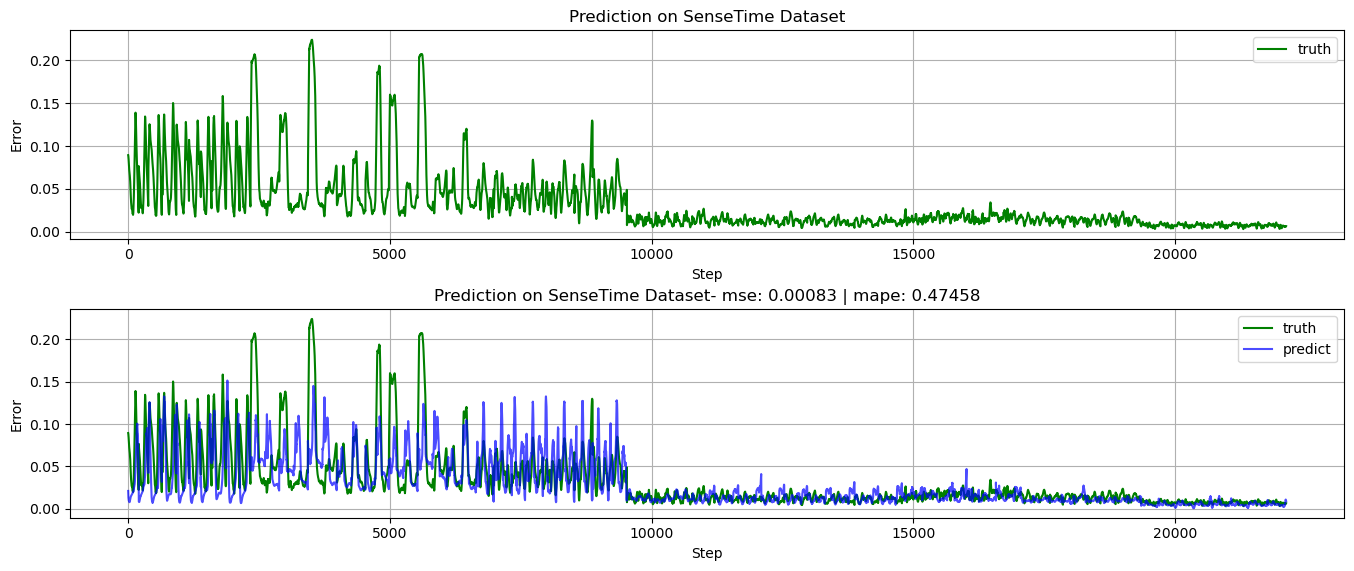

In [34]:
visualize_output(y, y_pred, title='Prediction on SenseTime Dataset')

In [35]:
IDs[10000]

100300500826